# <span style="color:#e0bda8; font-size: 40px;">To Grant or Not to Grant</span>


# <span style="color:#e0bda8">0. Context</span>

The New York Workers’ Compensation Board (WCB) handles claims related to workplace injuries, a process that is often time-consuming when done manually. This project aims to develop a machine learning model to predict the "Claim Injury Type" based on historical claims data from 2020 to 2022. By automating this classification, we can help the WCB make quicker and more accurate decisions.

The project involves building and evaluating various multiclass classification models, optimizing their performance, and exploring key features that contribute to accurate predictions. Ultimately, the goal is to identify the best model that can efficiently assist in the decision-making process for new claims.


# <span style="color:#e0bda8">1. Import Packages and Libraries</span>

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import os
import sqlite3
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LassoCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# <span style="color:#e0bda8">2. Reading the Data</span>

In [187]:
df = pd.read_csv("./resources/train_data.csv")
df

C:\Users\Diogo\AppData\Local\Temp\ipykernel_51000\3596400553.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./resources/train_data.csv")


Accident Date  Age at Injury Alternative Dispute Resolution  \
0         2019-12-30           31.0                              N   
1         2019-08-30           46.0                              N   
2         2019-12-06           40.0                              N   
3                NaN            NaN                            NaN   
4         2019-12-30           61.0                              N   
...              ...            ...                            ...   
593466           NaN            NaN                            NaN   
593467    2022-12-13           72.0                              N   
593468           NaN            NaN                            NaN   
593469           NaN            NaN                            NaN   
593470           NaN            NaN                            NaN   

       Assembly Date Attorney/Representative  Average Weekly Wage  Birth Year  \
0         2020-01-01                       N                 0.00      1988.0   
1         2020-01-01                       Y              1745.93      1973.0   
2         2020-01-01                       N              1434.80      1979.0   
3         2020-01-01                     NaN                  NaN         NaN   
4         2020-01-01                       N                  NaN      1958.0   
...              ...                     ...                  ...         ...   
593466    2022-12-31                     NaN                  NaN         NaN   
593467    2022-12-31                       N                 0.00      1950.0   
593468    2022-12-31                     NaN                  NaN         NaN   
593469    2022-12-31                     NaN                  NaN         NaN   
593470    2022-12-31                     NaN                  NaN         NaN   

          C-2 Date    C-3 Date                   Carrier Name  ...  \
0       2019-12-31         NaN     NEW HAMPSHIRE INSURANCE CO  ...   
1       2020-01-01  2020-01-14   ZURICH AMERICAN INSURANCE CO  ...   
2       2020-01-01         NaN      INDEMNITY INSURANCE CO OF  ...   
3              NaN         NaN                            NaN  ...   
4       2019-12-31         NaN           STATE INSURANCE FUND  ...   
...            ...         ...                            ...  ...   
593466         NaN         NaN                            NaN  ...   
593467  2022-12-31         NaN  TECHNOLOGY INSURANCE CO. INC.  ...   
593468         NaN         NaN                            NaN  ...   
593469         NaN         NaN                            NaN  ...   
593470         NaN         NaN                            NaN  ...   

       WCIO Cause of Injury Code  WCIO Cause of Injury Description  \
0                           27.0      FROM LIQUID OR GREASE SPILLS   
1                           97.0                 REPETITIVE MOTION   
2                           79.0    OBJECT BEING LIFTED OR HANDLED   
3                            NaN                               NaN   
4                           16.0   HAND TOOL, UTENSIL; NOT POWERED   
...                          ...                               ...   
593466                       NaN                               NaN   
593467                      25.0  FROM DIFFERENT LEVEL (ELEVATION)   
593468                       NaN                               NaN   
593469                       NaN                               NaN   
593470                       NaN                               NaN   

       WCIO Nature of Injury Code WCIO Nature of Injury Description  \
0                            10.0                         CONTUSION   
1                            49.0                    SPRAIN OR TEAR   
2                             7.0                        CONCUSSION   
3                             NaN                               NaN   
4                            43.0                          PUNCTURE   
...                           ...                               ...   
593466        

# <span style="color:#e0bda8">3. Metadata</span>
- **Accident Date** - Injury date of the claim.
- **Age at Injury** - Age of injured worker when the injury occured.
- **Alternative Dispute Resolution** - Adjudication processes external to the Board.
- **Assembly Date** - The date the claim was first assembled.
- **Attorney/Representative** - Is the claim being represented by an Attorney?
- **Average Weekly Wage** - The wage used to calculate workers' compensation, disability, or an Paid Leave wage replacement benefits.
- **Birth Year** - The reported year of birth of the injured worker.
- **C-2 Date** - Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).
- **C-3 Date** - Date Form C-3 (Employee Claim Form) was received.
- **Carrier Name** - Name of primary insurance provider responsible for providing workers' compensation coverage to the injured worker's employer.
- **Carrier Type** - Type of primary insurance provider responsible for providing workers' compensation coverage.
- **Claim Identifier** - Unique identifier for each claim, assigned by WCB.
- **Count of Injury** - Name of the New York County where the injury occured.
- **COVID-19 Indicator** - Indication that the claim may be associated with COVID-19.
- **District Name** - Name of the WCB district office that oversees claims for that region or area of the state.
- **First Hearing Date** - Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held.
- **Gender** - The reported gender of the injured worker.
- **IME-4 Count** - Number of IME-4 forms received per claim. The IME-4 form is the "Independent Examiner's Report of Independent Medical Examination" form.
- **Industry Code** - NAICS code and descriptions are available at: https://www.naics.com/search-naics-codes-by-industry/.
- **Industry Code Description** - 2-digit NAICS industry code description used to classify businesses according to their economic activity.
- **Medical Fee Region** - Approximate region where the injured worker would receive medical service.
- **OIICS Nature of Injury Description** - The OIICS nature of injury codes & descriptions are available at: https://www.bls.gov/iif/oiics_manual_2007.pdf.
- **WCIO Cause of Injury Code** - The WCIO cause of injury codes & descriptions are  at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf.
- **WCIO Cause of Injury Description** - See description of field above.
- **WCIO Nature of Injury Code** - The WCIO nature of injury are available at
 https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf.
- **WCIO Nature of Injury Description** - See description of field above.
- **WCIO Part Of Body Code** - The WCIO part of body codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf.
- **WCIO Part Of Body Description** - See description of field above.
- **Zip Code** - The reported ZIP code of the injured worker’s home address.
- **Agreement Reached** - Binary variable: Yes if there is an agreement without the involvement of the WCB -> unknown at the start of a claim.
- **WCB Decision** - Multiclass variable: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> requires WCB deliberation so it is unknown at start of claim.
- **Claim Injury Type** - Main target variable: Deliberation of the WCB relative to benefits awarded to the claim. Numbering indicates severity.

# <span style="color:#e0bda8">4. Dataset Overview</span>

## What are some characteristics of our data?

In [188]:
df.shape

(593471, 33)

In [189]:
df.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents'],
      dtype='object')

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [191]:
# Calculating the number of missing values
missing_values = df.isnull().sum()

# Adding percentage of missing values
total_rows = len(df)
missing_percentage = (missing_values / total_rows) * 100

# Creating a DataFrame with the count and percentage of missing values
missing_data = pd.DataFrame(
    {"Missing Values": missing_values, "Percentage": missing_percentage}
)

# Sorting by the frequency of missing values
sorted_missing_data = missing_data.sort_values(by="Missing Values", ascending=False)

sorted_missing_data.head(33)

Missing Values  Percentage
OIICS Nature of Injury Description          593471  100.000000
IME-4 Count                                 460668   77.622664
First Hearing Date                          442673   74.590502
C-3 Date                                    406226   68.449174
Birth Year                                   48523    8.176137
Average Weekly Wage                          48096    8.104187
Zip Code                                     48082    8.101828
WCIO Part Of Body Description                36527    6.154808
WCIO Part Of Body Code                       36527    6.154808
WCIO Nature of Injury Description            35102    5.914695
WCIO Nature of Injury Code                   35102    5.914695
WCIO Cause of Injury Description             35085    5.911831
WCIO Cause of Injury Code                    35085    5.911831
C-2 Date                                     34005    5.729850
Industry Code Description                    29403    4.954412
Industry Code                                29403    4.954412
Accident Date                                23134    3.898084
Gender                                       19445    3.276487
Age at Injury                                19445    3.276487
District Name                                19445    3.276487
COVID-19 Indicator                           19445    3.276487
Medical Fee Region                           19445    3.276487
County of Injury                             19445    3.276487
Claim Injury Type                            19445    3.276487
Carrier Type                                 19445    3.276487
Carrier Name                                 19445    3.276487
Attorney/Representative                      19445    3.276487
Alternative Dispute Resolution               19445    3.276487
Agreement Reached                            19445    3.276487
WCB Decision                                 19445    3.276487
Number of Dependents                         19445    3.276487
Claim Identifier                                 0    0.000000
Assembly Date                                    0    0.000000

In [192]:
df[df.duplicated()]

Empty DataFrame
Columns: [Accident Date, Age at Injury, Alternative Dispute Resolution, Assembly Date, Attorney/Representative, Average Weekly Wage, Birth Year, C-2 Date, C-3 Date, Carrier Name, Carrier Type, Claim Identifier, Claim Injury Type, County of Injury, COVID-19 Indicator, District Name, First Hearing Date, Gender, IME-4 Count, Industry Code, Industry Code Description, Medical Fee Region, OIICS Nature of Injury Description, WCIO Cause of Injury Code, WCIO Cause of Injury Description, WCIO Nature of Injury Code, WCIO Nature of Injury Description, WCIO Part Of Body Code, WCIO Part Of Body Description, Zip Code, Agreement Reached, WCB Decision, Number of Dependents]
Index: []

[0 rows x 33 columns]

In [193]:
# Claim Identifier analysis
df[df["Claim Identifier"].duplicated() == True].T

526445
Accident Date                              NaN
Age at Injury                              NaN
Alternative Dispute Resolution             NaN
Assembly Date                       2022-09-05
Attorney/Representative                    NaN
Average Weekly Wage                        NaN
Birth Year                                 NaN
C-2 Date                                   NaN
C-3 Date                                   NaN
Carrier Name                               NaN
Carrier Type                               NaN
Claim Identifier                     292668076
Claim Injury Type                          NaN
County of Injury                           NaN
COVID-19 Indicator                         NaN
District Name                              NaN
First Hearing Date                         NaN
Gender                                     NaN
IME-4 Count                                NaN
Industry Code                              NaN
Industry Code Description                  NaN
Medical Fee Region                         NaN
OIICS Nature of Injury Description         NaN
WCIO Cause of Injury Code                  NaN
WCIO Cause of Injury Description           NaN
WCIO Nature of Injury Code                 NaN
WCIO Nature of Injury Description          NaN
WCIO Part Of Body Code                     NaN
WCIO Part Of Body Description              NaN
Zip Code                                   NaN
Agreement Reached                          NaN
WCB Decision                               NaN
Number of Dependents                       NaN

In [194]:
df[df["Claim Identifier"] == 292668076]

Accident Date  Age at Injury Alternative Dispute Resolution  \
257901           NaN            NaN                            NaN   
526445           NaN            NaN                            NaN   

       Assembly Date Attorney/Representative  Average Weekly Wage  Birth Year  \
257901    2021-05-21                     NaN                  NaN         NaN   
526445    2022-09-05                     NaN                  NaN         NaN   

       C-2 Date C-3 Date Carrier Name  ... WCIO Cause of Injury Code  \
257901      NaN      NaN          NaN  ...                       NaN   
526445      NaN      NaN          NaN  ...                       NaN   

        WCIO Cause of Injury Description WCIO Nature of Injury Code  \
257901                               NaN                        NaN   
526445                               NaN                        NaN   

       WCIO Nature of Injury Description WCIO Part Of Body Code  \
257901                               NaN                    NaN   
526445                               NaN                    NaN   

       WCIO Part Of Body Description Zip Code Agreement Reached  WCB Decision  \
257901                           NaN      NaN               NaN           NaN   
526445                           NaN      NaN               NaN           NaN   

        Number of Dependents  
257901                   NaN  
526445                   NaN  

[2 rows x 33 columns]

## Initial Data Insights

After importing the dataset and using the `info()` method, we gathered the following key insights:

### 1. Missing Values:
   Almost all columns in the dataset have missing values, except for:
- `Assembly Date`
- `Claim Identifier`

The variables **`OIICS Natue of Injury Description`**, **`IME-4 Count`**, **`First Hearing Date`** and **`C-3 Date`** have extremely high percentages of missing values (all above 65% of missing values). Particularly, the variable **`OIICS Nature of Injury Description`** has **100% missing values**, indicating that it is entirely missing across all entries in the dataset.

### 2. Potential Data Type Issues:
   - **Date Columns** (`Accident Date`, `Assembly Date`, `C-2 Date`, `C-3 Date`, `First Hearing Date`): These are currently stored as `object` types. They should be converted to `datetime` format for easier manipulation and analysis.
   - `Alternative Dispute Resolution`, `Attorney/Representative`, `COVID-19 INDICATOR`, `Agreement Reached`: These are likely binary variables but are stored as `object` or `float` types. Converting them to categorical or binary (`0` and `1`) might be more appropriate.
   - There are a lot of insconsistencies regarding data types, therefore further analysis should be performed in order to assure coherency.

### 3. Duplicates:
   There were no duplicates found.
    
These insights suggest that the dataset will require thorough preprocessing, including handling missing values and correcting data types to more suitable formats.

### 4. Claim Identifier as Potential Index:
 **Claim Identifier** contains a unique identifier for each claim, assigned by WCB, sugesting that it could potentially serve as the Index of the DataFrame. There was only one duplicate entry found, regarding **Claim Identifier 526445**, of which only two features did not contain NAs, further suporting this possibility.

## Data Type Analysis

- All categorical variables were assigned the data type category
- Date variables were assigned the data type datetime
- `Birth Year`,`Age at Injury`,`IME-4 Count` and `Number of Dependents` were converted from float to integer.

| Variable                           | Data Type | Change Data Type | New Data Type |
| ---------------------------------- | --------- | ---------------- | ------------- |
| Accident Date                      | object    | yes              | datetime      |
| Age at Injury                      | float     | yes              | int           |
| Alternative Dispute Resolution     | object    | yes              | object        |
| Assembly Date                      | object    | yes              | datetime      |
| Attorney/Representative            | object    | yes              | object        |
| Average Weekly Wage                | float     | no               |               |
| Birth Year                         | float     | yes              | int           |
| C-2 Date                           | object    | yes              | datetime      |
| C-3 Date                           | object    | yes              | datetime      |
| Carrier Name                       | object    | yes              | object        |
| Carrier Type                       | object    | yes              | object        |
| Claim Identifier                   | int       | yes              | object        |
| Claim Injury Type                  | object    | yes              | object        |
| County of Injury                   | object    | yes              | object        |
| COVID-19 Indicator                 | object    | yes              | object        |
| District Name                      | object    | yes              | object        |
| First Hearing Date                 | object    | yes              | datetime      |
| Gender                             | object    | yes              | object        |
| IME-4 Count                        | float     | yes              | int           |
| Industry Code                      | float     | yes              | object        |
| Industry Code Description          | object    | yes              | object        |
| Medical Fee Region                 | object    | yes              | object        |
| OIICS Nature of Injury Description | float     | no               |               |
| WCIO Cause of Injury Code          | float     | yes              | object        |
| WCIO Cause of Injury Description   | object    | yes              | object        |
| WCIO Nature of Injury Code         | float     | yes              | object        |
| WCIO Nature of Injury Description  | object    | yes              | object        |
| WCIO Part Of Body Code             | float     | yes              | object        |
| WCIO Part Of Body Description      | object    | yes              | object        |
| Zip Code                           | object    | yes              | object        |
| Agreement Reached                  | float     | yes              | object        |
| WCB Decision                       | object    | yes              | object        |
| Number of Dependents               | float     | yes              | int           |
 category      |
| WCIO 
& yes & int \\
\hline
\end{array}
\]


## Binary Representation Conversion
Our dataset has 4 binary variables: `Alternative Dispute Resolution`, `Attorney/Representative`, `COVID-19 INDICATOR`, `Agreement Reached`, which we will now convert to the same notation. 

In [195]:
df["Alternative Dispute Resolution"].value_counts()

Alternative Dispute Resolution
N    571412
Y      2609
U         5
Name: count, dtype: int64

In [196]:
# Convert Attorney/Representative to binary representation
df["Alternative Dispute Resolution"] = df["Alternative Dispute Resolution"].map(
    {"Y": 1, "N": 0, "U": np.nan}
)

# Verify the conversion
df["Alternative Dispute Resolution"].unique()

array([ 0., nan,  1.])

In [197]:
df["Attorney/Representative"].value_counts()

Attorney/Representative
N    392291
Y    181735
Name: count, dtype: int64

In [198]:
# Convert Attorney/Representative to binary representation
df["Attorney/Representative"] = df["Attorney/Representative"].map({"Y": 1, "N": 0})

# Verify the conversion
df["Attorney/Representative"].value_counts()

Attorney/Representative
0.0    392291
1.0    181735
Name: count, dtype: int64

In [199]:
df["COVID-19 Indicator"].value_counts()

COVID-19 Indicator
N    546505
Y     27521
Name: count, dtype: int64

In [200]:
# Convert COVID-19 Indicator to binary representation
df["COVID-19 Indicator"] = df["COVID-19 Indicator"].map({"Y": 1, "N": 0})

# Verify the conversion
df["COVID-19 Indicator"].value_counts()

COVID-19 Indicator
0.0    546505
1.0     27521
Name: count, dtype: int64

In [201]:
# No need to change
df["Agreement Reached"].value_counts()

Agreement Reached
0.0    547239
1.0     26787
Name: count, dtype: int64

## Data Type Conversion

In [202]:
# Lists of variables by type
datetime_vars = [
    "Accident Date",
    "Assembly Date",
    "C-2 Date",
    "C-3 Date",
    "First Hearing Date",
]
categorical_vars = [
    "Alternative Dispute Resolution",
    "Attorney/Representative",
    "Carrier Name",
    "Carrier Type",
    "Claim Identifier",
    "Claim Injury Type",
    "County of Injury",
    "COVID-19 Indicator",
    "District Name",
    "Gender",
    "Industry Code",
    "Industry Code Description",
    "WCIO Cause of Injury Description",
    "WCIO Nature of Injury Description",
    "WCIO Part Of Body Description",
    "Zip Code",
    "Agreement Reached",
    "WCB Decision",
    "WCIO Cause of Injury Code",
    "WCIO Nature of Injury Code",
    "WCIO Part Of Body Code",
    "OIICS Nature of Injury Description",
    "Medical Fee Region",
]
int_vars = ["Age at Injury", "Birth Year", "IME-4 Count", "Number of Dependents"]

# Changing data types
df[datetime_vars] = df[datetime_vars].apply(
    pd.to_datetime, errors="coerce"
)  # Change to datetime
df[categorical_vars] = df[categorical_vars].astype("object")  # Change to category
df[int_vars] = df[int_vars].astype(
    "Int64"
)  # Use 'Int64' with a capital I to allow NaNs

# Display the updated DataFrame dtypes
print(df.dtypes)

Accident Date                         datetime64[ns]
Age at Injury                                  Int64
Alternative Dispute Resolution                object
Assembly Date                         datetime64[ns]
Attorney/Representative                       object
Average Weekly Wage                          float64
Birth Year                                     Int64
C-2 Date                              datetime64[ns]
C-3 Date                              datetime64[ns]
Carrier Name                                  object
Carrier Type                                  object
Claim Identifier                              object
Claim Injury Type                             object
County of Injury                              object
COVID-19 Indicator                            object
District Name                                 object
First Hearing Date                    datetime64[ns]
Gender                                        object
IME-4 Count                                   

# <span style="color:#e0bda8">5. Univariate Analysis</span>

## Descriptive Statistics

In [203]:
df.describe(include="all").round(2).T

count    unique  \
Accident Date                         570337       NaN   
Age at Injury                       574026.0      <NA>   
Alternative Dispute Resolution      574021.0       2.0   
Assembly Date                         593471       NaN   
Attorney/Representative             574026.0       2.0   
Average Weekly Wage                 545375.0       NaN   
Birth Year                          544948.0      <NA>   
C-2 Date                              559466       NaN   
C-3 Date                              187245       NaN   
Carrier Name                          574026      2046   
Carrier Type                          574026         8   
Claim Identifier                    593471.0  593470.0   
Claim Injury Type                     574026         8   
County of Injury                      574026        63   
COVID-19 Indicator                  574026.0       2.0   
District Name                         574026         8   
First Hearing Date                    150798       NaN   
Gender                                574026         4   
IME-4 Count                         132803.0      <NA>   
Industry Code                       564068.0      24.0   
Industry Code Description             564068        20   
Medical Fee Region                    574026         5   
OIICS Nature of Injury Description         0         0   
WCIO Cause of Injury Code           558386.0      77.0   
WCIO Cause of Injury Description      558386        74   
WCIO Nature of Injury Code          558369.0      56.0   
WCIO Nature of Injury Description     558369        56   
WCIO Part Of Body Code              556944.0      57.0   
WCIO Part Of Body Description         556944        54   
Zip Code                              545389     10060   
Agreement Reached                   574026.0       2.0   
WCB Decision                          574026         1   
Number of Dependents                574026.0      <NA>   

                                                                  top  \
Accident Date                                                     NaN   
Age at Injury                                                    <NA>   
Alternative Dispute Resolution                                    0.0   
Assembly Date                                                     NaN   
Attorney/Representative                                           0.0   
Average Weekly Wage                                               NaN   
Birth Year                                                       <NA>   
C-2 Date                                                          NaN   
C-3 Date                                                          NaN   
Carrier Name                                     STATE INSURANCE FUND   
Carrier Type                                              1A. PRIVATE   
Claim Identifier                                          292668076.0   
Claim Injury Type                                         2. NON-COMP   
County of Injury                                              SUFFOLK   
COVID-19 Indicator                                                0.0   
District Name                                                     NYC   
First Hearing Date                                                NaN   
Gender                                                              M   
IME-4 Count                                                      <NA>   
Industry Code                                                    62.0   
Industry Code Description           HEALTH CARE AND SOCIAL ASSISTANCE   
Medical Fee Region                                                 IV   
OIICS Nature of Injury Description                                NaN   
WCIO Cause of Injury Code                                        56.0   
WCIO Cause of Injury Description                              LIFTING   
WCIO Nature of Injury Code                                       52.0   
WCIO Nature of Injury Description                      STRAIN OR TEAR   
WCIO Part Of Body Code

## Variance

In [204]:
df.var(numeric_only=True)

Age at Injury                203.245853
Average Weekly Wage     37123651.221805
Birth Year                171929.997916
IME-4 Count                    8.021942
Number of Dependents           4.003206
dtype: Float64

## Insights from Variance Output of Numeric Variables

### 1. **High Variability in Key Variables**
- **Average Weekly Wage**: The variance of **37,123,650** suggests a significant disparity in wages among the claims. This indicates that while many claimants may earn a typical wage, there are outliers earning substantially higher amounts. This high variance could skew analyses related to compensation and benefits.
  
- **Claim Identifier**: With a variance of **1.164827e+16**, this suggests a large range of values. If this is truly an identifier, it should ideally have low variance, indicating a consistent format across entries. A high variance in claim identifiers may point to inconsistencies in data entry or generation processes.

### 2. **Moderate to Low Variability in Other Variables**
- **Age at Injury**: The variance of **203.25** indicates that most injured workers fall within a relatively similar age range, but with some variation. This could help identify demographic trends in workplace injuries.
  
- **IME-4 Count**: A variance of **8.02** suggests that the number of IME-4 forms received per claim does not vary widely, indicating that most claims are likely processed similarly in terms of medical evaluations.

- **Number of Dependents**: The variance of **4.00** shows some variability, suggesting that claims can vary in the number of dependents involved. This may affect benefit calculations and eligibility for support.

### 3. **Low Variance in Certain Injury Codes**
- **Industry Code**: The variance of **385.89** indicates diversity in industries but also suggests that many claims likely come from a core set of industries, which could be explored further in analysis.

- **WCIO Cause of Injury Code** and **WCIO Nature of Injury Code** have variances of **669.48** and **493.17**, respectively, suggesting a moderate amount of variability in the nature and causes of injuries, but still indicate some level of concentration in certain categories.

### 4. **Variable with No Variance**
- **OIICS Nature of Injury Description** has no entries (NaN), indicating a complete lack of data. This variable should either be addressed through data cleaning or removed from further analysis.

### 5. **Binary Variable Variance**
- **Agreement Reached** has a very low variance of **0.0445**, reflecting that the vast majority of claims do not result in an agreement without the involvement of WCB. This suggests that such outcomes are rare and may require special consideration in analyses.

## Recommendations
- **Investigate Outliers**: For variables with high variance, especially Average Weekly Wage, consider investigating outliers to determine if they represent legitimate data points or errors.
- **Data Validation**: Ensure that the Claim Identifier is being generated and recorded consistently across the dataset to prevent issues in further analyses.
- **Explore Demographics**: Utilize the Age at Injury variable to analyze trends related to age demographics in workplace injuries.
- **Consider Variable Removal**: If certain variables (like OIICS Nature of Injury Description) are consistently NaN, they may not be useful for analysis and should be considered for removal.

## Categorical and Numerical Features Division
In this part of the univariate analysis we split the features in metric an non-metric features.

In [205]:
import pandas as pd

# Create empty lists to hold column names
numeric = []
categorical = []
categorical_non_high_cardinality = []

# Define a threshold for high cardinality
threshold = 25

# Loop through the DataFrame columns to classify them
for column in df.columns:
    # Check if the column is a datetime type
    if pd.api.types.is_datetime64_any_dtype(df[column]):
        categorical.append(column)  # Treat datetime as categorical features
    elif (
        isinstance(df[column].dtype, pd.CategoricalDtype)
        or df[column].dtype == "object"
    ):
        categorical.append(column)  # Add to categorical features
        # Check for high cardinality
        if df[column].nunique() < threshold:
            categorical_non_high_cardinality.append(
                column
            )  # Add to non-high-cardinality categorical features
    else:
        numeric.append(column)  # Add to numeric features

# Convert lists to DataFrames
numeric_features = df[numeric]
categorical_features = df[categorical]
non_high_cardinality_features = df[categorical_non_high_cardinality]

# Get date features
date_features = categorical_features.filter(regex="Date")

# Output the results
print("Categorical features:\n", categorical, "\n")
print("Numerical features:\n", numeric, "\n")
print(
    "Categorical non-high-cardinality features:\n",
    categorical_non_high_cardinality,
    "\n",
)

Categorical features:
 ['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'Claim Identifier', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code', 'Industry Code Description', 'Medical Fee Region', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'Agreement Reached', 'WCB Decision'] 

Numerical features:
 ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents'] 

Categorical non-high-cardinality features:
 ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Type', 'Claim Injury Type', 'COVID-19 Indicator', 'District Name', 'Gender', 'Industry Code', 'Industry Code Desc

## Categorical Features Analysis

In [206]:
categorical_features.astype("category").describe().T

count  unique  \
Accident Date                         570337    5539   
Alternative Dispute Resolution      574021.0     2.0   
Assembly Date                         593471    1096   
Attorney/Representative             574026.0     2.0   
C-2 Date                              559466    2475   
C-3 Date                              187245    1648   
Carrier Name                          574026    2046   
Carrier Type                          574026       8   
Claim Identifier                      593471  593470   
Claim Injury Type                     574026       8   
County of Injury                      574026      63   
COVID-19 Indicator                  574026.0     2.0   
District Name                         574026       8   
First Hearing Date                    150798    1094   
Gender                                574026       4   
Industry Code                       564068.0    24.0   
Industry Code Description             564068      20   
Medical Fee Region                    574026       5   
OIICS Nature of Injury Description         0       0   
WCIO Cause of Injury Code           558386.0    77.0   
WCIO Cause of Injury Description      558386      74   
WCIO Nature of Injury Code          558369.0    56.0   
WCIO Nature of Injury Description     558369      56   
WCIO Part Of Body Code              556944.0    57.0   
WCIO Part Of Body Description         556944      54   
Zip Code                              545389   10060   
Agreement Reached                   574026.0     2.0   
WCB Decision                          574026       1   

                                                                  top  \
Accident Date                                     2020-03-01 00:00:00   
Alternative Dispute Resolution                                    0.0   
Assembly Date                                     2020-03-06 00:00:00   
Attorney/Representative                                           0.0   
C-2 Date                                          2021-05-11 00:00:00   
C-3 Date                                          2021-04-21 00:00:00   
Carrier Name                                     STATE INSURANCE FUND   
Carrier Type                                              1A. PRIVATE   
Claim Identifier                                            292668076   
Claim Injury Type                                         2. NON-COMP   
County of Injury                                              SUFFOLK   
COVID-19 Indicator                                                0.0   
District Name                                                     NYC   
First Hearing Date                                2022-04-15 00:00:00   
Gender                                                              M   
Industry Code                                                    62.0   
Industry Code Description           HEALTH CARE AND SOCIAL ASSISTANCE   
Medical Fee Region                                                 IV   
OIICS Nature of Injury Description                                NaN   
WCIO Cause of Injury Code                                        56.0   
WCIO Cause of Injury Description                              LIFTING   
WCIO Nature of Injury Code                                       52.0   
WCIO Nature of Injury Description                      STRAIN OR TEAR   
WCIO Part Of Body Code                                           42.0   
WCIO Part Of Body Description                         LOWER BACK AREA   
Zip Code                                                        11236   
Agreement Reached                                                 0.0   
WCB Decision                                         Not Work Related   

                                        freq  
Accident Date                           1245  
Alternative Dispute Resolution      571412.0  
Assembly Date                           1422  
Attorney/Representative             392291.0  
C-2 Date                                1847  
C-3 Date      

In [207]:
# Calculating the number of missing values
missing_values = categorical_features.isnull().sum()

# Adding percentage of missing values
total_rows = len(categorical_features)
missing_percentage = (missing_values / total_rows) * 100

# Creating a DataFrame with the count and percentage of missing values
missing_data = pd.DataFrame(
    {"Missing Values": missing_values, "Percentage": missing_percentage}
)

# Sorting by the frequency of missing values
sorted_missing_data = missing_data.sort_values(by="Missing Values", ascending=False)

sorted_missing_data.head(33)

Missing Values  Percentage
OIICS Nature of Injury Description          593471  100.000000
First Hearing Date                          442673   74.590502
C-3 Date                                    406226   68.449174
Zip Code                                     48082    8.101828
WCIO Part Of Body Description                36527    6.154808
WCIO Part Of Body Code                       36527    6.154808
WCIO Nature of Injury Description            35102    5.914695
WCIO Nature of Injury Code                   35102    5.914695
WCIO Cause of Injury Description             35085    5.911831
WCIO Cause of Injury Code                    35085    5.911831
C-2 Date                                     34005    5.729850
Industry Code                                29403    4.954412
Industry Code Description                    29403    4.954412
Accident Date                                23134    3.898084
Alternative Dispute Resolution               19450    3.277329
Medical Fee Region                           19445    3.276487
Agreement Reached                            19445    3.276487
Gender                                       19445    3.276487
District Name                                19445    3.276487
COVID-19 Indicator                           19445    3.276487
County of Injury                             19445    3.276487
Claim Injury Type                            19445    3.276487
Carrier Type                                 19445    3.276487
Carrier Name                                 19445    3.276487
Attorney/Representative                      19445    3.276487
WCB Decision                                 19445    3.276487
Claim Identifier                                 0    0.000000
Assembly Date                                    0    0.000000

In [208]:
categorical_features["WCIO Part Of Body Code"]

0         62.0
1         38.0
2         10.0
3          NaN
4         36.0
          ... 
593466     NaN
593467    -9.0
593468     NaN
593469     NaN
593470     NaN
Name: WCIO Part Of Body Code, Length: 593471, dtype: object

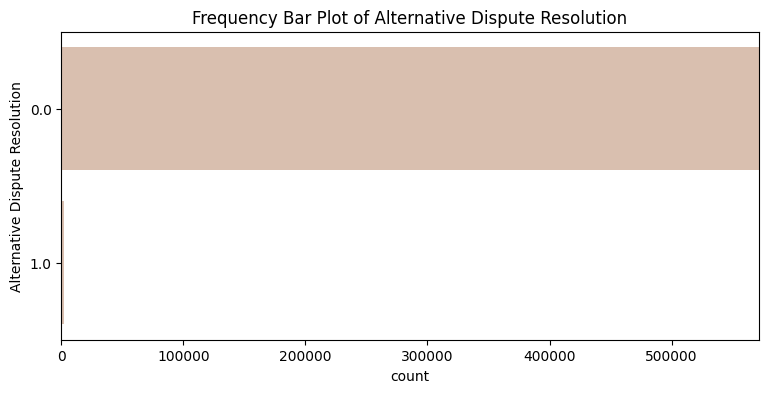

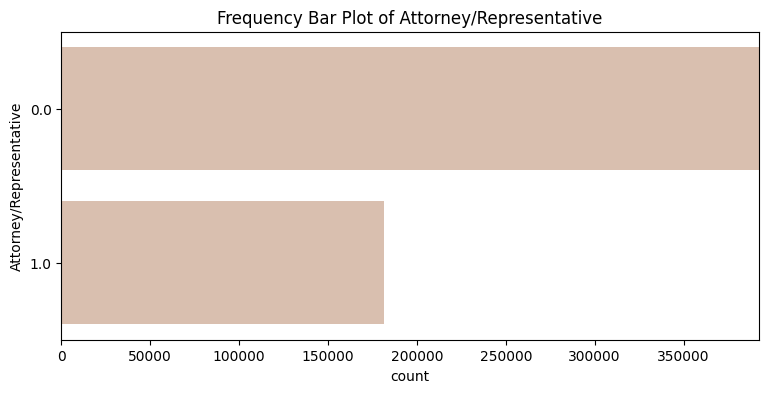

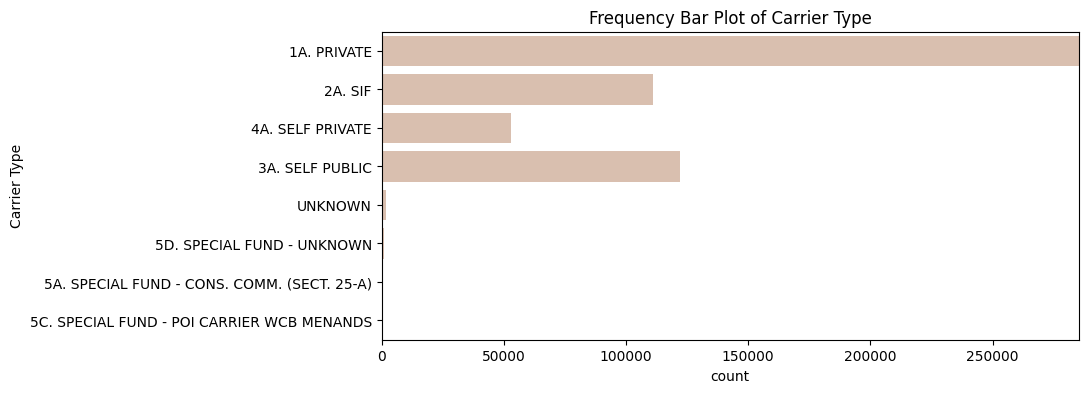

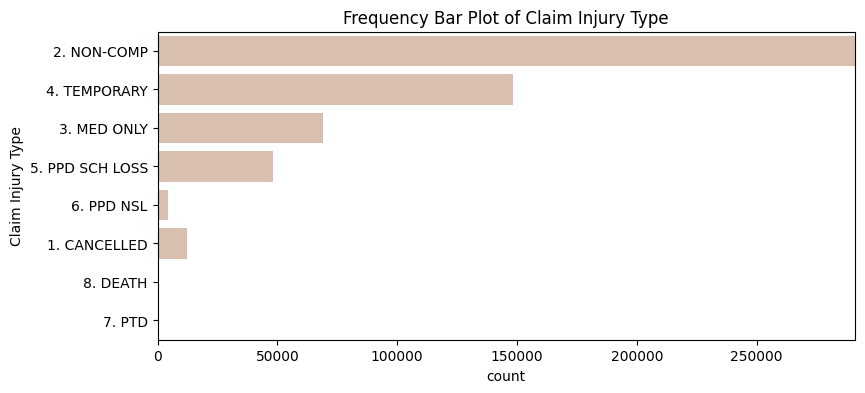

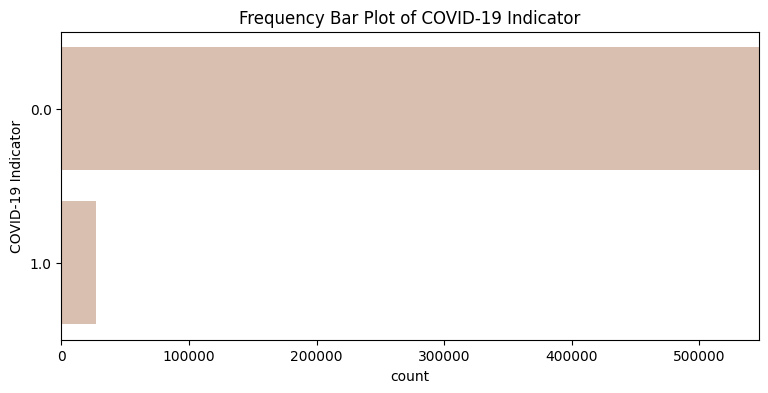

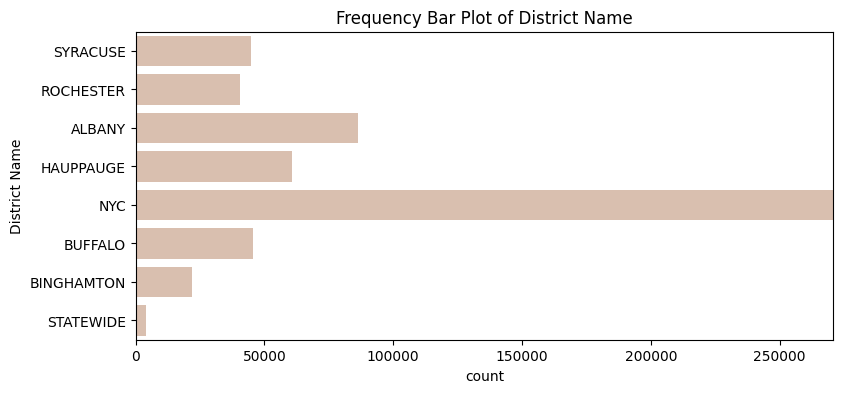

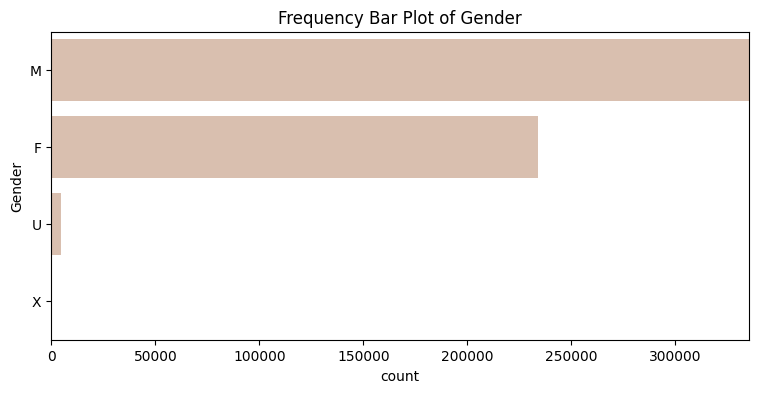

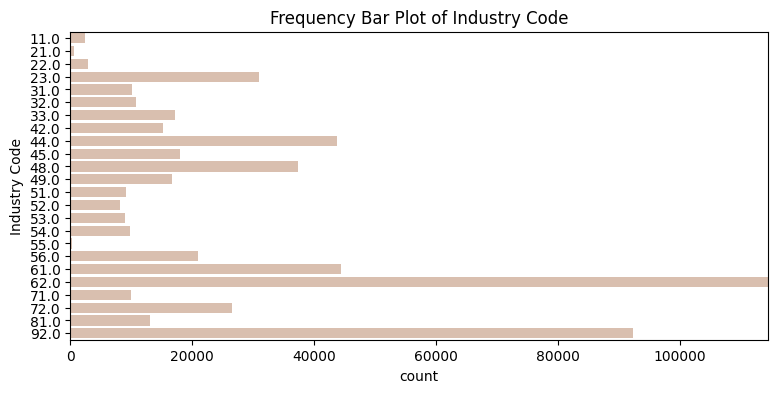

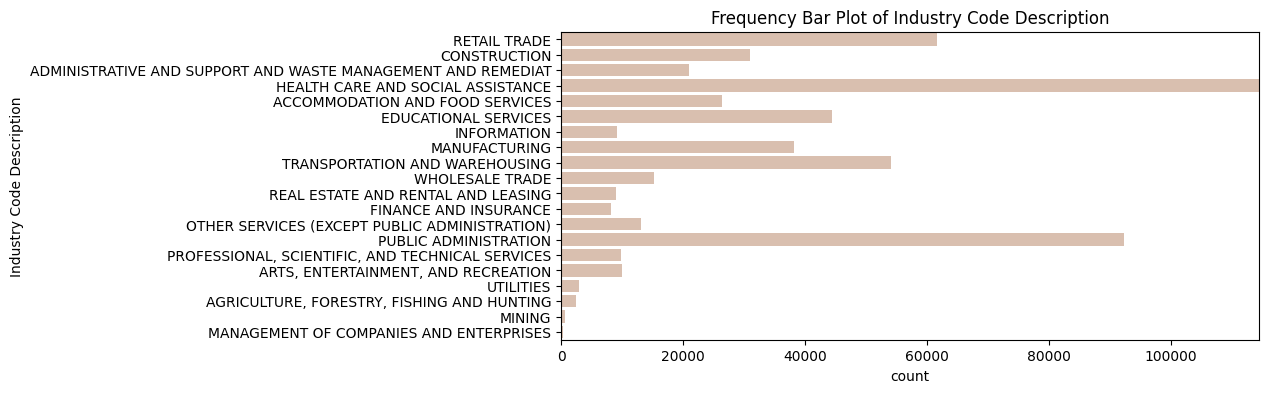

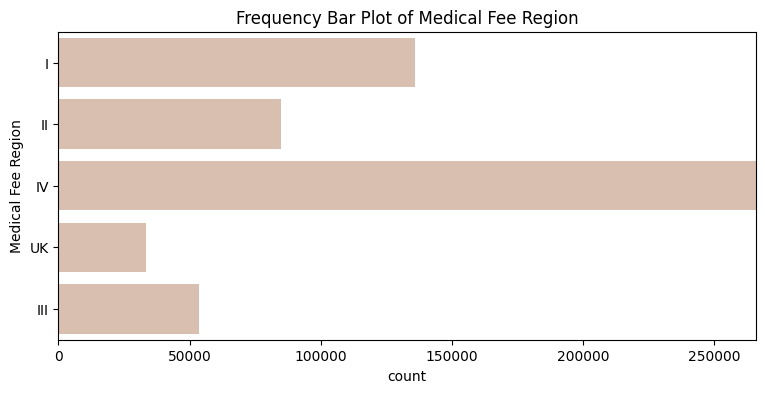

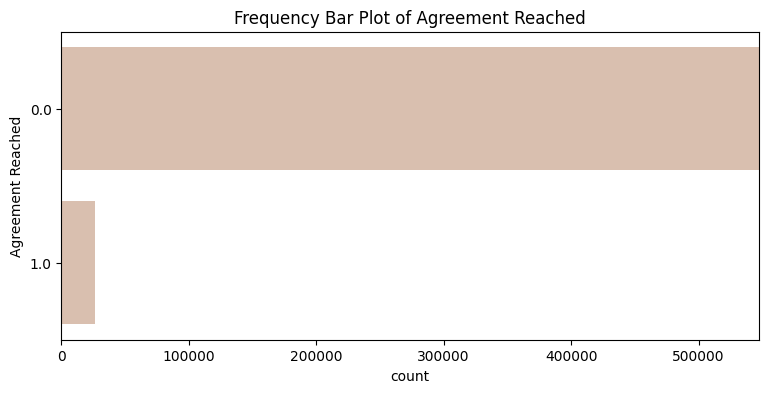

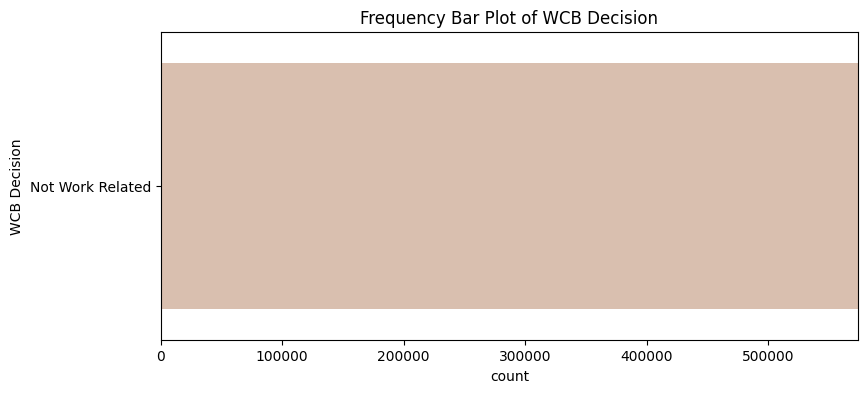

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through the non-high-cardinality categorical features
for var in non_high_cardinality_features.drop(
    columns=["OIICS Nature of Injury Description"]
).columns:
    fig, ax = plt.subplots(figsize=(9, 4))

    # Create a horizontal count plot for categorical data
    sns.countplot(data=non_high_cardinality_features, y=var, ax=ax, color="#e0bda8")

    # Set title
    ax.set_title(f"Frequency Bar Plot of {var}")

    # Calculate counts for setting x-axis limit
    counts = non_high_cardinality_features[var].value_counts()

    # Set x-axis limit based on the counts
    if not counts.empty:
        ax.set_xlim(0, counts.max() + 1)  # Add a little space to the right of max count
    else:
        ax.set_xlim(0, 1)  # Set a default limit if no data is available

    # Show the plot
    plt.show()

## Insights from Categorical Features Analysis

### 1. Feature with 100% Missing Values
- The **OIICS Nature of Injury Description** column has no entries at all (`0.0 count`), indicating that this variable is entirely missing. This may require dropping the column from analysis or substituting it with an appropriate placeholder if needed.
  
### 2. High Cardinality in Categorical Variables
- As previously stated, many variables, particularly code variables, such as **`WCIO Cause of Injury Code`** have a large number of unique values (56944). While this is expected considering the nature of the dataset, it may complicate analysis and visualization, leading to potential overfitting in models if not handled properly. 
### 3. Binary Variables with Low Variability
- **Agreement Reached** has a mean of **0.05**, indicating that only about 5% of claims result in an agreement without the involvement of WCB. This could signal a lack of diversity in outcomes.
- **COVID-19 Indicator** has a similar pattern, showing that the majority of claims do not appear to be related to COVID-19.

### 4. Unusual Values
- **Gender**: There are **4 unique values** for this column, which is unexpected if it typically only represents male and female. Investigating these unique values could be helpful.
- **WCB Decision**: The count indicates that every entry states “Not Work Related,” suggesting that this variable may not be functioning as expected, or it might require further investigation into why other categories are absent. Additionally, in the Metadata this variable is described as 
- **WCIO Part of Body Code**: There are negative values, which is unusual for a code.

## Recommendations
- **Clustering High-Cardinality Variables into Meaningful Subgroups**: To manage the high number of unique values, particularly seen in Code variables, we recommend grouping similar values into subcategories. This will reduce complexity, making patterns easier to identify and analyze. Clustering algorithms like K-Means can help create these subgroups, allowing us to label and interpret behaviors more effectively.
- **Consider Variable Removal**: If certain variables (like OIICS Nature of Injury Description) are consistently NaN, they may not be useful for analysis and should be considered for removal.

## Date Features Analysis

- **Accident Date** - Injury date of the claim.
- **Assembly Date** - The date the claim was first assembled.
- **C-2 Date** - Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).
- **C-3 Date** - Date Form C-3 (Employee Claim Form) was received.
- **First Hearing Date** - Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held.

In [210]:
date_features.describe().T

count                           mean  \
Accident Date       570337  2021-04-28 21:00:27.892982784   
Assembly Date       593471  2021-07-19 03:25:38.260841728   
C-2 Date            559466  2021-07-16 20:11:19.865443328   
C-3 Date            187245  2021-07-26 21:31:28.449891840   
First Hearing Date  150798  2022-03-19 05:07:38.218278400   

                                    min                  25%  \
Accident Date       1961-09-06 00:00:00  2020-09-14 00:00:00   
Assembly Date       2020-01-01 00:00:00  2020-10-26 00:00:00   
C-2 Date            1996-01-12 00:00:00  2020-11-06 00:00:00   
C-3 Date            1992-11-13 00:00:00  2020-10-27 00:00:00   
First Hearing Date  2020-01-30 00:00:00  2021-06-01 00:00:00   

                                    50%                  75%  \
Accident Date       2021-06-27 00:00:00  2022-03-21 00:00:00   
Assembly Date       2021-07-29 00:00:00  2022-04-19 00:00:00   
C-2 Date            2021-08-09 00:00:00  2022-04-26 00:00:00   
C-3 Date            2021-07-21 00:00:00  2022-04-20 00:00:00   
First Hearing Date  2022-03-09 00:00:00  2023-01-11 00:00:00   

                                    max  
Accident Date       2023-09-29 00:00:00  
Assembly Date       2022-12-31 00:00:00  
C-2 Date            2024-06-01 00:00:00  
C-3 Date            2024-05-31 00:00:00  
First Hearing Date  2024-06-07 00:00:00

#### Data Range Analysis

In [211]:
for col in [
    "Accident Date",
    "Assembly Date",
    "C-2 Date",
    "C-3 Date",
    "First Hearing Date",
]:

    min_date = df[col].min()

    max_date = df[col].max()

    print(f"{col} - Min Date: {min_date}, Max Date: {max_date}")

Accident Date - Min Date: 1961-09-06 00:00:00, Max Date: 2023-09-29 00:00:00
Assembly Date - Min Date: 2020-01-01 00:00:00, Max Date: 2022-12-31 00:00:00
C-2 Date - Min Date: 1996-01-12 00:00:00, Max Date: 2024-06-01 00:00:00
C-3 Date - Min Date: 1992-11-13 00:00:00, Max Date: 2024-05-31 00:00:00
First Hearing Date - Min Date: 2020-01-30 00:00:00, Max Date: 2024-06-07 00:00:00


#### Checking the chronological distribution of the other dates compraing to Accident Date

In [212]:
date_features2 = date_features.copy()

# Check if Accident Date is after the other dates using .loc
date_features2.loc[:, "Accident After Assembly"] = (
    date_features2["Accident Date"] > date_features2["Assembly Date"]
)
date_features2.loc[:, "Accident After C-2"] = (
    date_features2["Accident Date"] > date_features2["C-2 Date"]
)
date_features2.loc[:, "Accident After C-3"] = (
    date_features2["Accident Date"] > date_features2["C-3 Date"]
)
date_features2.loc[:, "Accident After First Hearing"] = (
    date_features2["Accident Date"] > date_features2["First Hearing Date"]
)

# Count unique combinations of the True/False values for each column
combination_counts = date_features2[
    [
        "Accident After Assembly",
        "Accident After C-2",
        "Accident After C-3",
        "Accident After First Hearing",
    ]
].value_counts()

# Display the combination counts
print(combination_counts)

Accident After Assembly  Accident After C-2  Accident After C-3  Accident After First Hearing
False                    False               False               False                           591770
True                     True                True                False                              509
                         False               True                False                              493
                         True                False               False                              318
False                    False               True                False                              209
                         True                False               False                               77
True                     True                True                True                                66
                         False               False               False                               13
False                    True                True                False    

#### Time differences from Accident Date

In [213]:
# Calculate time differences
date_features2["Days to Assembly"] = (
    date_features2["Assembly Date"] - date_features2["Accident Date"]
).dt.days
date_features2["Days to C-2"] = (
    date_features2["C-2 Date"] - date_features2["Accident Date"]
).dt.days
date_features2["Days to C-3"] = (
    date_features2["C-3 Date"] - date_features2["Accident Date"]
).dt.days
date_features2["Days to First Hearing"] = (
    date_features2["First Hearing Date"] - date_features2["Accident Date"]
).dt.days

date_features2[
    ["Days to Assembly", "Days to C-2", "Days to C-3", "Days to First Hearing"]
].describe()

Days to Assembly   Days to C-2    Days to C-3  Days to First Hearing
count     570337.000000  557346.00000  183798.000000          149347.000000
mean          82.227483      70.35153      97.444298             335.081984
std          603.986690     511.63367     406.096844             438.469419
min        -1127.000000   -8842.00000   -9870.000000            -576.000000
25%            5.000000       5.00000      12.000000             147.000000
50%           10.000000      10.00000      27.000000             237.000000
75%           24.000000      27.00000      71.000000             420.000000
max        21503.000000   21503.00000   18566.000000           16373.000000

#### Birth Year computed from variables Accident Date and Age at Injury VS Birth Year variable

In [214]:
df_copy = df.copy()

df_copy["Computed Birth Year"] = (
    df_copy["Accident Date"].dt.year - df_copy["Age at Injury"]
).astype("Int64")
df_copy[df_copy["Computed Birth Year"] == df_copy["Birth Year"]][
    ["Computed Birth Year", "Birth Year"]
].head()

Computed Birth Year  Birth Year
0                 1988        1988
1                 1973        1973
2                 1979        1979
4                 1958        1958
5                 1952        1952

In [215]:
print(
    f"The percentage of times the Cumputed Birth Year if equal to Birth Year is: {df_copy[df_copy['Computed Birth Year'] == df_copy['Birth Year']].shape[0]/df_copy.shape[0]*100}"
)

The percentage of times the Cumputed Birth Year if equal to Birth Year is: 46.055325365519124


In [216]:
df_copy[df_copy["Birth Year"] == 0].shape[0]

25081

In [217]:
print(
    f'The percentage of times the Cumputed Birth Year if equal to Birth Year is, excluding 0s in Birth Year: {df_copy[(df_copy["Computed Birth Year"] == df_copy["Birth Year"]) & (df_copy["Birth Year"] != 0)].shape[0]/df_copy[df_copy["Birth Year"] != 0].shape[0]*100}'
)

The percentage of times the Cumputed Birth Year if equal to Birth Year is, excluding 0s in Birth Year: 52.57594730960034


In [218]:
df_copy[
    (df_copy["Computed Birth Year"] != df_copy["Birth Year"])
    & (df_copy["Birth Year"] != 0)
][["Computed Birth Year", "Birth Year"]].head(150)

Computed Birth Year  Birth Year
13                   1957        1956
21                   1989        1988
65                   1955        1954
69                   1957        1958
125                  1964        1963
...                   ...         ...
1611                 1980        1979
1623                 1993        1994
1627                 1965        1964
1630                 1977        1976
1638                 1981        1980

[150 rows x 2 columns]

#### Checking for patterns is missing values

In [219]:
# Check for missing dates in each column
missing_dates = (
    date_features2[
        ["Accident Date", "Assembly Date", "C-2 Date", "C-3 Date", "First Hearing Date"]
    ]
    .isna()
    .sum()
)
print("Missing Dates Count:\n", missing_dates)

Missing Dates Count:
 Accident Date          23134
Assembly Date              0
C-2 Date               34005
C-3 Date              406226
First Hearing Date    442673
dtype: int64


In [220]:
# Calculating the number of missing values
missing_values = date_features.isnull().sum()

# Adding percentage of missing values
total_rows = date_features.shape[0]
missing_percentage = (missing_values / total_rows) * 100

# Creating a DataFrame with the count and percentage of missing values
missing_data = pd.DataFrame(
    {"Missing Values": missing_values, "Percentage": missing_percentage}
)

# Sorting by the frequency of missing values
sorted_missing_data = missing_data.sort_values(by="Missing Values", ascending=False)

sorted_missing_data.head()

Missing Values  Percentage
First Hearing Date          442673   74.590502
C-3 Date                    406226   68.449174
C-2 Date                     34005    5.729850
Accident Date                23134    3.898084
Assembly Date                    0    0.000000

#### Checking if all dates are valid dates

In [221]:
# List of date columns to check
date_columns = [
    "Accident Date",
    "Assembly Date",
    "C-2 Date",
    "C-3 Date",
    "First Hearing Date",
]

# Initialize an empty list to store invalid date information
invalid_dates_list = []

# Loop through each date column to check for invalid dates
for col in date_columns:
    # Check for invalid dates that are not NaT
    for index, date_value in date_features[col].items():
        if pd.notna(date_value):  # Only consider non-NaT values
            if not isinstance(
                date_value, pd.Timestamp
            ):  # Check if it is not a valid Timestamp
                invalid_dates_list.append(
                    {"Index": index, "Date Column": col, "Invalid Date": date_value}
                )

# Convert list of invalid dates to a DataFrame
if invalid_dates_list:
    invalid_dates_df = pd.DataFrame(invalid_dates_list)
    print("Invalid dates found:")
    display(invalid_dates_df)
else:
    print("All dates are valid.")

All dates are valid.


## Insights from Date Features Analysis

### 1. Date Range
- The earliest date entry is **`Accident Date`** **2021-04-28** and the most recent date entry is **`C-2 Date`** **2024-05-31**.

### 2. Data Incoherencies
- In 99.7% of cases, the Accident Date happens before all the other dates. However, there still are several instances where that isn't the case.
- The most recent **`C-2 Date`** date entry is from 2024, while the date entries from all the other date variables are all from 2022, which may suggest an error.
- When computing the **`Birth Year`** from the variables **`Accident Date`** and **`Age at Injury`**, the percentage of times the **`Cumputed Birth Year`** was equal to **`Birth Year`**, excluding zeros in Birth Year, was 53%, which is extremely low. However, looking at the data, it is clear that the computed Birth Year and Birth Year are usually of by one year. Therefore, a decision must be made regarding which values to consider. It should be noted that **`Birth Year`** has of **8%** missing values and **25330** outliers, making it extremely problematic.

### 3. Missing Values
- **`Assembly Date`** has no missing values. However, all the other date variables have missing values.
-  **`First Hearing Date`** and **`C-3 Date`** have, respectively, 75% and 68% of missing values, indicating that not all claims have received this follow-up, which may impact analysis regarding claims processing times.

## Recommendations
- **Validate Date Entries**: Confirm that all dates are within a logical range (e.g., Accident Date is always before other date fields). If this is not the case, further investigate, replace or remove such entries.
- **Understanding Missing Values in Date Variables**: Understang the implications of missing values in data variables such as  **`First Hearing Date`** and **`C-3 Date`** which have, respectively, 75% and 68% of missing values. This indicates that not all claims have received this follow-up, which may impact analysis regarding claims processing times.
- **Handle Missing Values**: Use the appropriate methods to fill missing values for variables such as **`First Hearing Date`** and **`C-3 Date`**. Might be worth it to look into Indicator Variables, that is, creating binary columns indicating whether a date is missing (1) or present (0) to help analyze the impact of missing data.
- **Further analyze the variables `Birth Year`, `Age at Injury` and `Accident Date`**: As previously mentioned, all 3 variables have outliers and missing values. Particularly, the variable **`Birth Year`** has of **8%** missing values and **25330** outliers, making it extremely problematic. We can compute de Birth Year from **`Age at Injuty`** and **`Accident Date`**, using that information to validate information across these variables and have a better handling at missing values and outliers.

## Numeric Features Analysis

In [222]:
numeric_features.describe().T

count         mean         std  min     25%     50%  \
Age at Injury         574026.0     42.11427   14.256432  0.0    31.0    42.0   
Average Weekly Wage   545375.0   491.088321  6092.91812  0.0     0.0     0.0   
Birth Year            544948.0  1886.767604  414.644423  0.0  1965.0  1977.0   
IME-4 Count           132803.0     3.207337    2.832303  1.0     1.0     2.0   
Number of Dependents  574026.0     3.006559    2.000801  0.0     1.0     3.0   

                         75%        max  
Age at Injury           54.0      117.0  
Average Weekly Wage    841.0  2828079.0  
Birth Year            1989.0     2018.0  
IME-4 Count              4.0       73.0  
Number of Dependents     5.0        6.0

In [223]:
# Calculating the number of missing values
missing_values = numeric_features.isnull().sum()

# Adding percentage of missing values
total_rows = numeric_features.shape[0]
missing_percentage = (missing_values / total_rows) * 100

# Creating a DataFrame with the count and percentage of missing values
missing_data = pd.DataFrame(
    {"Missing Values": missing_values, "Percentage": missing_percentage}
)

# Sorting by the frequency of missing values
sorted_missing_data = missing_data.sort_values(by="Missing Values", ascending=False)

sorted_missing_data.head(33)

Missing Values  Percentage
IME-4 Count                   460668   77.622664
Birth Year                     48523    8.176137
Average Weekly Wage            48096    8.104187
Age at Injury                  19445    3.276487
Number of Dependents           19445    3.276487

In [224]:
df["Average Weekly Wage"].unique()

array([   0.  , 1745.93, 1434.8 , ...,  371.02, 2277.28, 1008.86])

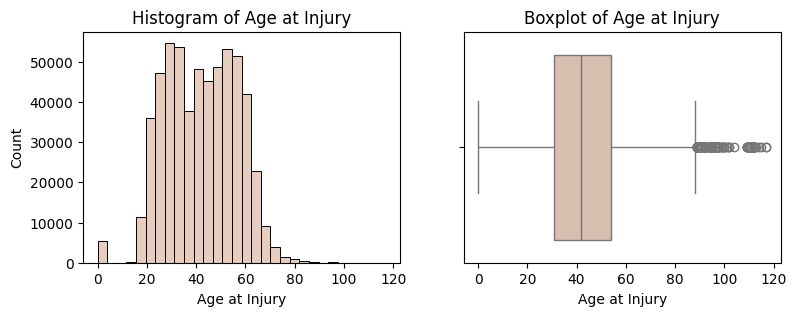

Skew: -0.04057998007326514, Kurtosis : -0.4254860373414626


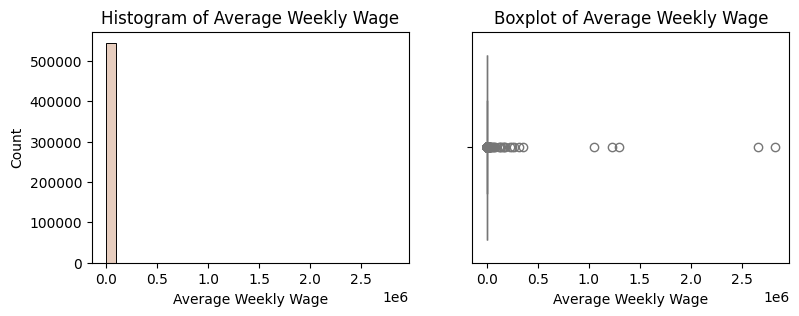

Skew: 378.97927206721073, Kurtosis : 160021.03948371377


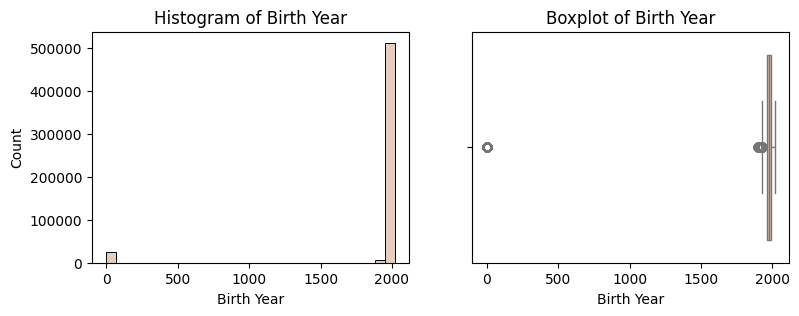

Skew: -4.325518936569755, Kurtosis : 16.734258179111944


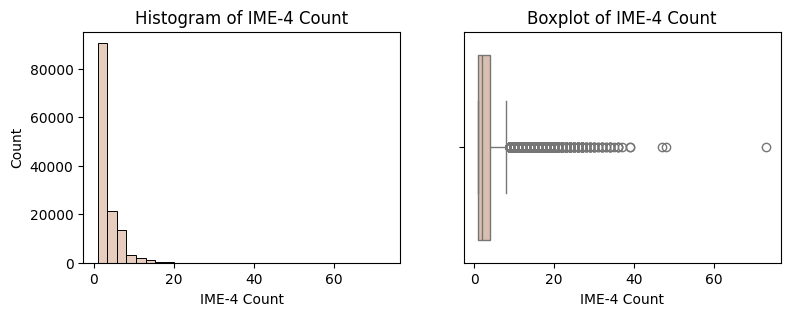

Skew: 2.5946157191216552, Kurtosis : 13.213820614953557


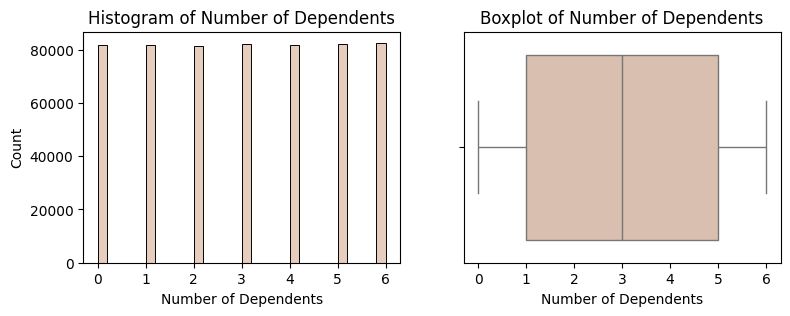

Skew: -0.0035294328499221707, Kurtosis : -1.2503240525925947


In [225]:
for var in numeric_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

    # create histogram
    sns.histplot(ax=ax1, x=numeric_features[var], bins=30, color="#e0bda8")
    ax1.set_title(f"Histogram of {var}")

    # create boxplot
    sns.boxplot(ax=ax2, x=numeric_features[var], color="#e0bda8")
    ax2.set_title(f"Boxplot of {var}")

    plt.show()

    # Print skewness and kurtosis
    print(
        f"Skew: {numeric_features[var].skew()}, Kurtosis : {numeric_features[var].kurt()}"
    )

In [226]:
numeric_features_copy = numeric_features.copy()


# Function to identify outliers based on IQR


def identify_outliers_iqr(df):

    outliers_dict = {}

    for column in df.columns:

        if pd.api.types.is_numeric_dtype(df[column]):  # Check if the column is numeric

            Q1 = df[column].quantile(0.25)

            Q3 = df[column].quantile(0.75)

            IQR = Q3 - Q1

            # Calculate lower and upper bounds

            lower_bound = Q1 - 1.5 * IQR

            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers

            outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

            outliers_dict[column] = outliers

    return outliers_dict


# Identify outliers in the numeric features DataFrame


outliers_found = identify_outliers_iqr(numeric_features_copy)


# Display the number of outliers found for each numeric feature


print("Number of outliers in each numeric feature:")


for column, outliers in outliers_found.items():

    print(f"{column}: {len(outliers)} outliers")

Number of outliers in each numeric feature:
Age at Injury: 197 outliers
Average Weekly Wage: 22257 outliers
Birth Year: 25330 outliers
IME-4 Count: 7169 outliers
Number of Dependents: 0 outliers


## Insights from Numeric Features Analysis

### 1. Extreme Values in Numerical Columns
- **Average Weekly Wage**: The maximum value is **2,828,079**, which seems unusually high compared to the mean of **491.09** and the minimum value basides zero which is 14. This may indicate outliers or data entry errors. One possibility is that some entries refer to wage per hour, year etc.
- **Claim Identifier**: The mean is very high at **23,667,598.79** with a maximum value of **999,891,667.0**, which could suggest an issue with how these identifiers are generated or logged. This high variability may require further examination.

### 2. Data Incoherencies
- **Birth Year**: The mean birth year is 1732, with a minimum of 0 and a maximum of 2018. This appears anomalous, suggesting potential errors in the data entry for birth years.
- **Age at Injury**: Age at injuty has a range from 0 to 117 years, suggesting errors.

### 3. Missing Values
- **Average Weekly Wage**: Average Weekly Wage has 48096 missing values, which account for 8% of the data, suggesting they should be handled. No other numeric variables have missing values.

### 4. Outliers
- All numeric variables, except for `Number of Dependents`, contain a large amount of outliers. 

## Recommendations
- **Further Analyze Relationships**: For example: Investigate relationships between Age, Weekly Wage, and Number of Dependents (it may be interesting to see if younger individuals tend to have lower wages or fewer dependents); Investigate the relatioship between Birth Year and Age at Injury (could we drop one?)
- **Outlier Handling**: Outliers should be investigated to determine if they are legitimate data points or errors. For variables such as IME-4 Count and Average Weekly Wage caping should be considered.
- **Missing values**: For variables with a lot of missing values, such as **Average Weekly Wage**, look for relationships, for example, with age.

# <span style="color:#e0bda8">6. Bivariate Analysis</span>

## Pairwise Relation for Numerical Variables with Target Variable

In [227]:
def histograms_numeric_target(target_variable, variable2):
    fig, ax = plt.subplots(1, 8, figsize=(30, 3))

    for i, cat in enumerate(df[target_variable].value_counts().index):
        viz_df = df[df[target_variable] == cat]
        sns.histplot(viz_df[variable2], ax=ax[i], color="#e0bda8")
        ax[i].set_title(cat)

#### Note: The U.S. Department of Labor refers that, according to the Fair Labor Standards Act (FLSA), the minimum age for employment is 14 years for non-agricultural jobs. Given that the data refers to the time period between the start of 2020 until the end of 2022, we determined the smallest legal Birth Year should be 2008 (2022 - 14). That was taken into account in the visualizations for Age at Injury and Birth Year, considering we are dealing with workplace injuries. In addition to that, considering these are work related claims and the average retirement age in america is 62 years, we considered a maximum fo 80 years.

### Histogram of the Pairwise Relation Between Age at Injury and Claim Injury Type 

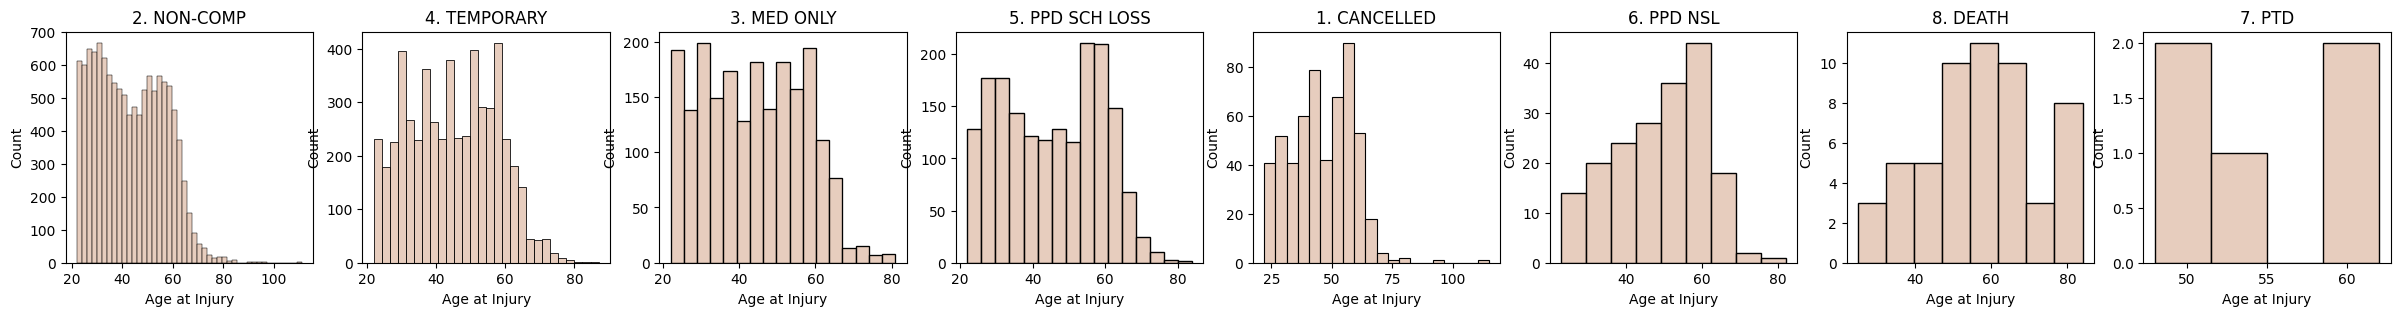

In [228]:
a = df[(df["Age at Injury"] > 21) & (df["Birth Year"] < 80)]

fig, ax = plt.subplots(1, 8, figsize=(30, 3))

for i, cat in enumerate(df["Claim Injury Type"].value_counts().index):
    viz_df = a[a["Claim Injury Type"] == cat]
    sns.histplot(viz_df["Age at Injury"], ax=ax[i], color="#e0bda8")
    ax[i].set_title(cat)

### Histogram of the Pairwise Relation Between Birth Year and Claim Injury Type

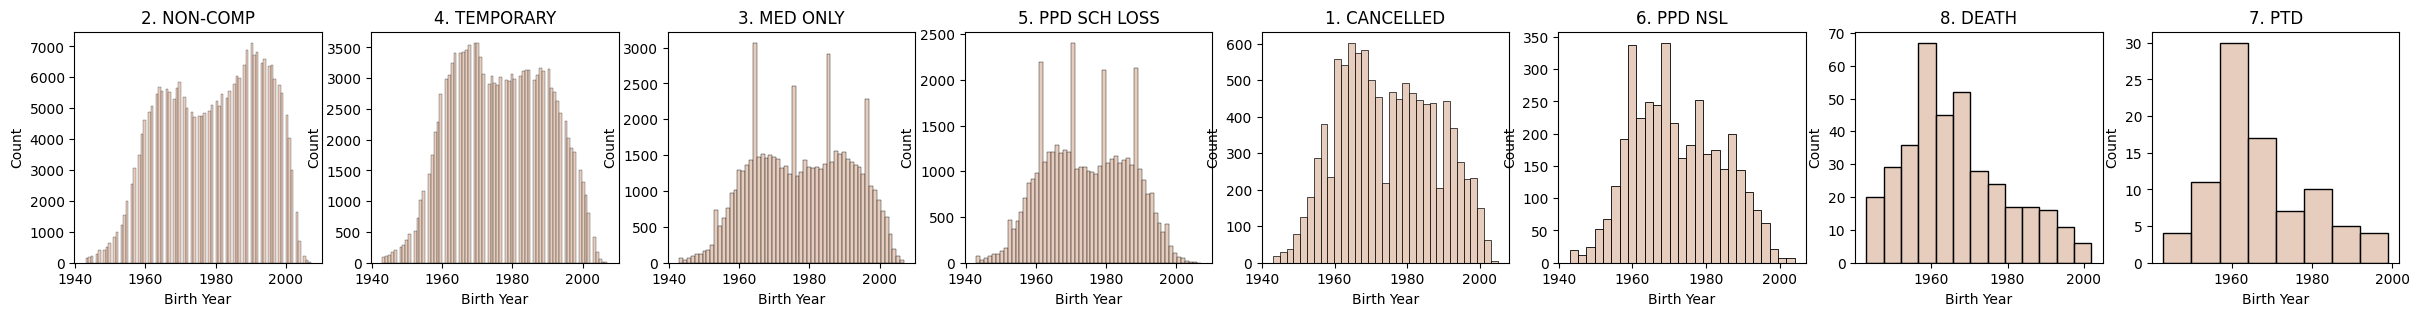

In [229]:
a = df[(df["Birth Year"] < 2008) & (df["Birth Year"] > 1942)]

fig, ax = plt.subplots(1, 8, figsize=(30, 3))

for i, cat in enumerate(df["Claim Injury Type"].value_counts().index):
    viz_df = a[a["Claim Injury Type"] == cat]
    sns.histplot(viz_df["Birth Year"], ax=ax[i], color="#e0bda8")
    ax[i].set_title(cat)

### Histogram of the Pairwise Relation Between Average Weekly Wage and Claim Injury Type

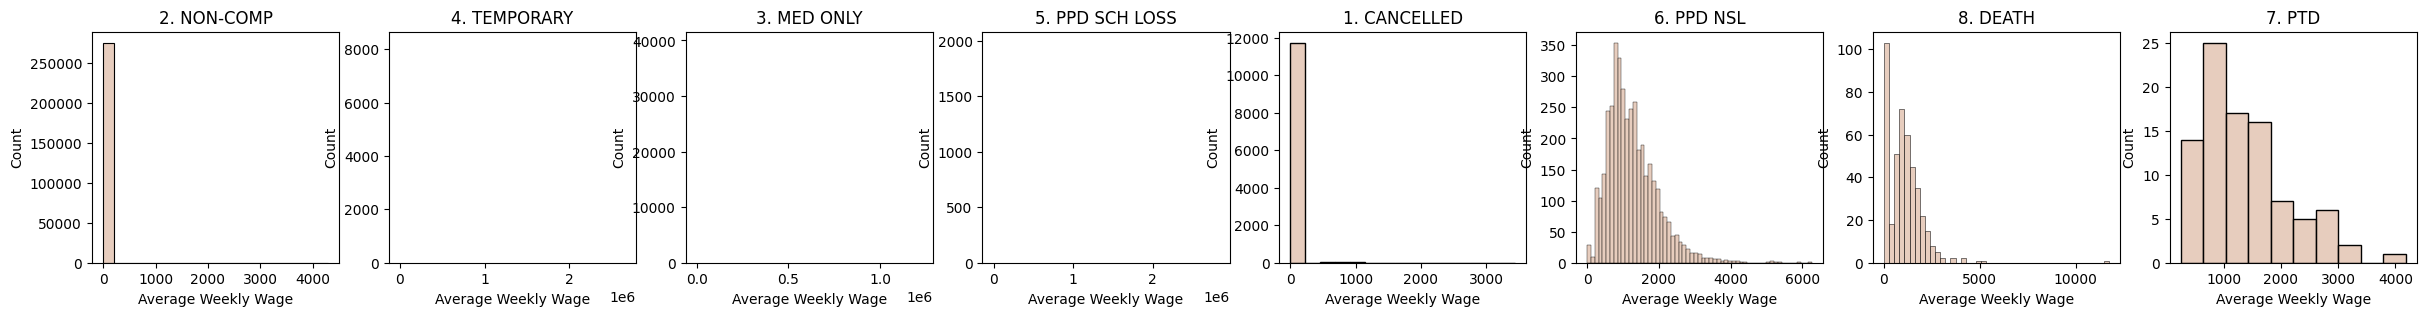

In [230]:
histograms_numeric_target("Claim Injury Type", "Average Weekly Wage")

### Histogram of the Pairwise Relation Between IME-4 Count and Claim Injury Type

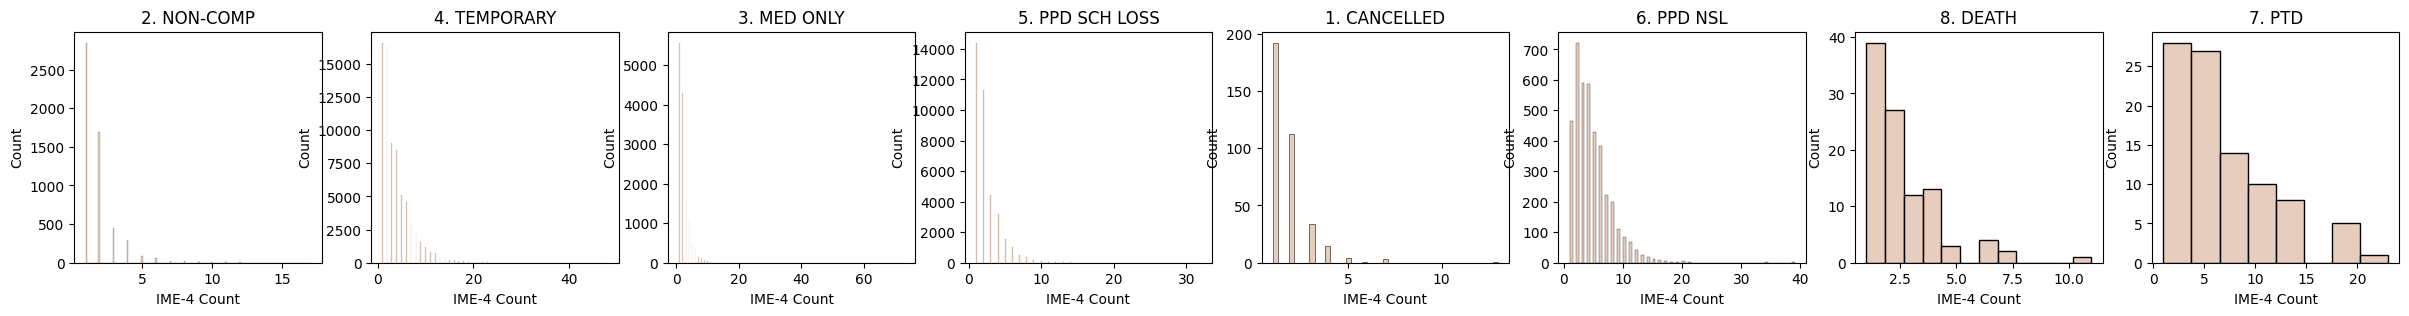

In [231]:
histograms_numeric_target("Claim Injury Type", "IME-4 Count")

### Histogram of the Pairwise Relation Between Number of Dependents and Claim Injury Type

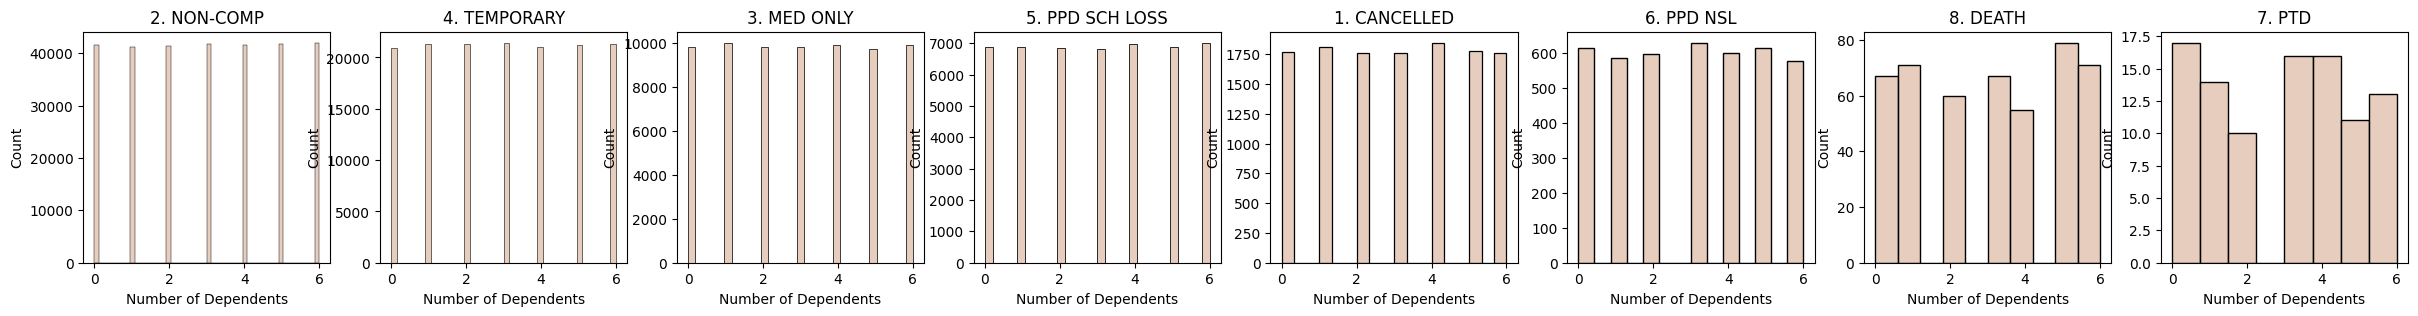

In [232]:
histograms_numeric_target("Claim Injury Type", "Number of Dependents")

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_boxplot(target_var, numeric_var):

    global df  # Referencing the global DataFrame df directly

    # Calculate the count and percentage of each category in the target variable
    target_counts = df[target_var].value_counts()
    total_observations = len(df)
    target_percentages = (target_counts / total_observations) * 100

    # Create a dictionary for quick lookup of each category's percentage
    percentage_labels = {
        category: f"{category} ({perc:.1f}%)"
        for category, perc in zip(target_counts.index, target_percentages)
    }

    # Create the box plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(
        data=df,
        x=target_var,
        y=numeric_var,
        hue=target_var,  # Assign target variable to hue
        palette="RdYlBu",
        dodge=False,  # Avoid duplicate legends
    )

    # Set the title and labels
    plt.title(f"Distribution of {numeric_var} by {target_var}")
    plt.xlabel(target_var)
    plt.ylabel(numeric_var)

    # Set tick labels with percentages
    plt.xticks(
        ticks=range(len(target_counts)),
        labels=[percentage_labels[category] for category in target_counts.index],
        rotation=45,
    )

    # Show the plot
    plt.tight_layout()
    plt.show()

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_boxplot(target_var, numeric_var):
    global df  # Referencing the global DataFrame df directly

    # Calculate the count and percentage of each category in the target variable
    target_counts = df[target_var].value_counts()
    total_observations = len(df)
    target_percentages = (target_counts / total_observations) * 100

    # Create a dictionary for quick lookup of each category's percentage
    percentage_labels = {
        category: f"{category} ({perc:.1f}%)"
        for category, perc in zip(target_counts.index, target_percentages)
    }

    # Create the box plot (horizontal boxplot)
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=df,
        x=numeric_var,  # Make the boxplot horizontal (numeric variable on x-axis)
        y=target_var,  # Target variable on y-axis
        hue=target_var,  # Assign target variable to hue
        palette="RdYlBu",
        dodge=False,  # Avoid duplicate legends
    )

    # Set the title and labels
    plt.title(f"Distribution of {numeric_var} by {target_var}")
    plt.xlabel(numeric_var)
    plt.ylabel(target_var)

    # Set tick labels with percentages
    plt.yticks(
        ticks=range(len(target_counts)),
        labels=[percentage_labels[category] for category in target_counts.index],
        rotation=0,  # No need to rotate y-axis labels
    )

    # Move the color legend outside the plot
    plt.legend(title=target_var, bbox_to_anchor=(1.05, 1), loc="upper left")

    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()

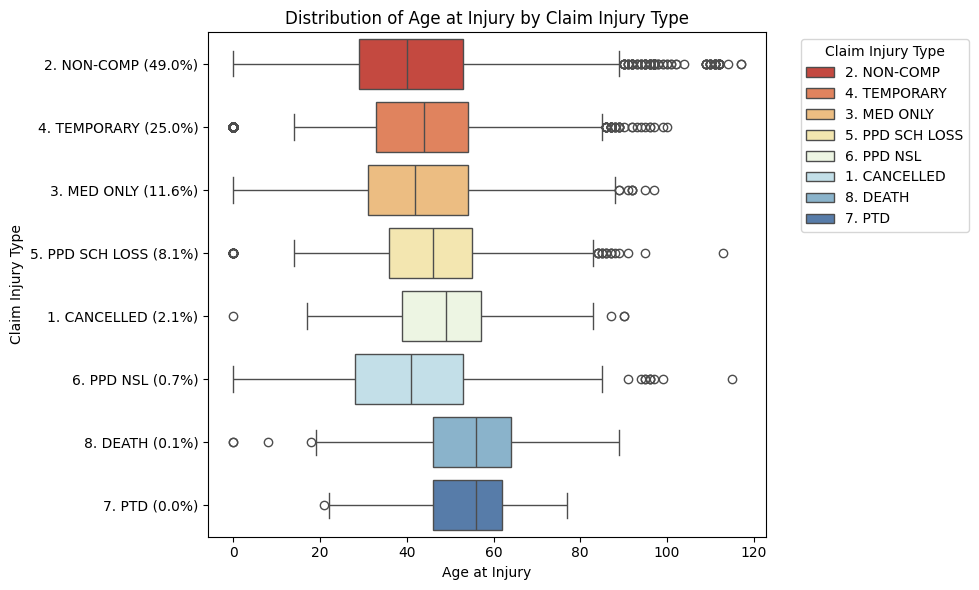

In [235]:
plot_boxplot("Claim Injury Type", "Age at Injury")

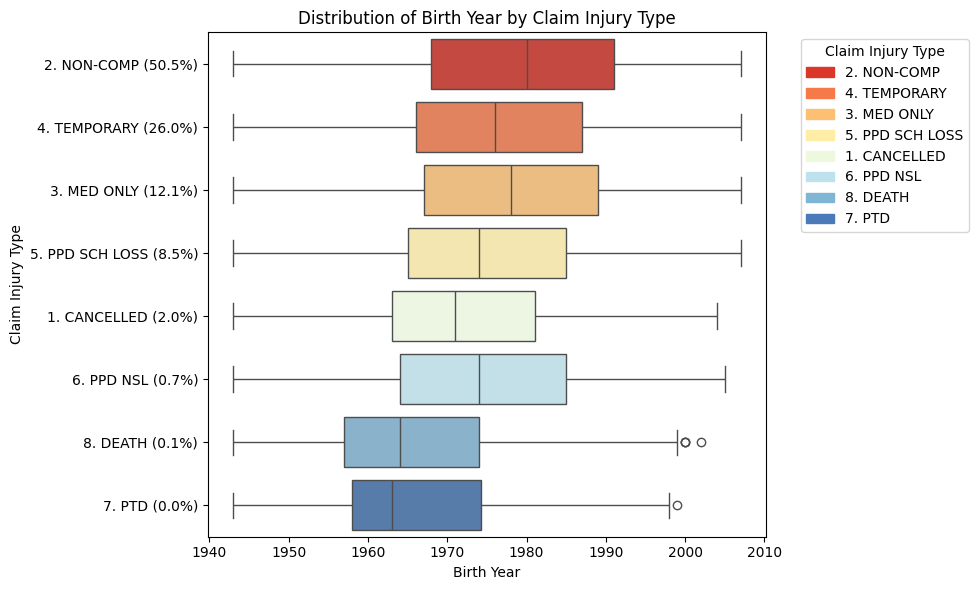

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Filter data
df_sliced = df[(df["Birth Year"] < 2008) & (df["Birth Year"] > 1942)]

# Calculate the count and percentage of each category in the target variable
target_counts = df_sliced["Claim Injury Type"].value_counts()
total_observations = len(df_sliced)
target_percentages = (target_counts / total_observations) * 100

# Create a dictionary for quick lookup of each category's percentage
percentage_labels = {
    category: f"{category} ({perc:.1f}%)"
    for category, perc in zip(target_counts.index, target_percentages)
}

# Define a color palette
palette = sns.color_palette("RdYlBu", n_colors=len(target_counts))

# Create the box plot without hue
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_sliced,
    x="Birth Year",
    y="Claim Injury Type",
    hue="Claim Injury Type",
    palette=palette,  # Apply palette directly without hue
)

# Set the title and labels
plt.title("Distribution of Birth Year by Claim Injury Type")
plt.xlabel("Birth Year")
plt.ylabel("Claim Injury Type")

# Annotate y-axis labels with percentages
plt.yticks(
    ticks=range(len(target_counts)),
    labels=[percentage_labels[category] for category in target_counts.index],
)

# Manually create legend
legend_patches = [
    mpatches.Patch(color=palette[i], label=category)
    for i, category in enumerate(target_counts.index)
]
plt.legend(
    handles=legend_patches,
    title="Claim Injury Type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

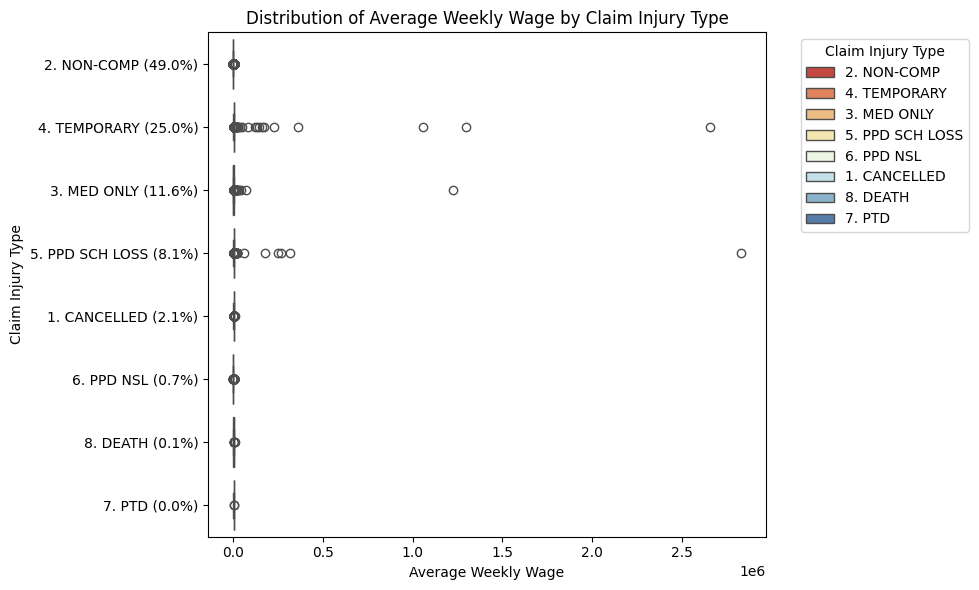

In [237]:
plot_boxplot("Claim Injury Type", "Average Weekly Wage")

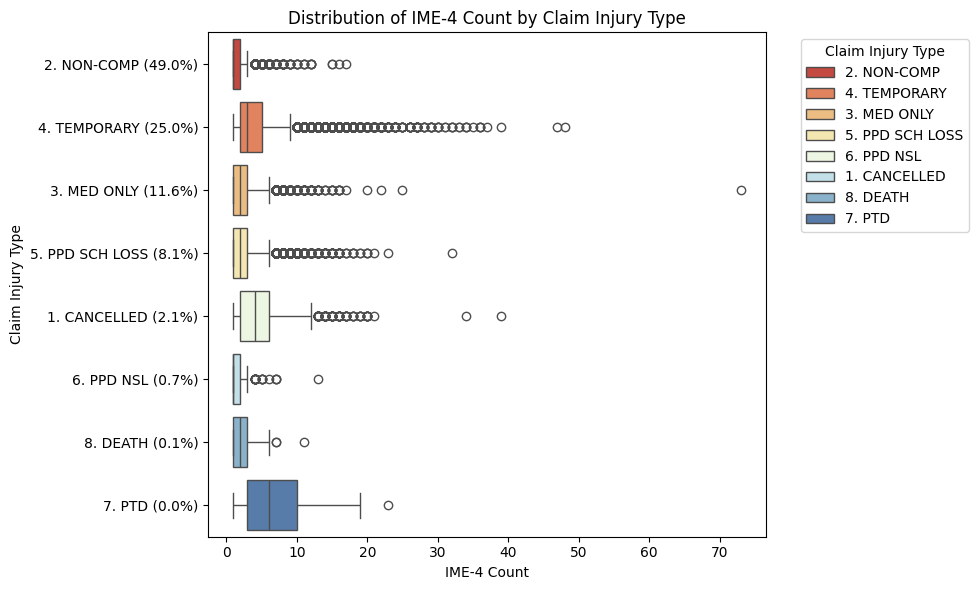

In [238]:
plot_boxplot("Claim Injury Type", "IME-4 Count")

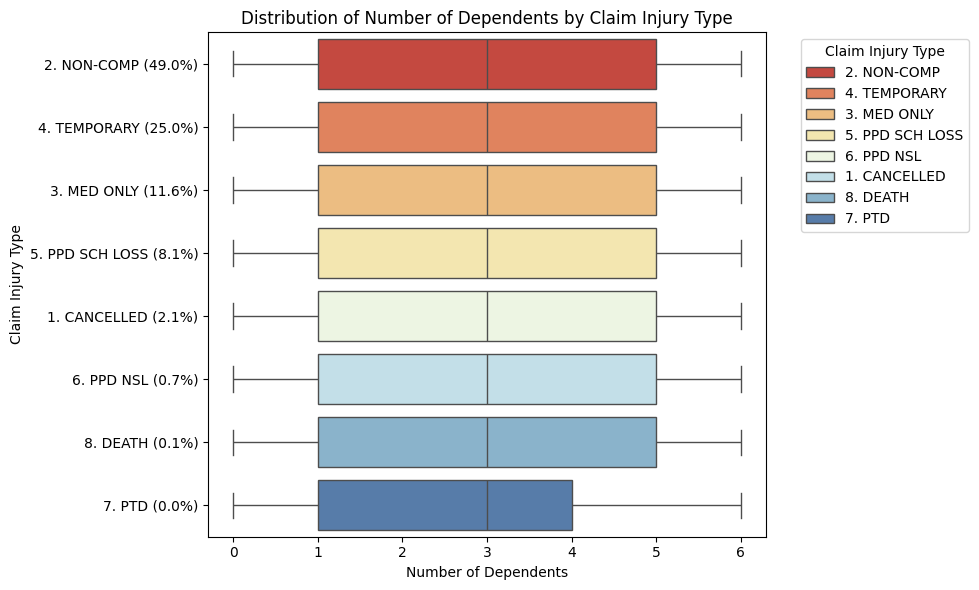

In [239]:
plot_boxplot("Claim Injury Type", "Number of Dependents")

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def plot_normalized_heatmap(target_variable, numeric_variable, figsize=(10, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(
        pd.crosstab(
            df[numeric_variable],
            df[target_variable],
            normalize="columns",
        ),
        annot=True,
        fmt=".1f",
        ax=ax,
    )

    # Set the title and labels
    ax.set_title(f"Normalized Heatmat of {numeric_variable} by {target_variable}")
    ax.set_xlabel(target_variable)
    ax.set_ylabel(numeric_variable)

    plt.tight_layout()
    plt.show()

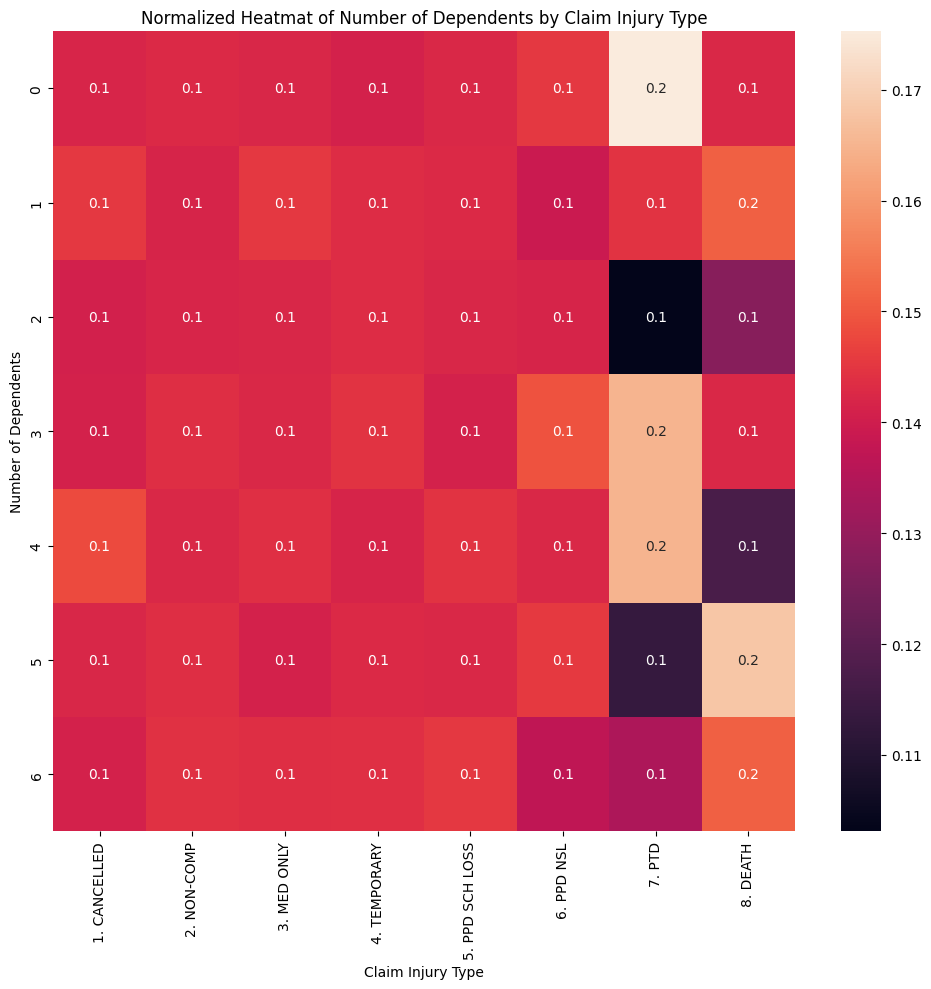

In [241]:
plot_normalized_heatmap("Claim Injury Type", "Number of Dependents")

## Pairwise Relation of Numerical Variables

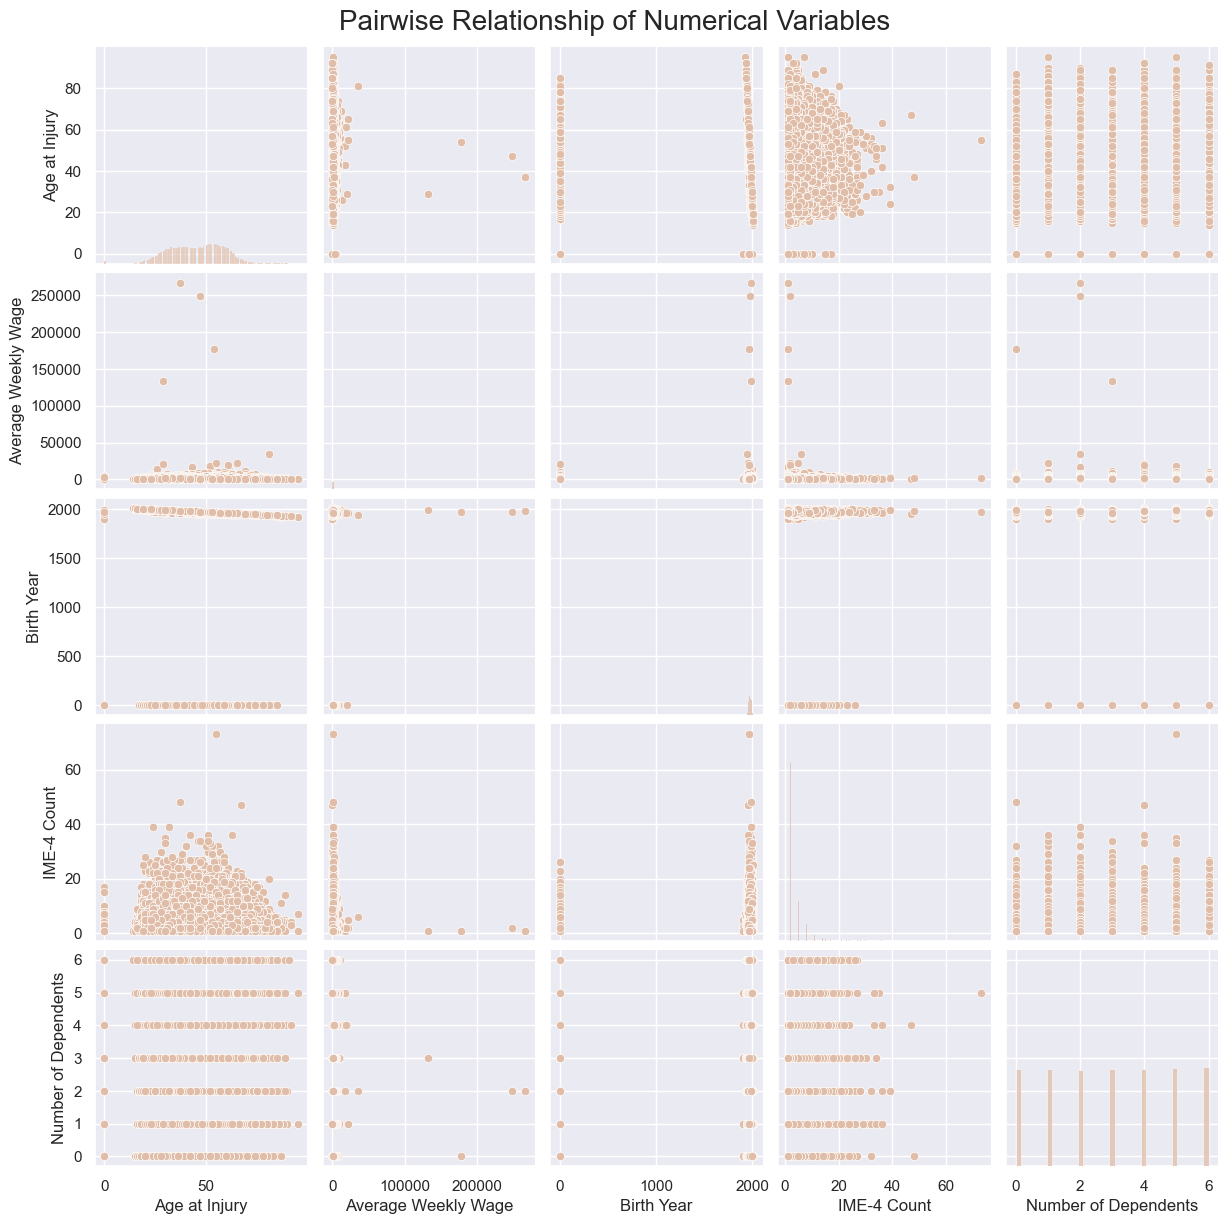

In [242]:
# Setting Seaborn style
sns.set()

# Create the pairplot, dropping NAs to not encounter errors
pair_plot = sns.pairplot(
    df[numeric].dropna(),
    diag_kind="hist",
    plot_kws={"color": "#e0bda8"},
    diag_kws={"color": "#e0bda8"},
)

# Adjust layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

## Correlation Matrix Numeric Variables

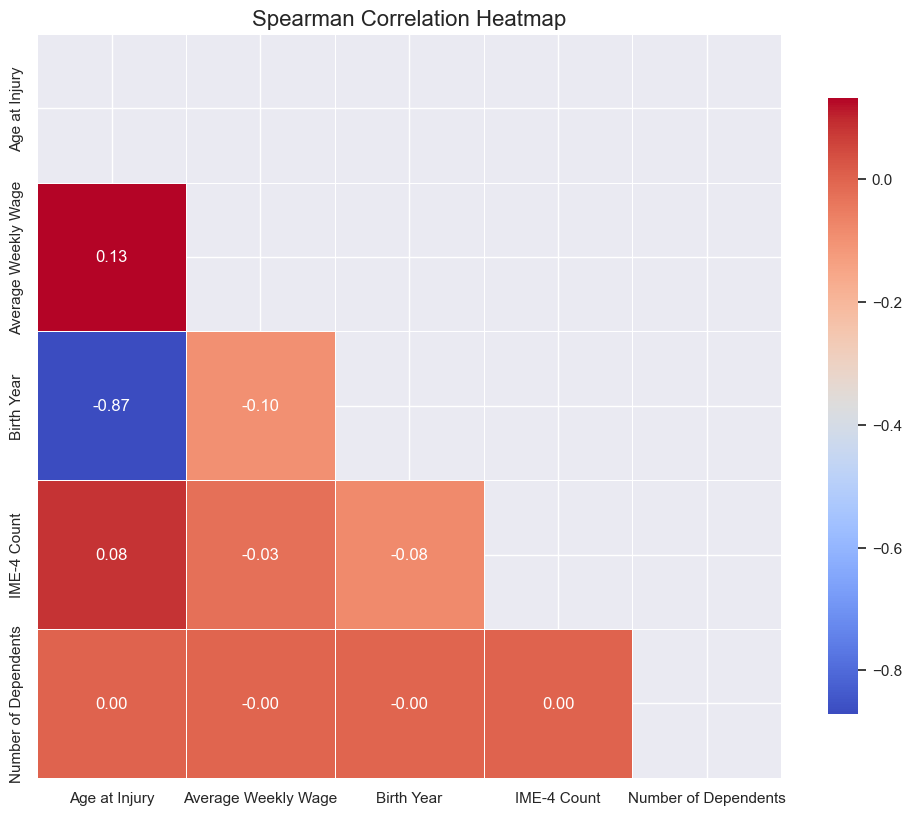

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Obtain the Spearman correlation matrix
cor_spearman = numeric_features.corr(method="spearman")

# Create a mask for the upper triangle (if you want to hide it)
mask = np.triu(np.ones_like(cor_spearman, dtype=bool))

# Define a custom colormap (you can modify the colors as needed)
custom_cmap = sns.color_palette(
    "coolwarm", as_cmap=True
)  # Change to your preferred colormap

# Optionally, define whether to annotate or not
annot = True  # Set to True to show the correlation coefficients

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data=cor_spearman,
    annot=annot,
    cmap=custom_cmap,
    mask=mask,
    fmt=".2f",  # Format for the annotation, use '.2f' for float
    square=True,  # Keep cells square
    linewidths=0.5,  # Add lines between cells for clarity
    cbar_kws={"shrink": 0.8},
)  # Adjust the colorbar size

# Add title
plt.title("Spearman Correlation Heatmap", fontsize=16)

# Show the heatmap
plt.show()

## Pairwise Relation for Categorical Variables with Target Variable

In [244]:
import matplotlib.pyplot as plt


def plot_categorical_target_relation_vertical(categorical_var, target_var):

    # Calculate the percentage of missing values in the categorical variable

    missing_percentage = df[categorical_var].isna().mean() * 100

    # Create a copy of the DataFrame for manipulation

    df_copy = df.copy()

    # Fill missing values in the categorical variable with a placeholder ("Missing")

    df_copy[categorical_var] = df_copy[categorical_var].fillna("Missing")

    # Fill missing values in the target variable with a placeholder ("Missing")

    df_copy[target_var] = df_copy[target_var].fillna("Missing")

    # Group by categorical_var and target_var, count occurrences

    count_data = (
        df_copy.groupby([categorical_var, target_var], observed=False)
        .size()
        .unstack(fill_value=0)
    )

    # Calculate percentages for each group

    percent_data = count_data.apply(lambda x: x / x.sum() * 100, axis=1)

    # Reindex the data to ensure "Missing" is last

    categories = df_copy[categorical_var].unique()

    target_categories = df_copy[target_var].unique()

    # Create a sorted list for both categories

    sorted_categories = [cat for cat in categories if cat != "Missing"] + ["Missing"]

    sorted_target_categories = [
        cat for cat in target_categories if cat != "Missing"
    ] + ["Missing"]

    # Reindex the data to ensure "Missing" is at the end

    count_data = count_data.reindex(sorted_categories, axis=0, fill_value=0)

    count_data = count_data.reindex(sorted_target_categories, axis=1, fill_value=0)

    percent_data = percent_data.reindex(sorted_categories, axis=0, fill_value=0)

    percent_data = percent_data.reindex(sorted_target_categories, axis=1, fill_value=0)

    # Plotting the percentage stacked bar plot

    ax = percent_data.plot(kind="bar", stacked=True, figsize=(12, 7), colormap="RdYlBu")

    plt.title(f"Relation between {categorical_var} and {target_var} (percentage)")

    plt.ylabel("Percentage")

    plt.xticks(rotation=0, ha="right")

    # Adding total count on top of each bar

    for i, (index, row) in enumerate(count_data.iterrows()):

        total_count = row.sum()

        cumulative_height = percent_data.loc[
            index
        ].cumsum()  # Calculate cumulative heights for each bar segment

        # Ensure we add text above each bar, accounting for the height

        ax.text(
            i,
            cumulative_height.iloc[-1] + 1,
            f"Total: {int(total_count)}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=10,
        )

    # Display the missing percentage as a label on the plot if any missing values were present

    if missing_percentage > 0:

        plt.figtext(
            0.9,
            0.1,
            f"Missing: {missing_percentage:.2f}%",
            ha="right",
            fontsize=10,
            color="red",
        )

    # Move legend to the side

    plt.legend(title=target_var, loc="center left", bbox_to_anchor=(1, 0.5))

    # Adjust spacing for the x-axis to add empty space beyond 100%

    ax.set_ylim(0, 105)  # Set ylim to provide empty space

    plt.tight_layout(pad=1.0)

    plt.show()

In [245]:
import matplotlib.pyplot as plt


def plot_categorical_target_relation_horizontal(categorical_var, target_var):

    # Calculate the percentage of missing values in the categorical variable

    missing_percentage = df[categorical_var].isna().mean() * 100

    # Create a copy of the DataFrame for manipulation

    df_copy = df.copy()

    # Fill missing values in the categorical variable with a placeholder ("Missing")

    df_copy[categorical_var] = df_copy[categorical_var].fillna("Missing")

    # Fill missing values in the target variable with a placeholder ("Missing")

    df_copy[target_var] = df_copy[target_var].fillna("Missing")

    # Group by categorical_var and target_var, count occurrences

    count_data = (
        df_copy.groupby([categorical_var, target_var], observed=False)
        .size()
        .unstack(fill_value=0)
    )

    # Calculate percentages for each group

    percent_data = count_data.apply(lambda x: x / x.sum() * 100, axis=1)

    # Get unique values for both categorical and target variables

    categories = df_copy[categorical_var].unique()

    target_categories = df_copy[target_var].unique()

    sorted_categories = ["Missing"] + sorted(
        [cat for cat in categories if cat != "Missing"], reverse=True
    )

    sorted_target_categories = sorted(
        [cat for cat in target_categories if cat != "Missing"]
    ) + ["Missing"]

    # Reindex the data to ensure "Missing" is at the end of both axes

    count_data = count_data.reindex(sorted_categories, axis=0, fill_value=0)

    count_data = count_data.reindex(sorted_target_categories, axis=1, fill_value=0)

    percent_data = percent_data.reindex(sorted_categories, axis=0, fill_value=0)

    percent_data = percent_data.reindex(sorted_target_categories, axis=1, fill_value=0)

    # Plotting the percentage stacked bar plot (switching x and y axes)

    ax = percent_data.plot(
        kind="barh", stacked=True, figsize=(12, 7), colormap="RdYlBu"
    )

    plt.title(
        f"Relation between {categorical_var} and {target_var} (percentage)", pad=20
    )

    plt.xlabel("Percentage")

    plt.ylabel(categorical_var)

    # Adding total count on the right side of each bar

    for i, (index, row) in enumerate(count_data.iterrows()):

        total_count = row.sum()

        cumulative_height = percent_data.loc[
            index
        ].cumsum()  # Calculate cumulative heights for each bar segment

        # Ensure we add text at the end of each bar, accounting for the height

        ax.text(
            cumulative_height.iloc[-1] + 1,
            i,
            f"{int(total_count)}",
            ha="left",
            va="center",
            color="black",
            fontsize=10,
        )

    # Display the missing percentage as a label on the plot if any missing values were present

    if missing_percentage > 0:

        plt.figtext(
            0.9,
            0.1,
            f"Missing: {missing_percentage:.2f}%",
            ha="right",
            fontsize=10,
            color="red",
        )

    # Move legend to the side and increase space by adjusting bbox_to_anchor

    plt.legend(
        title=target_var, loc="center left", bbox_to_anchor=(1, 0.5)
    )  # Slight increase in space

    # Adjust spacing for the x-axis to add empty space beyond 100%

    ax.set_xlim(0, 120)  # Set xlim to provide empty space

    plt.tight_layout(pad=1.0)  # padding for more space

    plt.show()

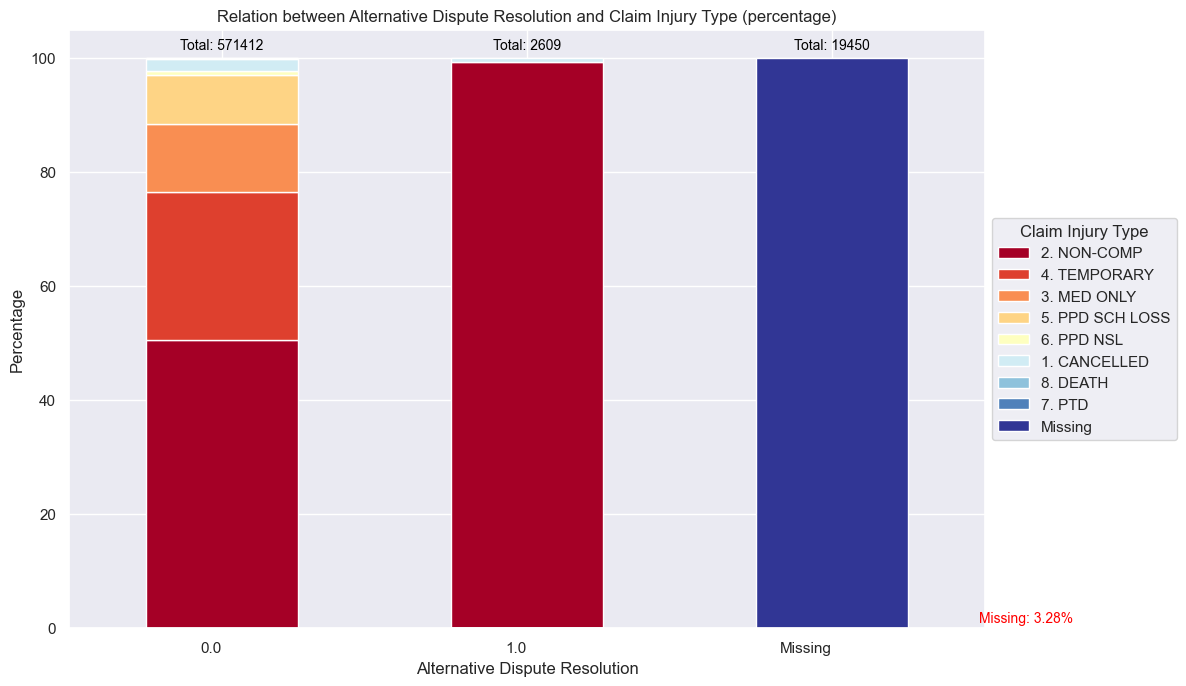

In [246]:
plot_categorical_target_relation_vertical(
    "Alternative Dispute Resolution", "Claim Injury Type"
)

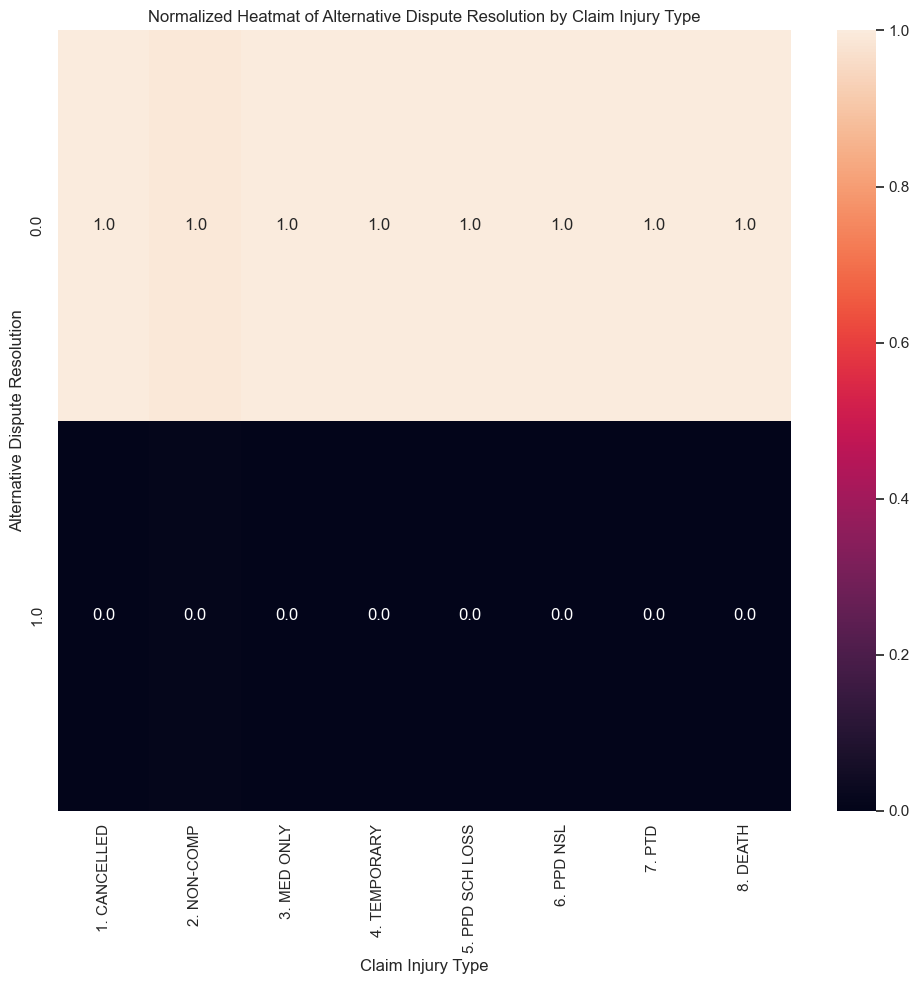

In [247]:
plot_normalized_heatmap("Claim Injury Type", "Alternative Dispute Resolution")

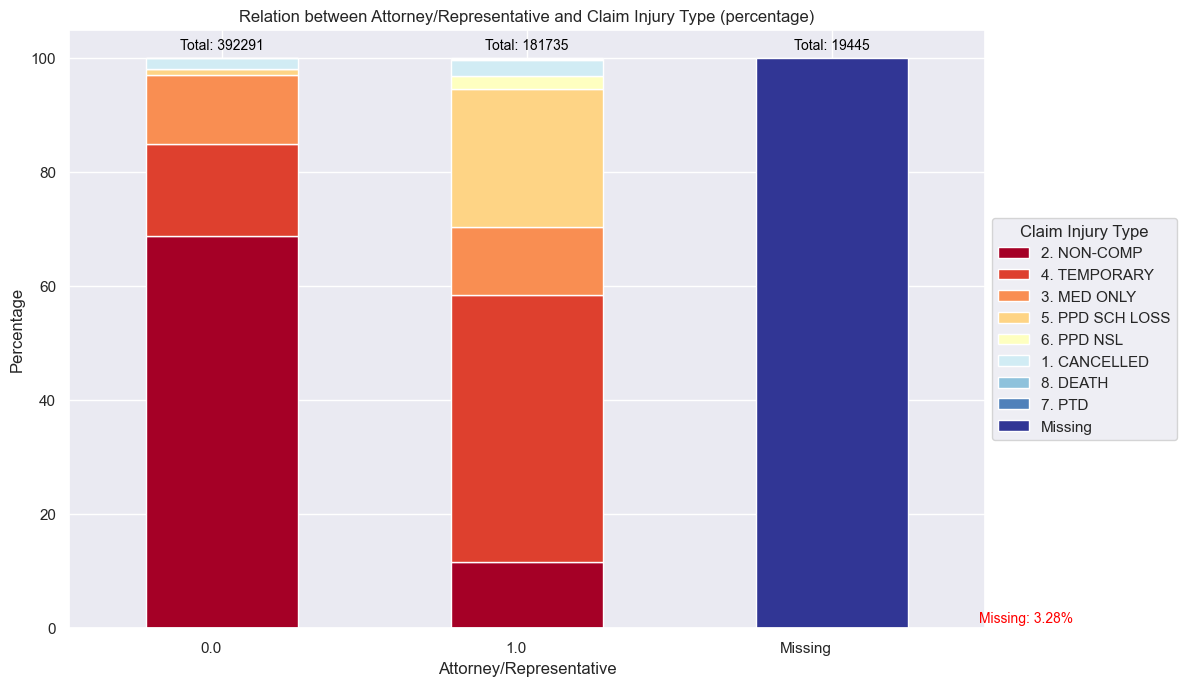

In [248]:
plot_categorical_target_relation_vertical(
    "Attorney/Representative", "Claim Injury Type"
)

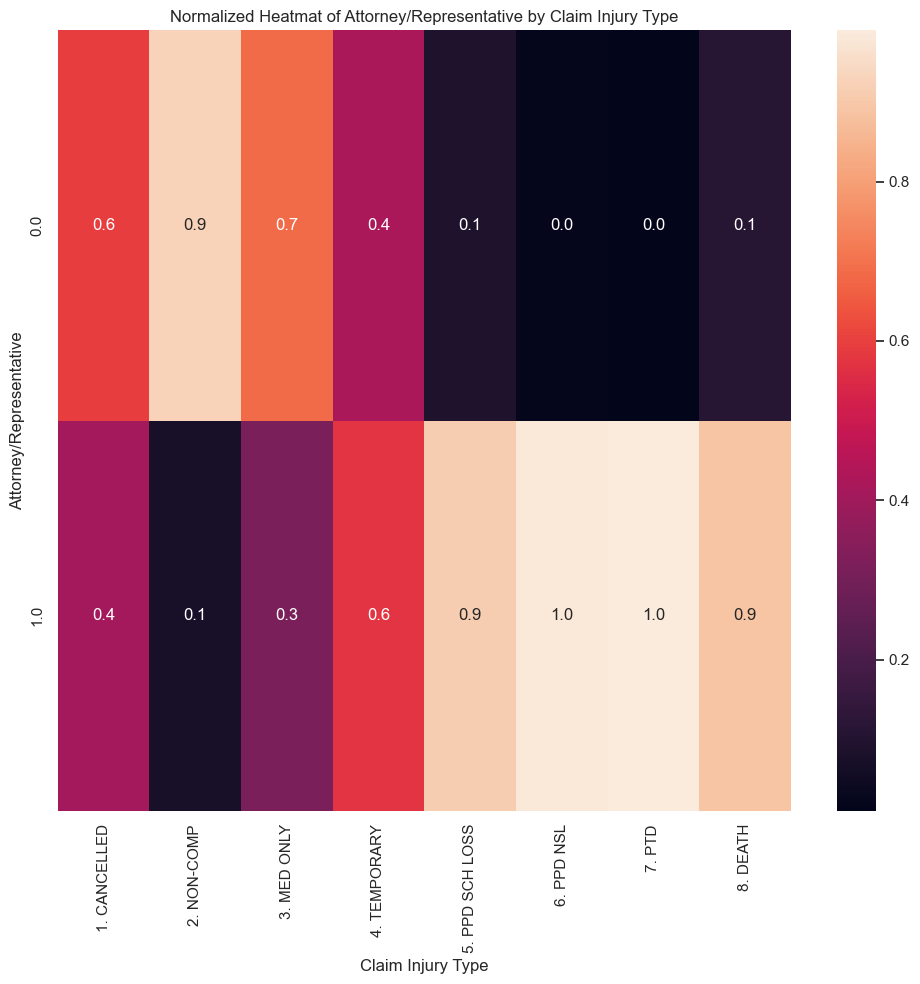

In [249]:
plot_normalized_heatmap("Claim Injury Type", "Attorney/Representative")

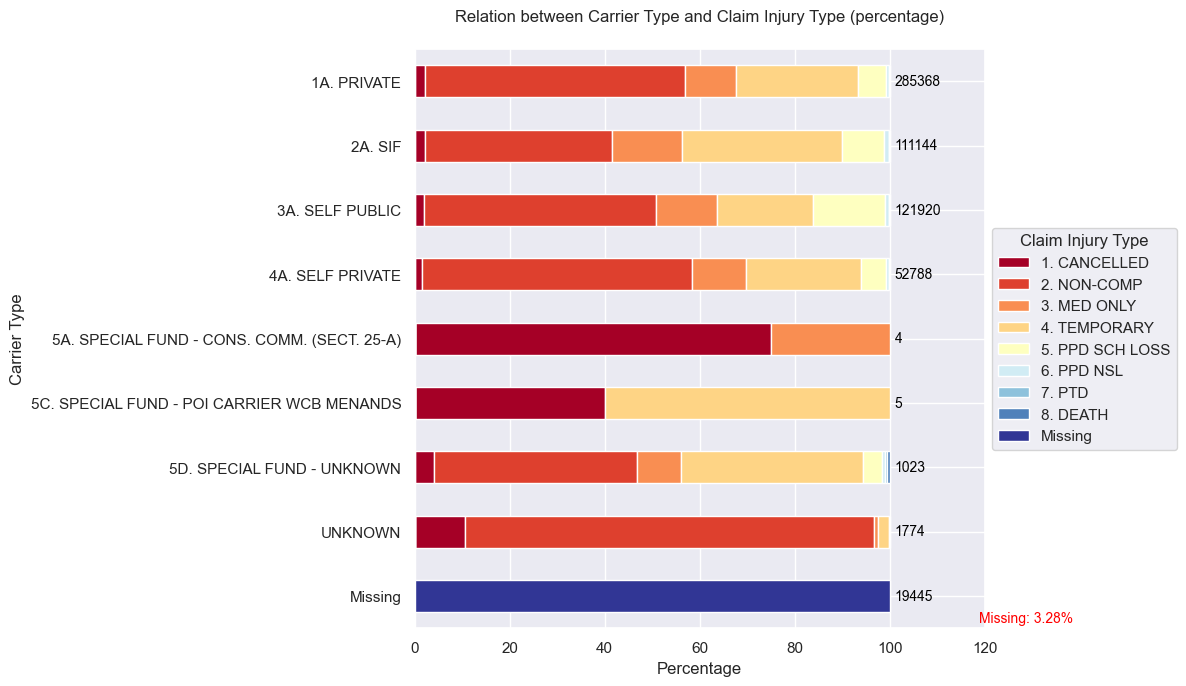

In [250]:
plot_categorical_target_relation_horizontal("Carrier Type", "Claim Injury Type")

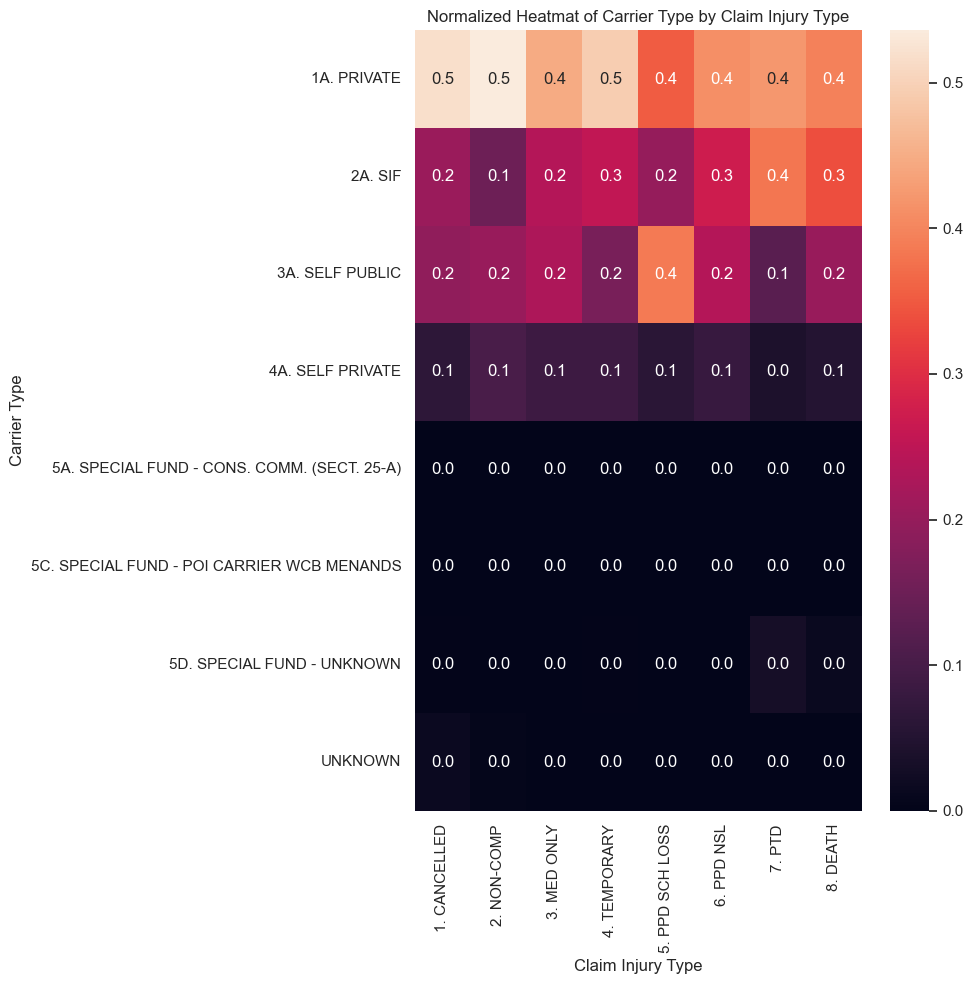

In [251]:
plot_normalized_heatmap("Claim Injury Type", "Carrier Type")

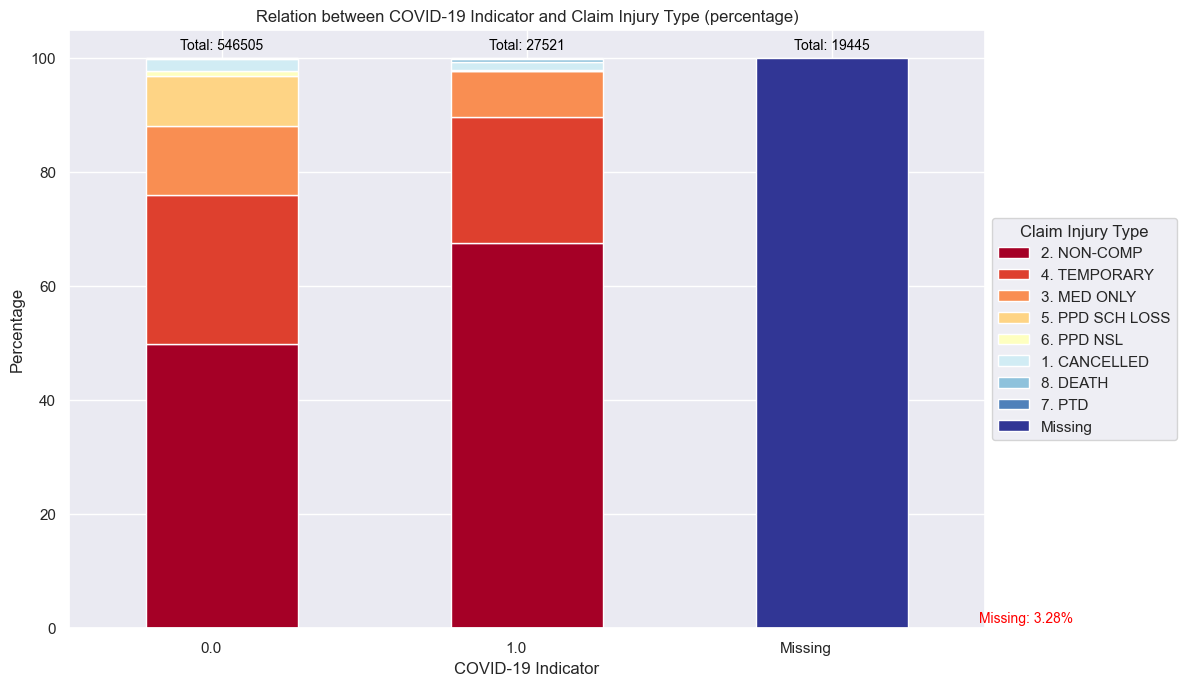

In [252]:
plot_categorical_target_relation_vertical("COVID-19 Indicator", "Claim Injury Type")

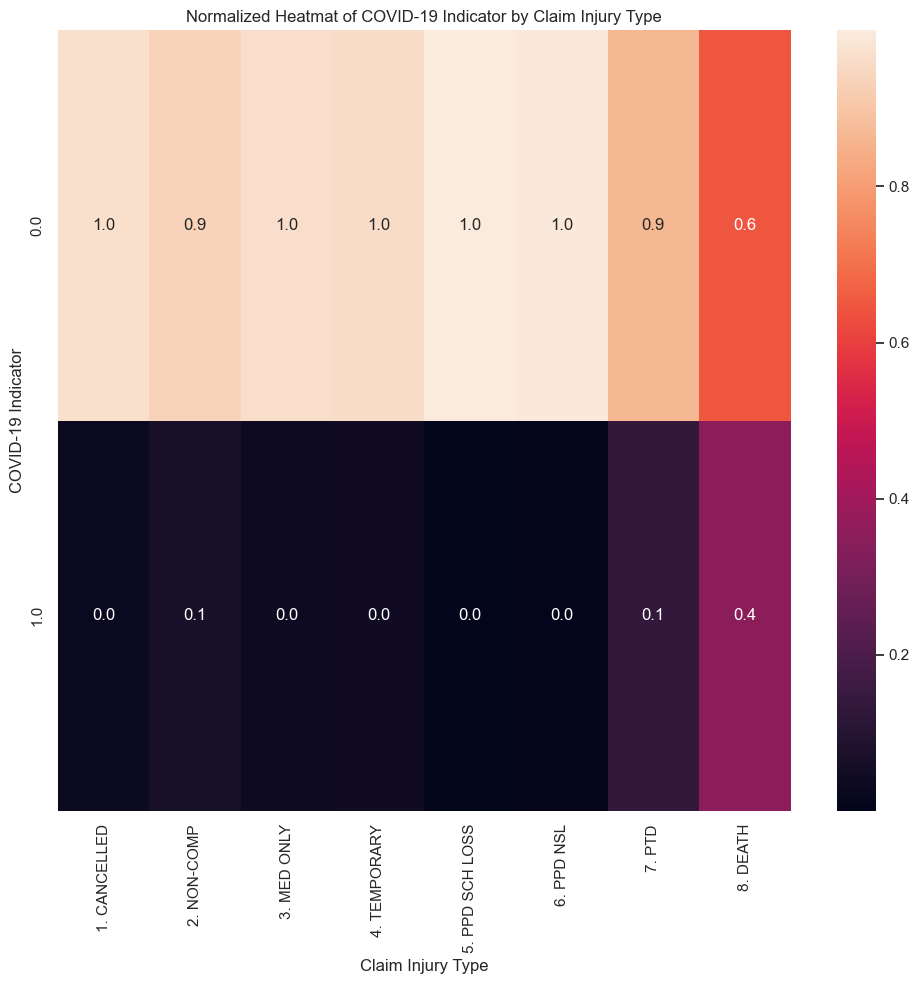

In [253]:
plot_normalized_heatmap("Claim Injury Type", "COVID-19 Indicator")

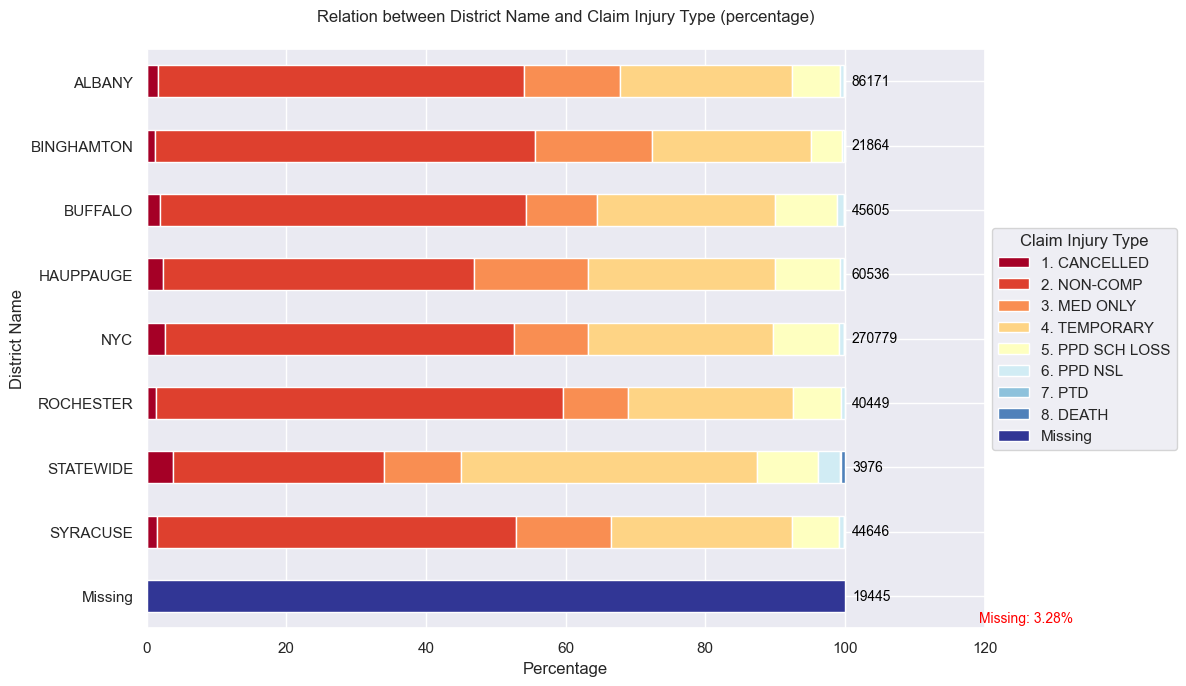

In [254]:
plot_categorical_target_relation_horizontal("District Name", "Claim Injury Type")

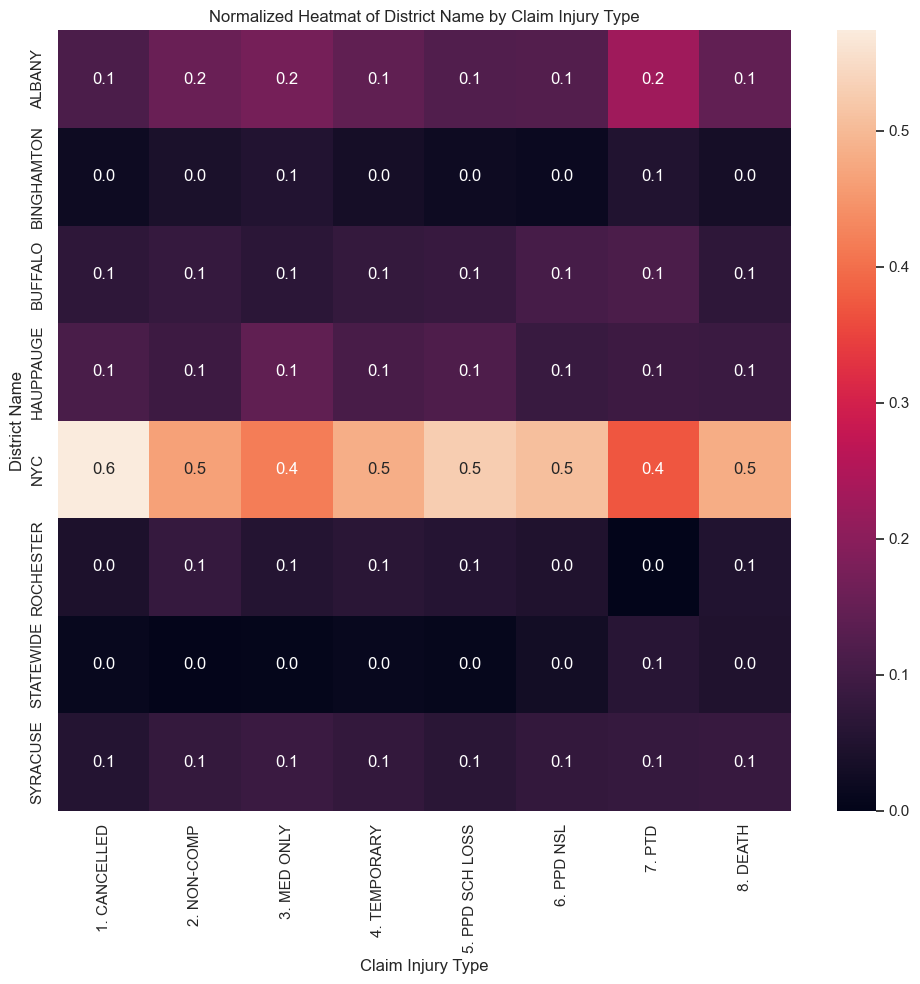

In [255]:
plot_normalized_heatmap("Claim Injury Type", "District Name")

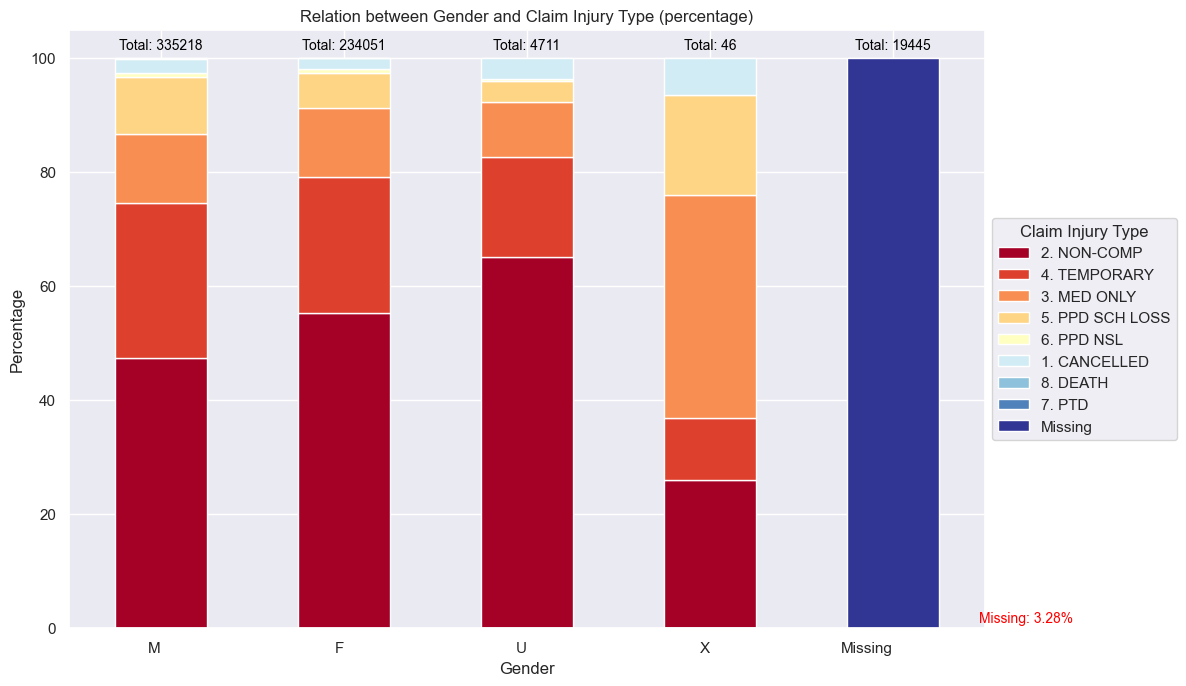

In [256]:
plot_categorical_target_relation_vertical("Gender", "Claim Injury Type")

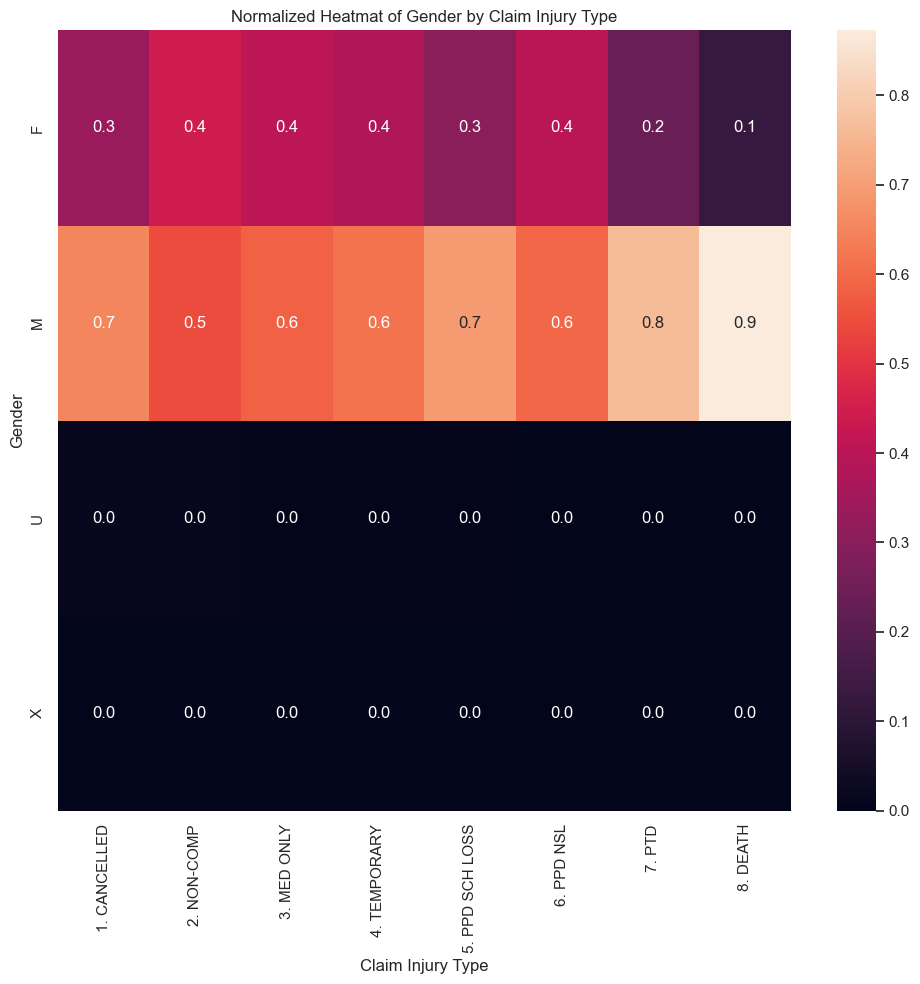

In [257]:
plot_normalized_heatmap("Claim Injury Type", "Gender")

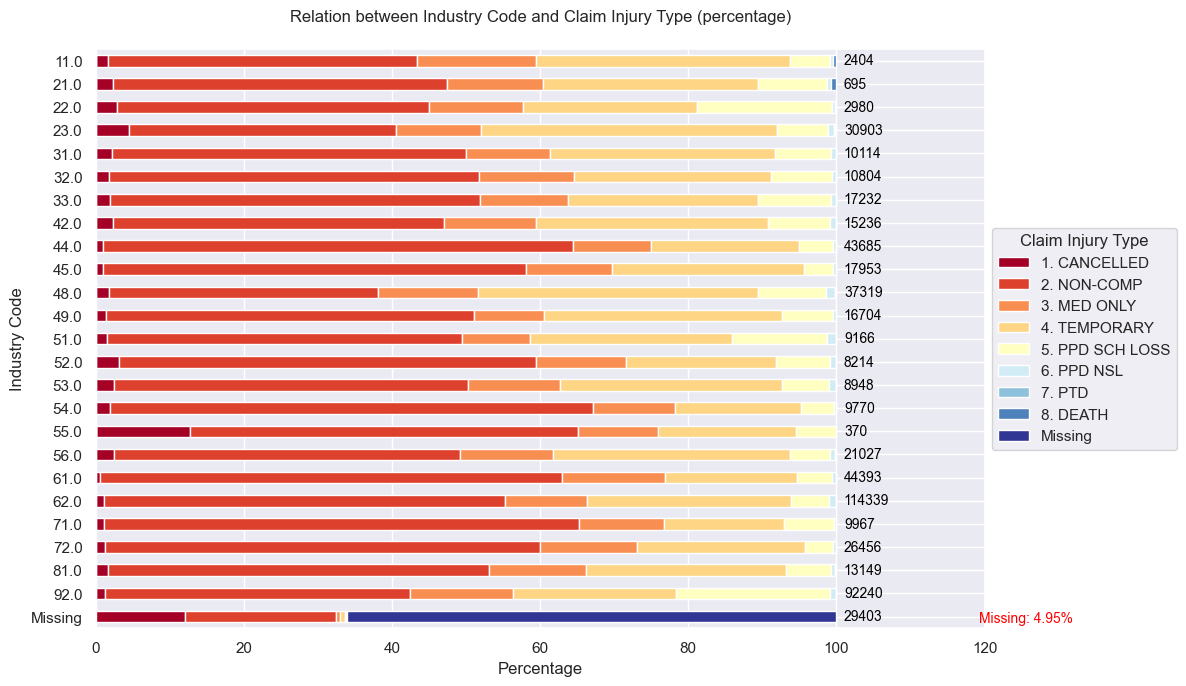

In [258]:
plot_categorical_target_relation_horizontal("Industry Code", "Claim Injury Type")

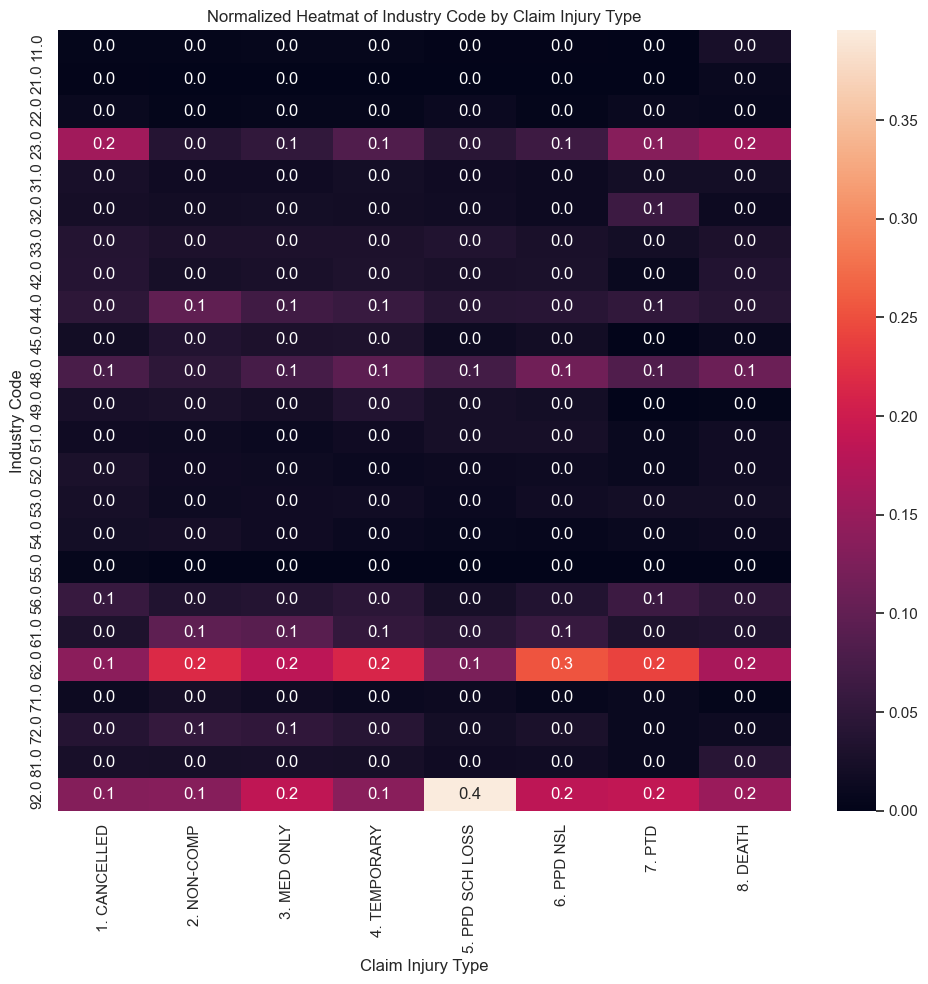

In [259]:
plot_normalized_heatmap("Claim Injury Type", "Industry Code")

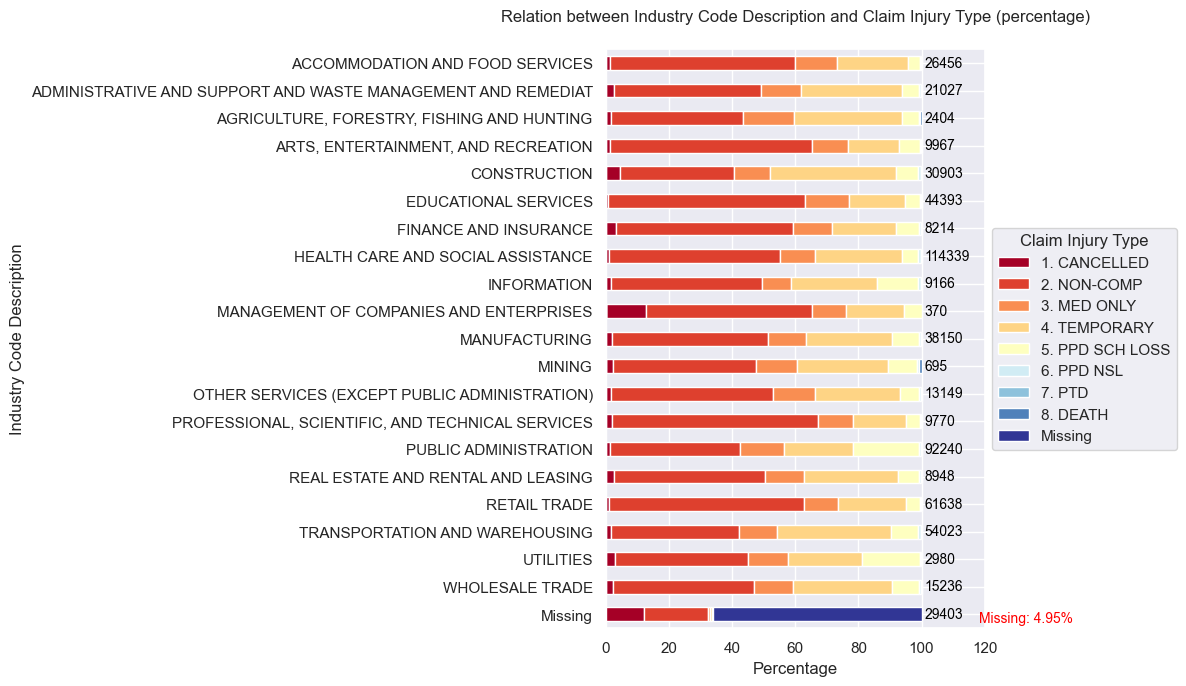

In [260]:
plot_categorical_target_relation_horizontal(
    "Industry Code Description", "Claim Injury Type"
)

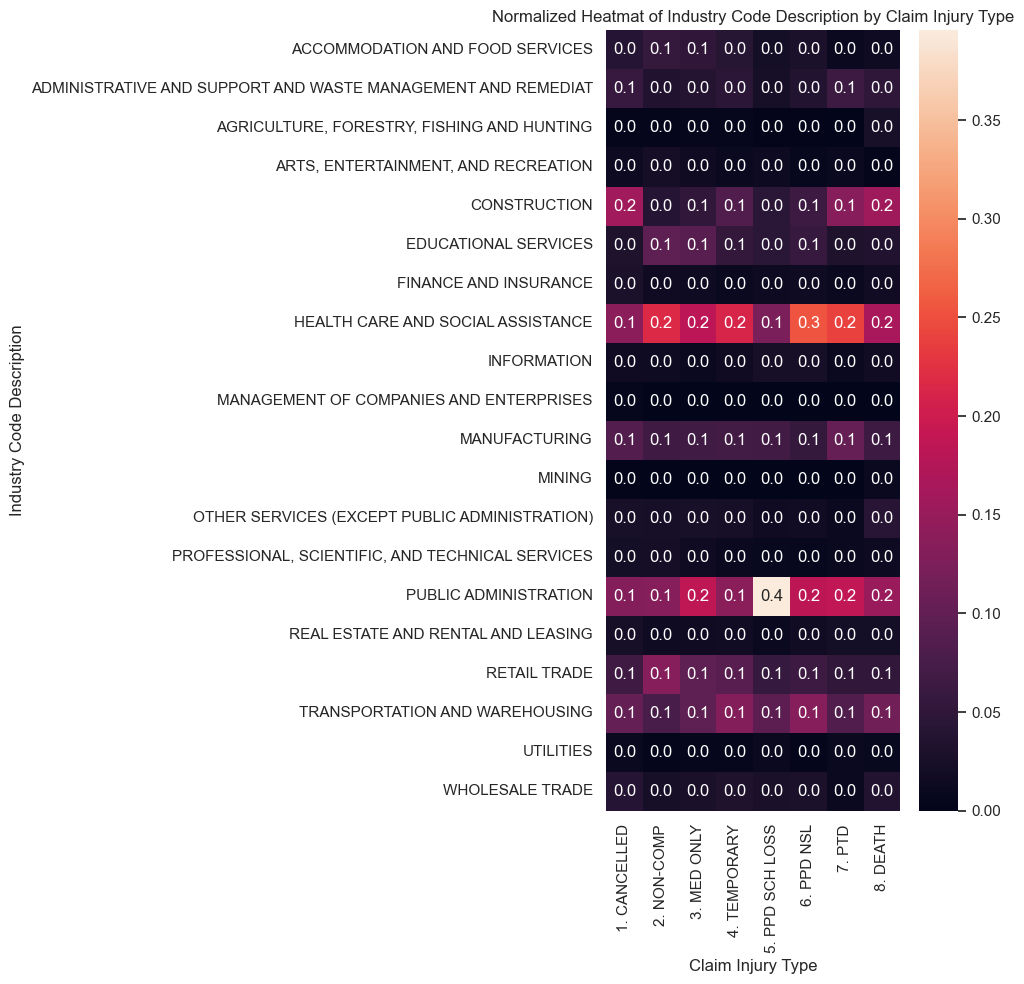

In [261]:
plot_normalized_heatmap("Claim Injury Type", "Industry Code Description")

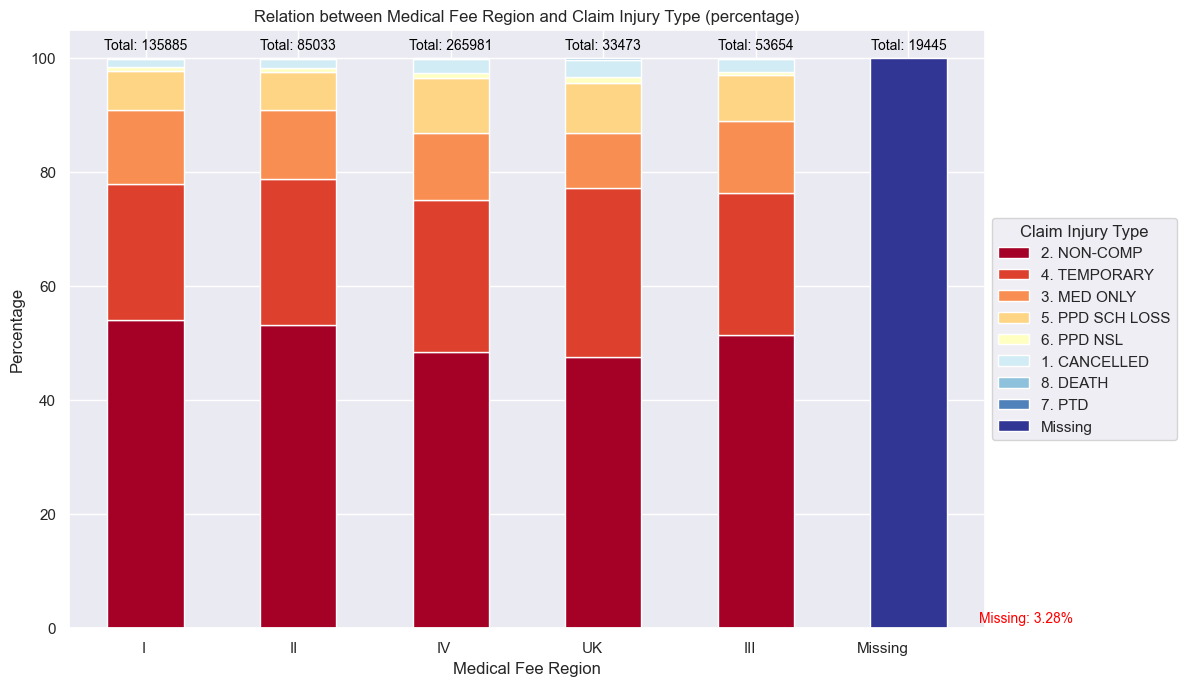

In [262]:
plot_categorical_target_relation_vertical("Medical Fee Region", "Claim Injury Type")

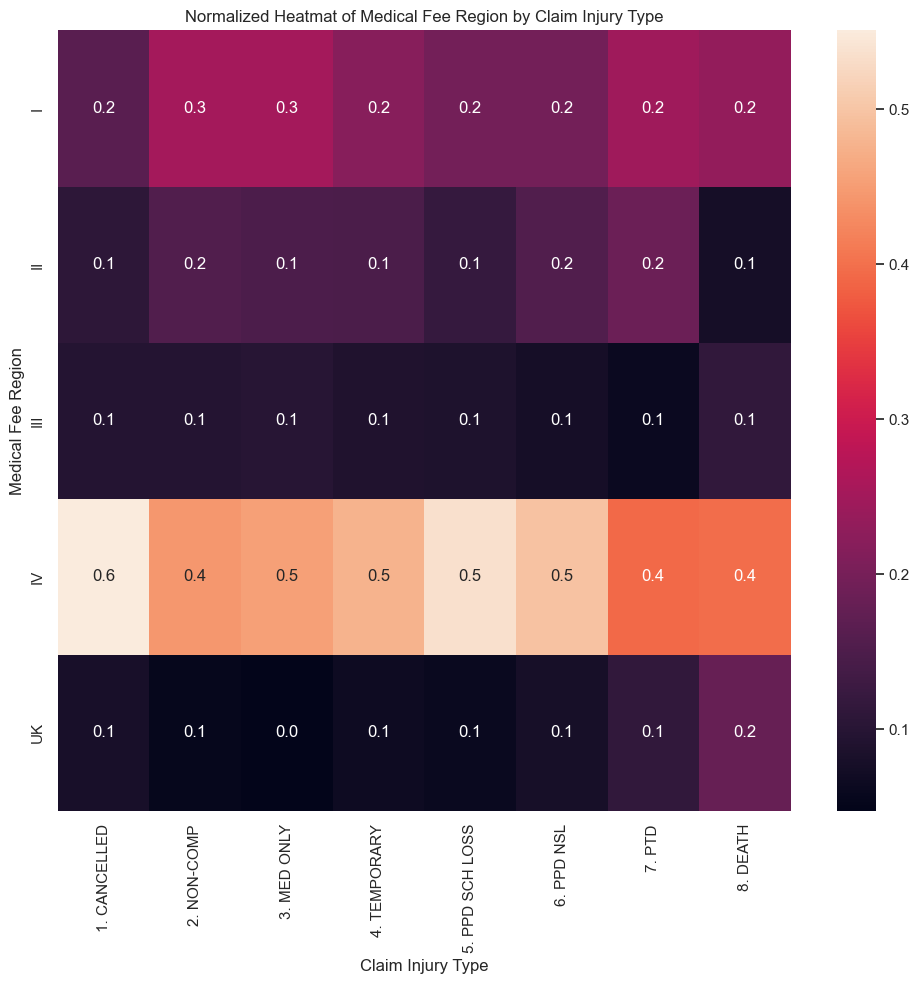

In [263]:
plot_normalized_heatmap("Claim Injury Type", "Medical Fee Region")

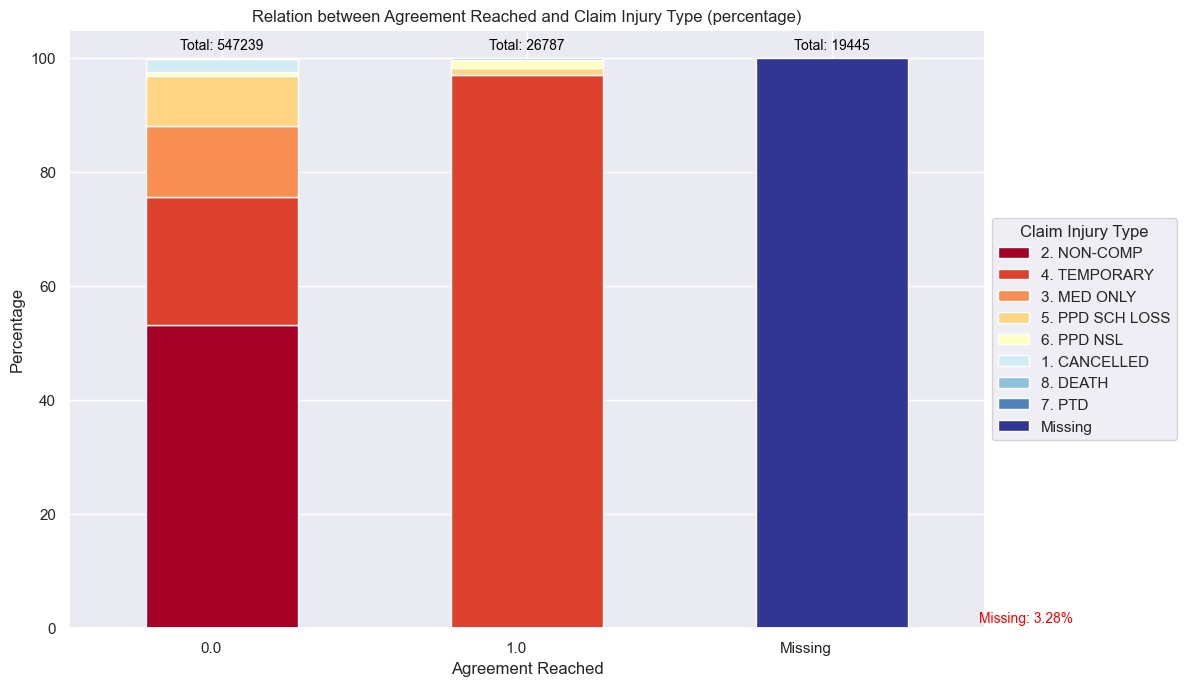

In [264]:
plot_categorical_target_relation_vertical("Agreement Reached", "Claim Injury Type")

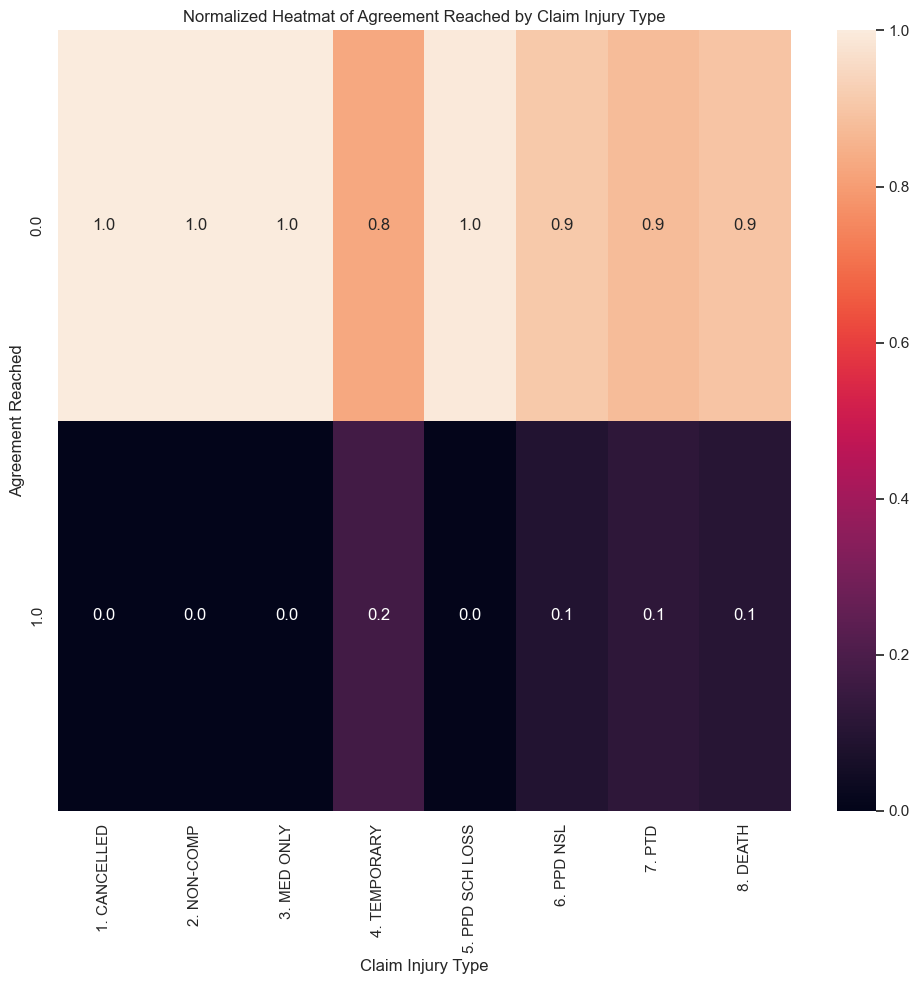

In [265]:
plot_normalized_heatmap("Claim Injury Type", "Agreement Reached")

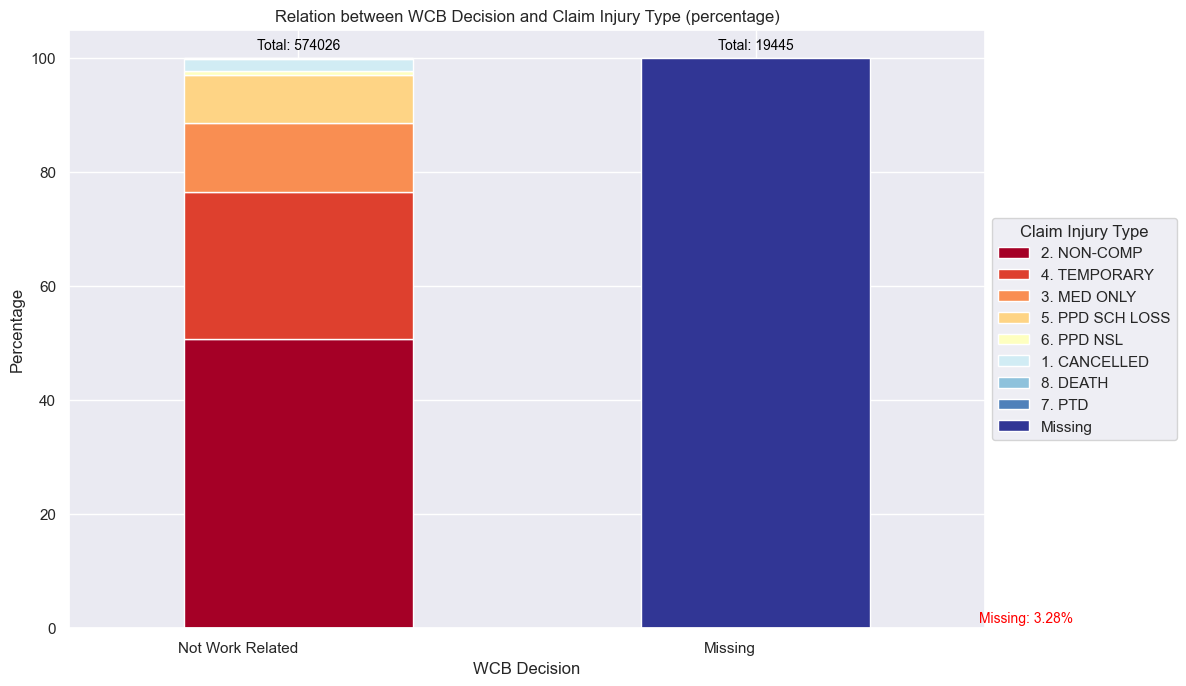

In [266]:
plot_categorical_target_relation_vertical("WCB Decision", "Claim Injury Type")

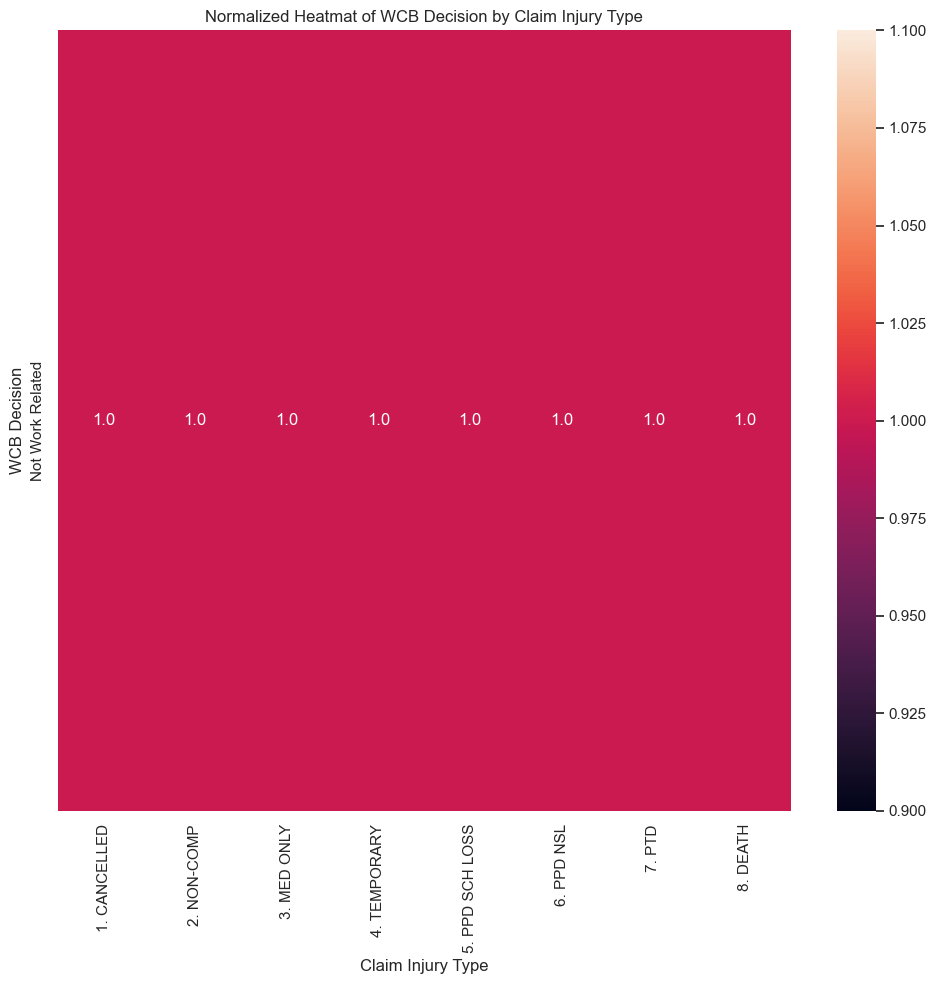

In [267]:
plot_normalized_heatmap("Claim Injury Type", "WCB Decision")

## Pairwise Relation Categorical Variables

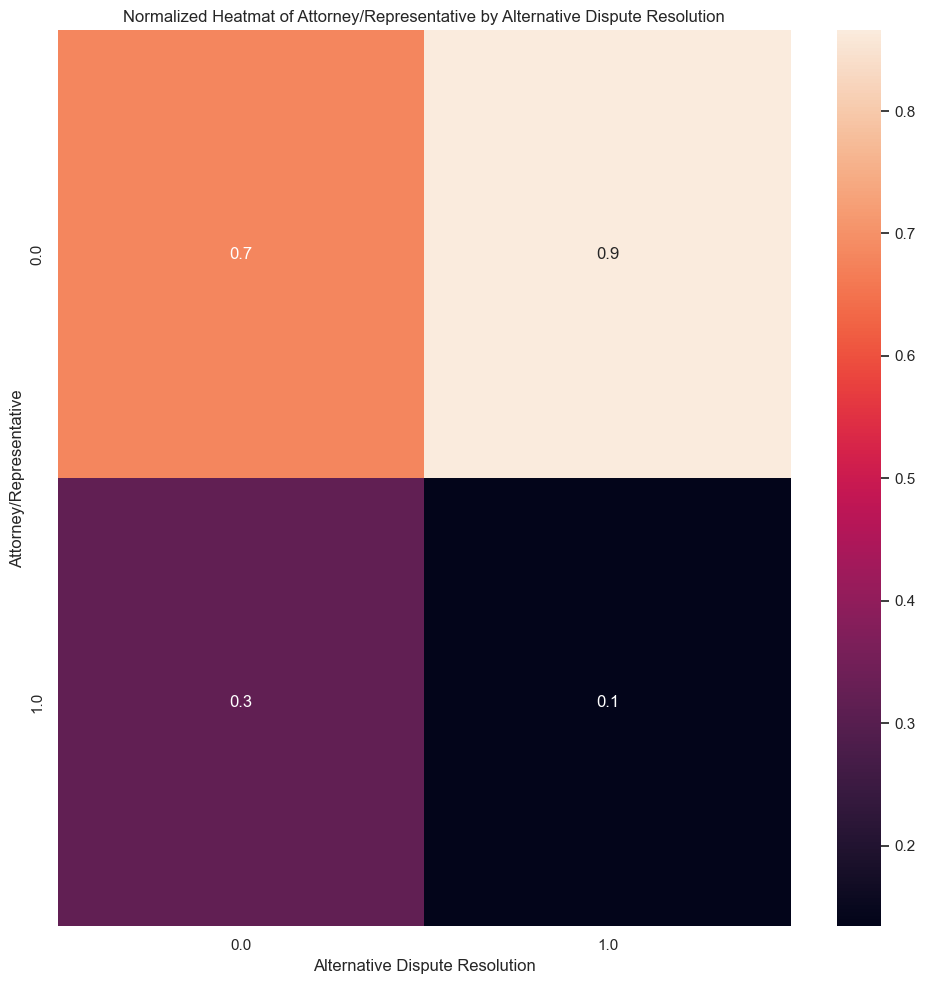

In [268]:
plot_normalized_heatmap("Alternative Dispute Resolution", "Attorney/Representative")

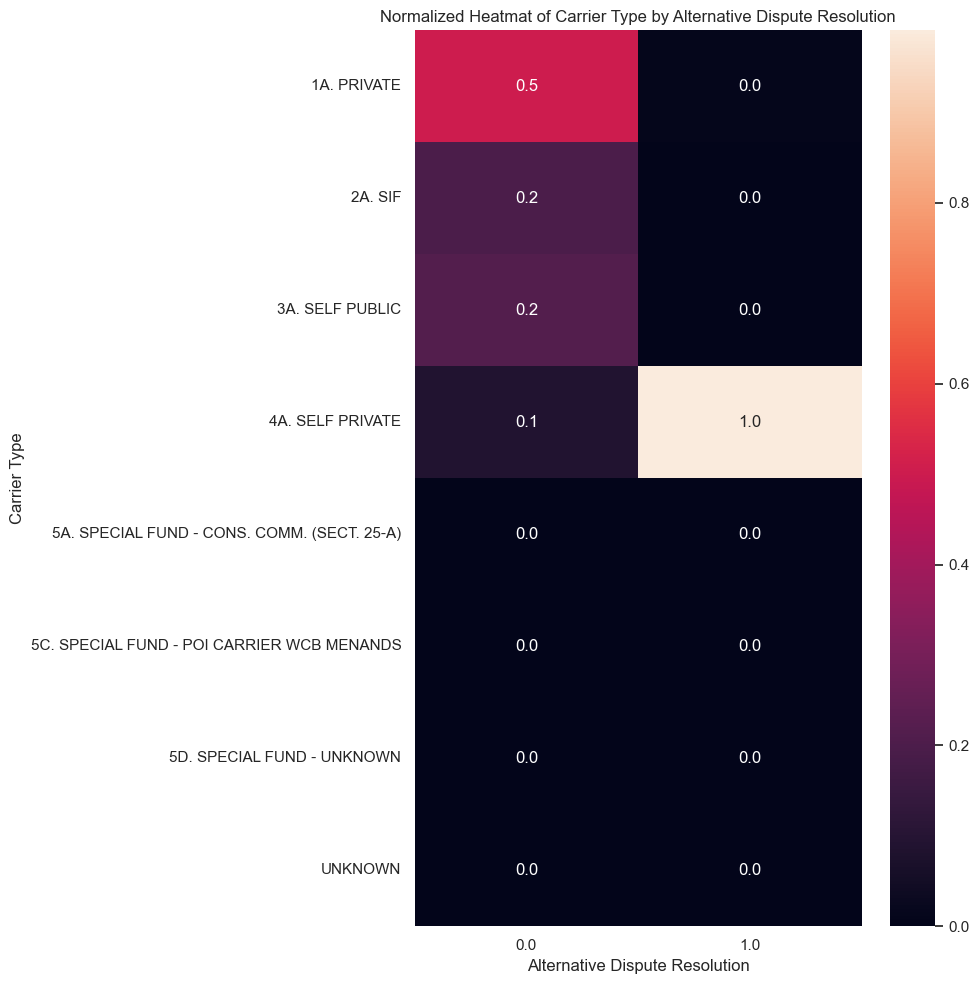

In [269]:
plot_normalized_heatmap("Alternative Dispute Resolution", "Carrier Type")

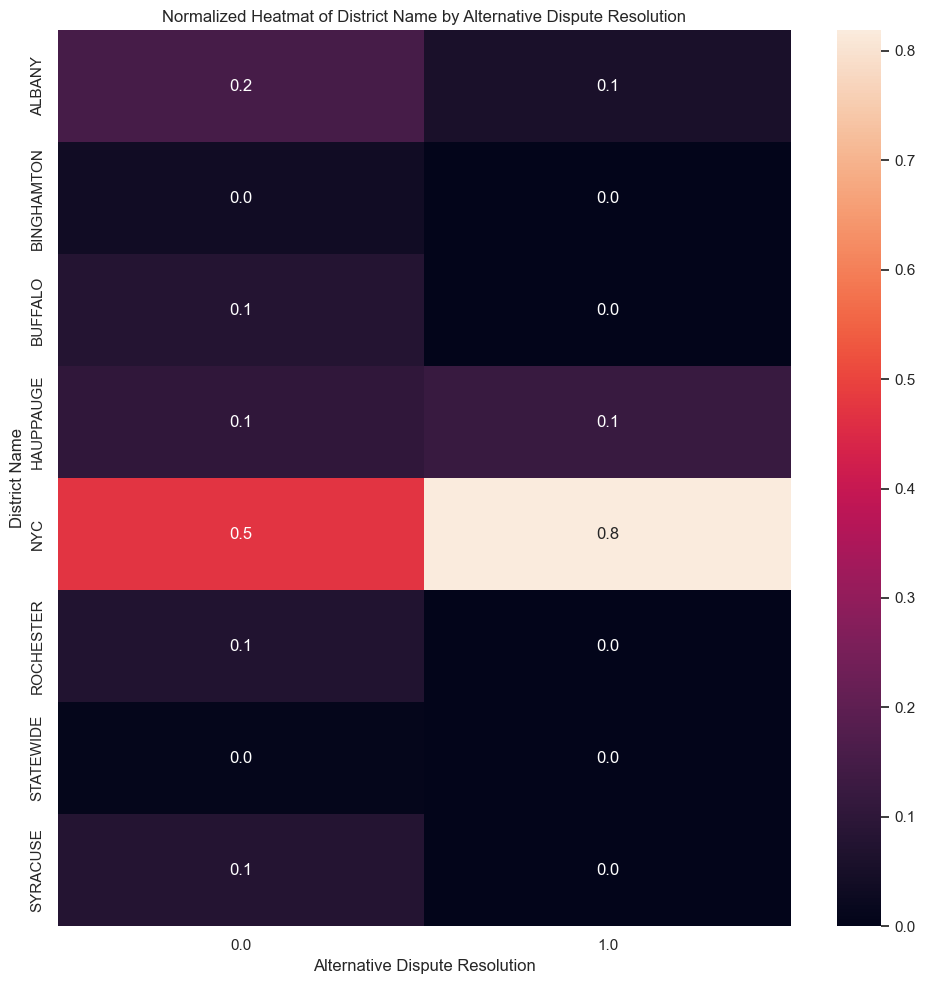

In [270]:
plot_normalized_heatmap("Alternative Dispute Resolution", "District Name")

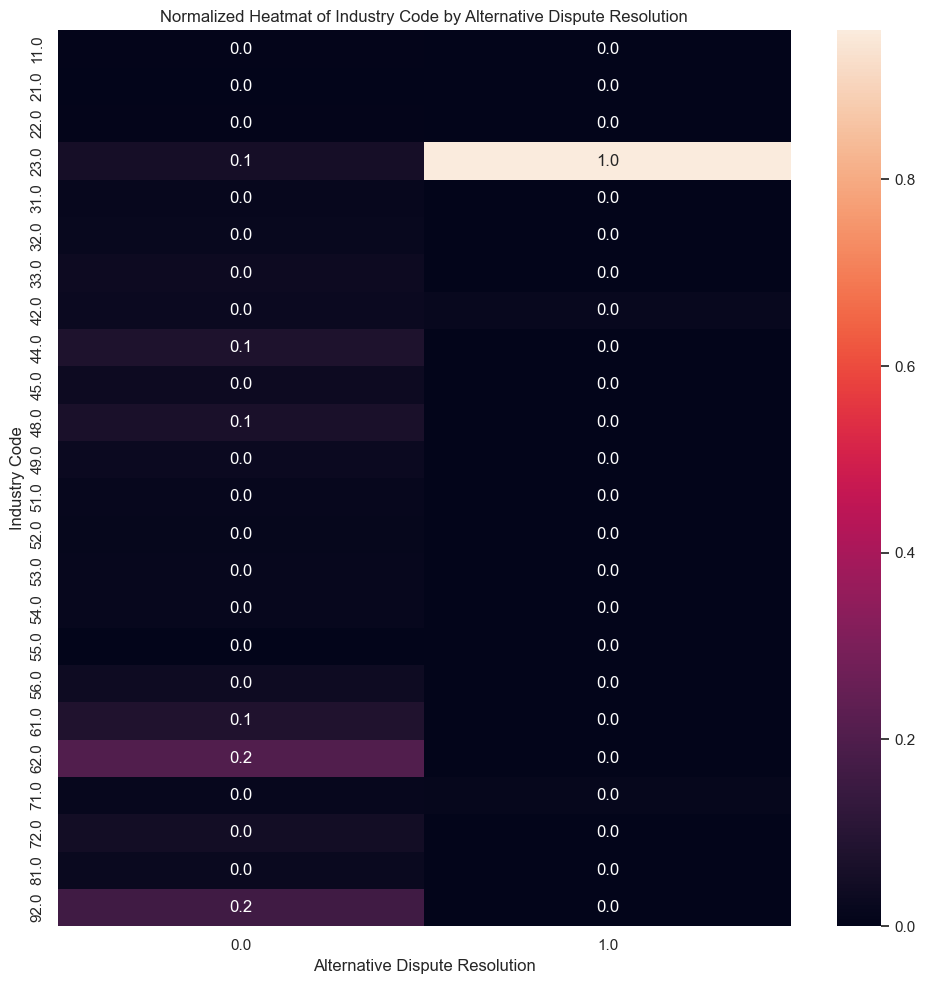

In [271]:
plot_normalized_heatmap("Alternative Dispute Resolution", "Industry Code")

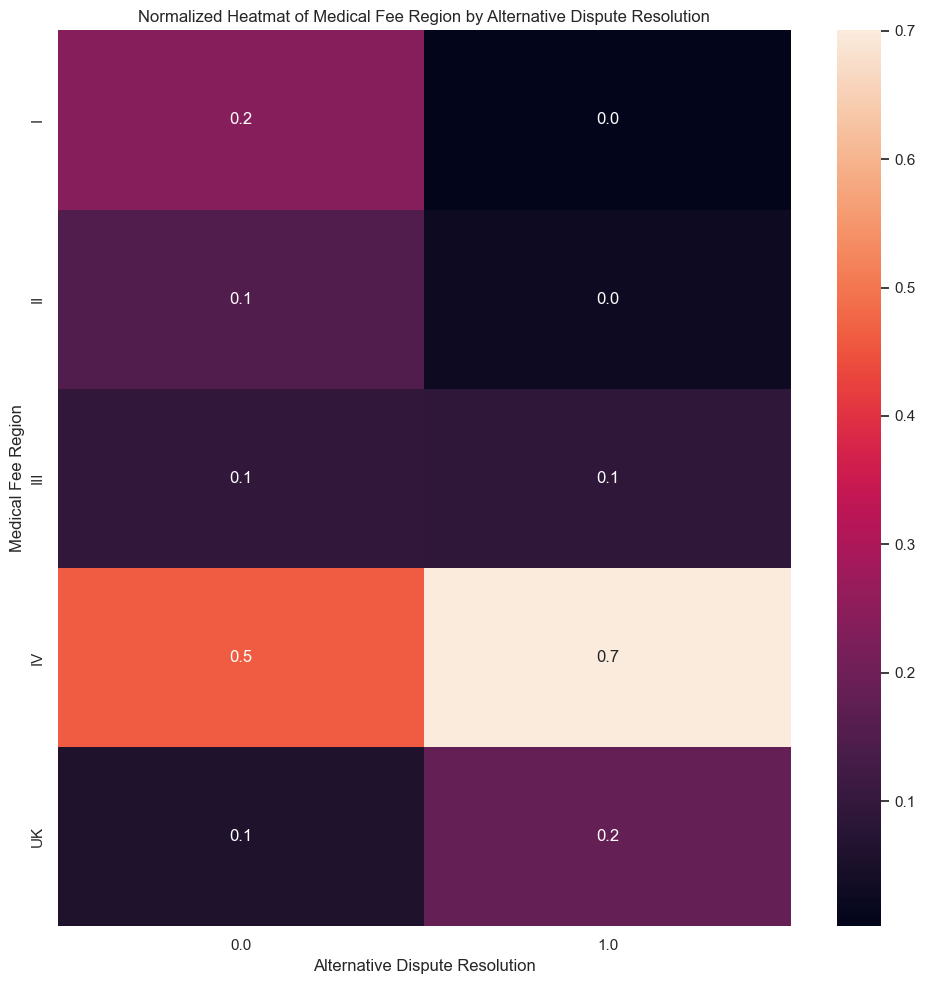

In [272]:
plot_normalized_heatmap("Alternative Dispute Resolution", "Medical Fee Region")

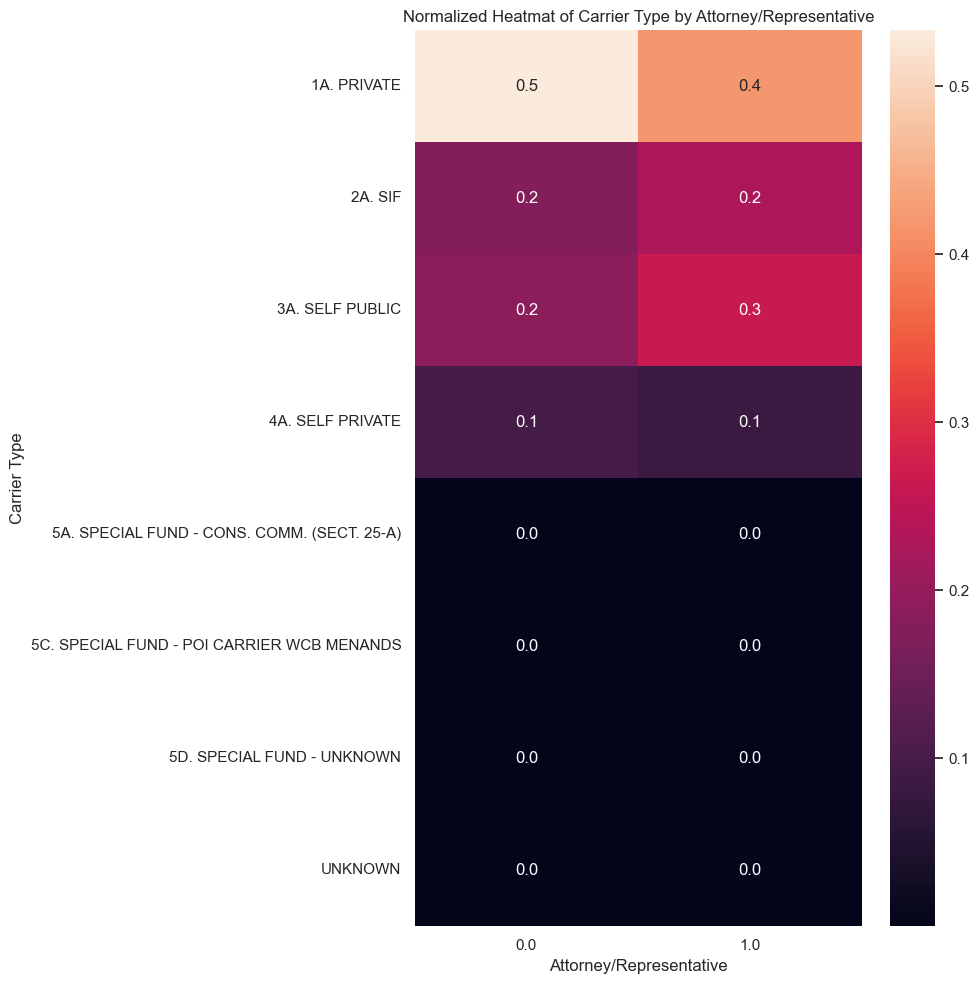

In [273]:
plot_normalized_heatmap("Attorney/Representative", "Carrier Type")

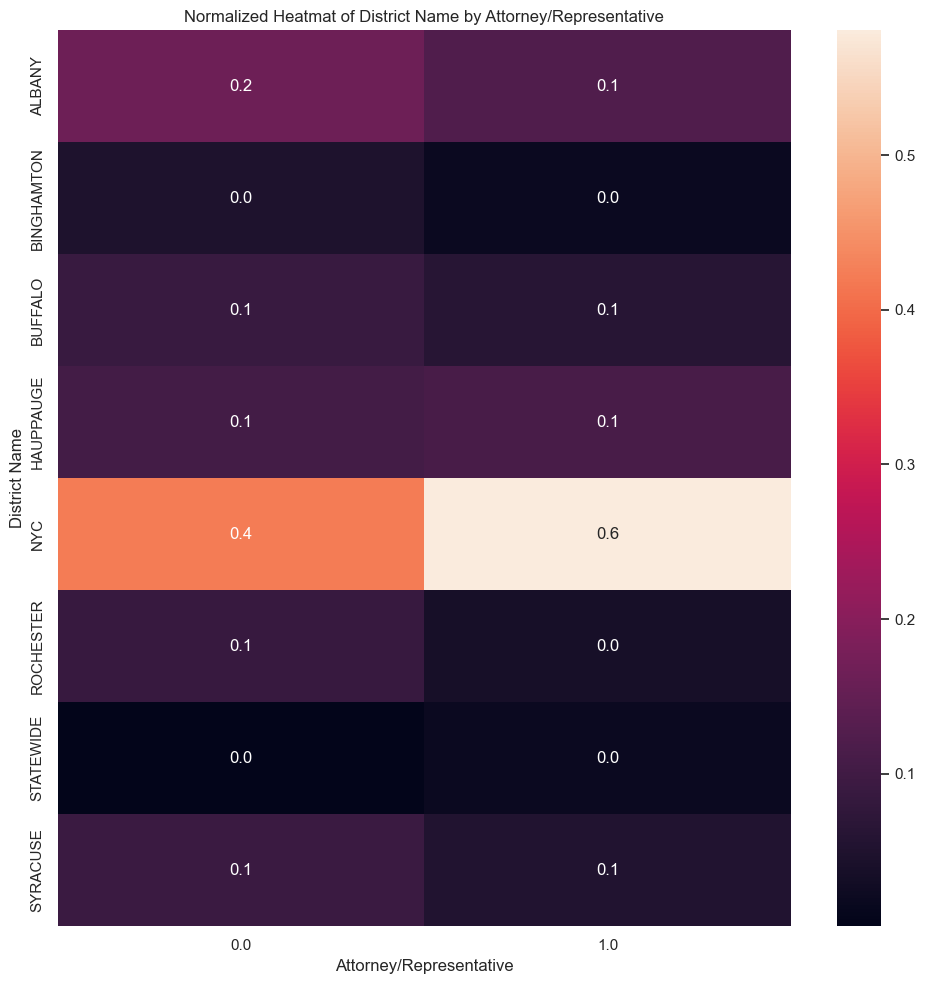

In [274]:
plot_normalized_heatmap("Attorney/Representative", "District Name")

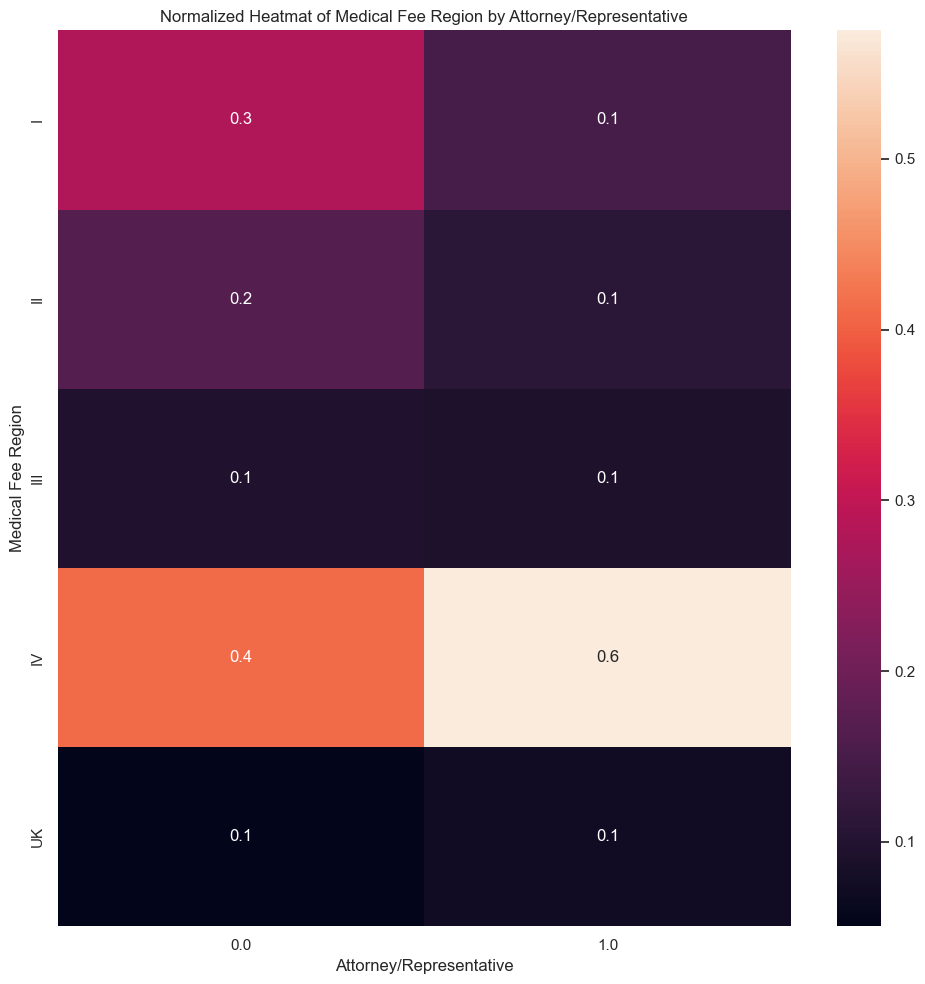

In [275]:
plot_normalized_heatmap("Attorney/Representative", "Medical Fee Region")

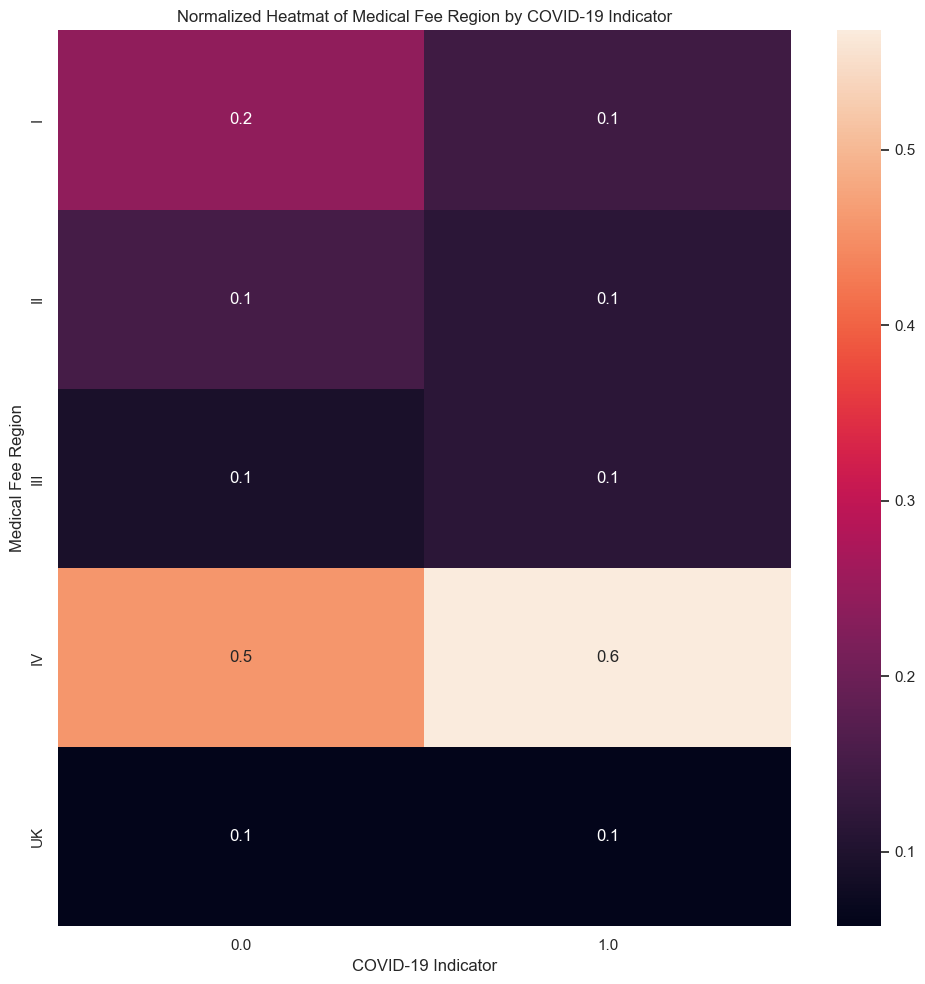

In [276]:
plot_normalized_heatmap("COVID-19 Indicator", "Medical Fee Region")

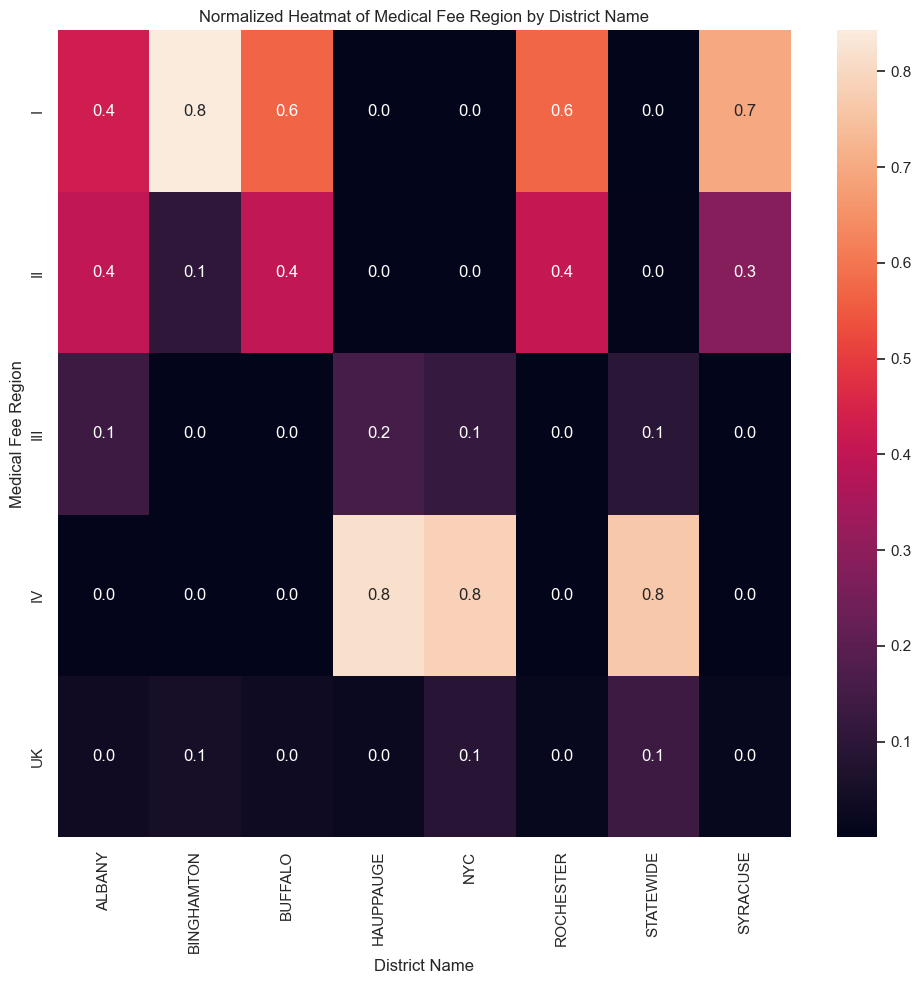

In [277]:
plot_normalized_heatmap("District Name", "Medical Fee Region")

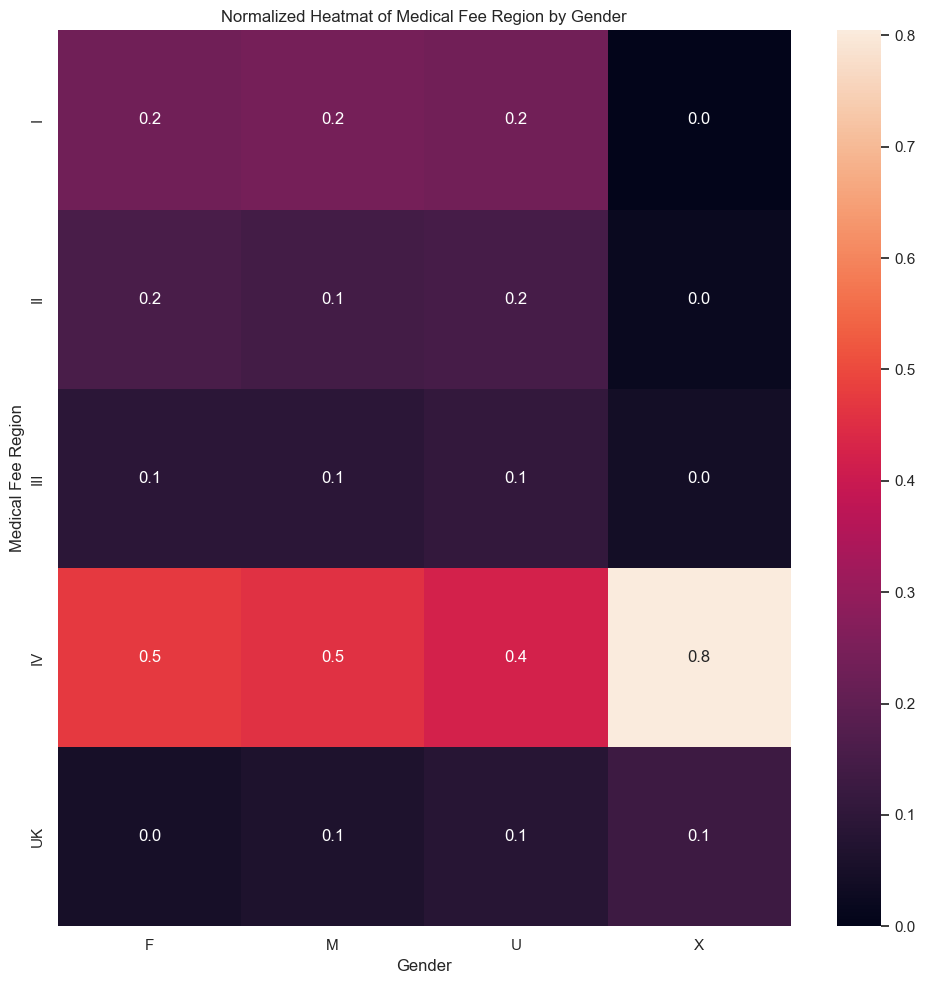

In [278]:
plot_normalized_heatmap("Gender", "Medical Fee Region")

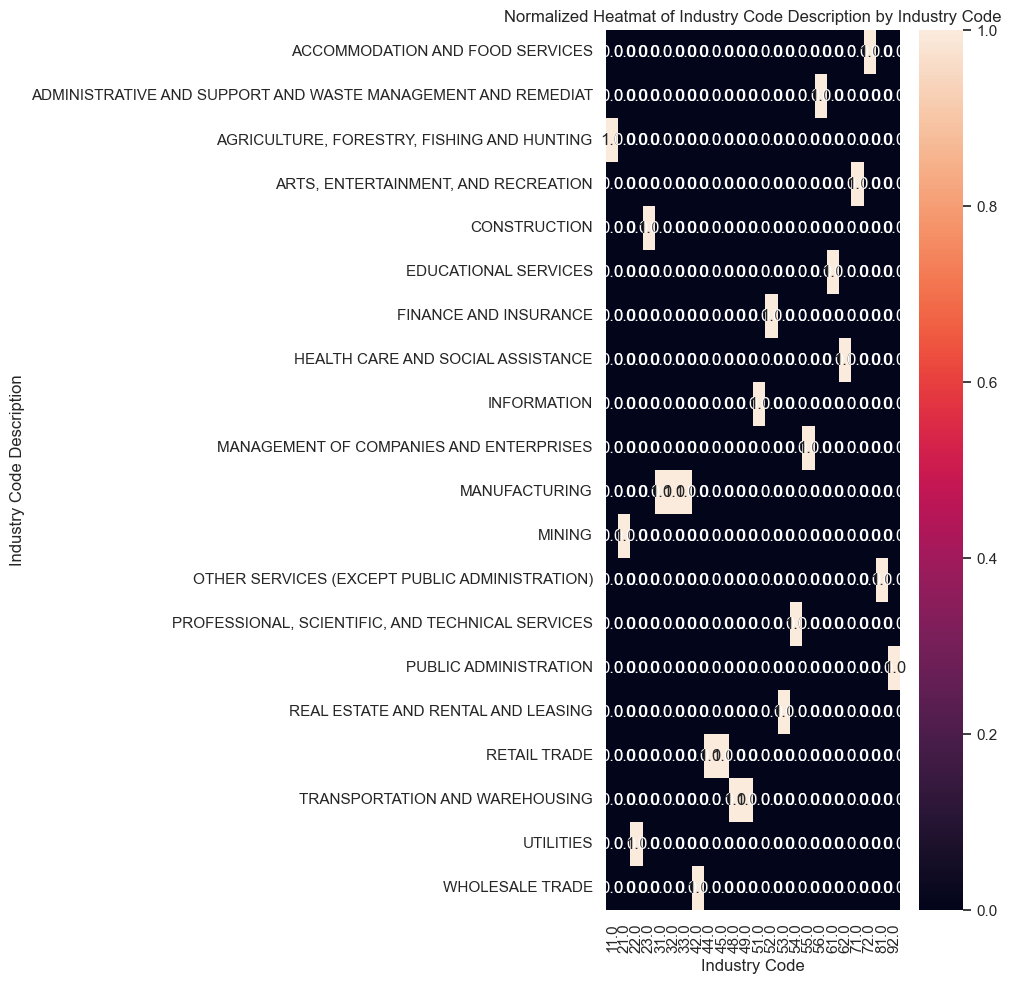

In [279]:
plot_normalized_heatmap("Industry Code", "Industry Code Description")

## Other Visualizations

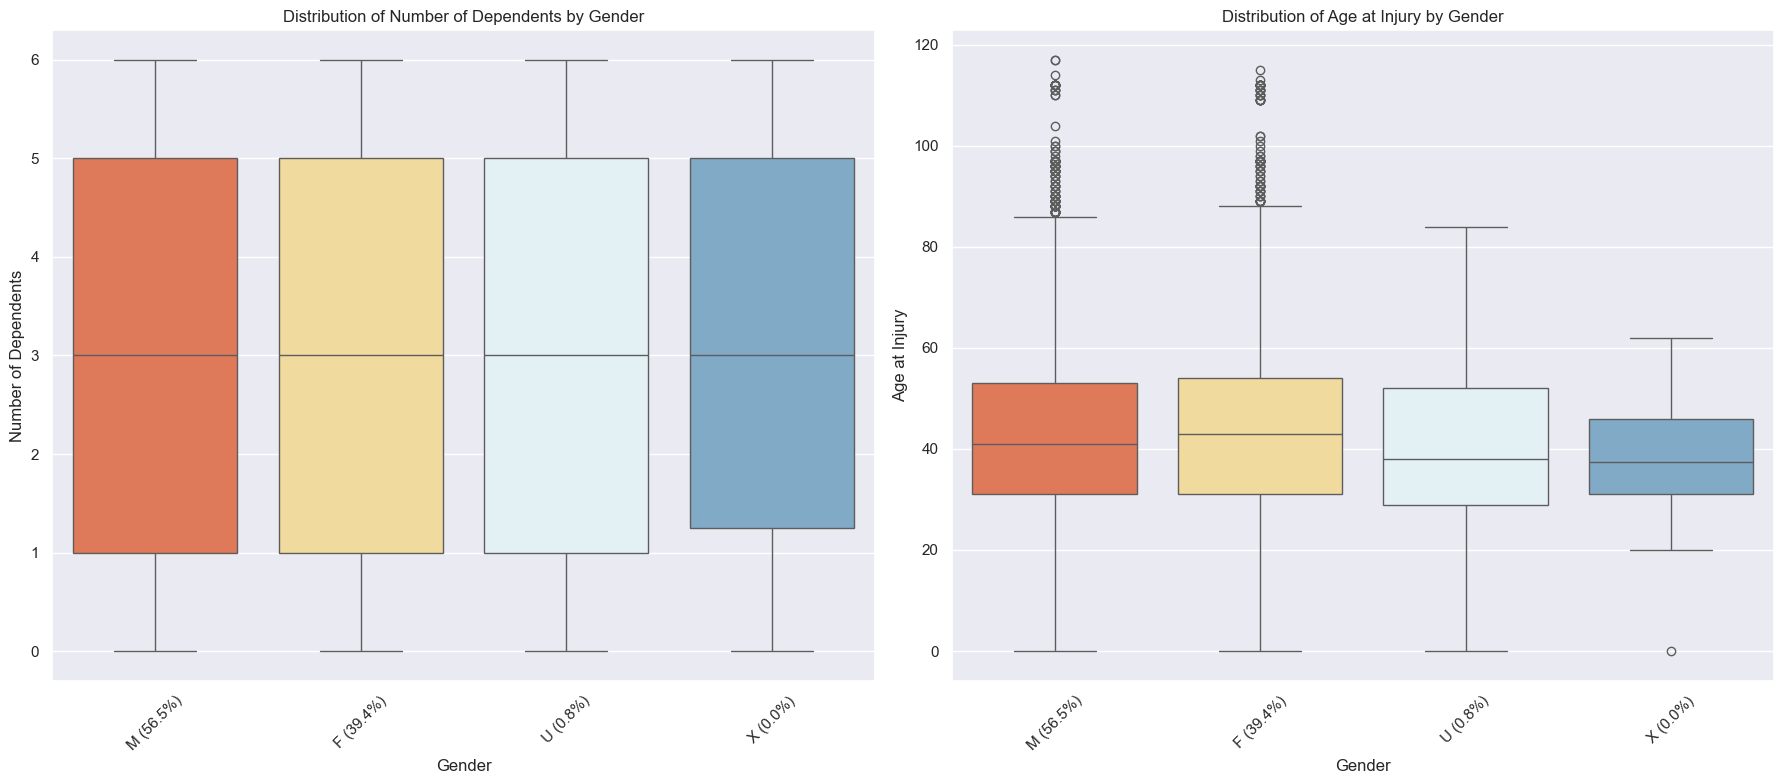

In [280]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have 'df' as your DataFrame

# Calculate the count and percentage of each gender
gender_counts = df["Gender"].value_counts()
total_observations = len(df)
gender_percentages = (gender_counts / total_observations) * 100

# Create a dictionary for quick lookup of each gender's percentage
percentage_labels = {
    gender: f"{gender} ({perc:.1f}%)"
    for gender, perc in zip(gender_counts.index, gender_percentages)
}

# Set up a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)

# Box plot for 'Number of Dependents' by 'Gender'
sns.boxplot(
    data=df,
    x="Gender",
    y="Number of Dependents",
    legend=False,
    hue="Gender",
    palette="RdYlBu",
    ax=axes[0],
    dodge=False,  # To avoid creating duplicate legends
)
axes[0].set_title("Distribution of Number of Dependents by Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Number of Dependents")

# Set tick labels with percentages
axes[0].set_xticks(range(len(gender_counts)))  # Set tick positions explicitly
axes[0].set_xticklabels(
    [percentage_labels[gender] for gender in gender_counts.index], rotation=45
)

# Box plot for 'Average Weekly Wage' by 'Gender'
sns.boxplot(
    data=df,
    x="Gender",
    y="Age at Injury",
    legend=False,
    hue="Gender",
    palette="RdYlBu",
    ax=axes[1],
    dodge=False,  # To avoid creating duplicate legends
)
axes[1].set_title("Distribution of Age at Injury by Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Age at Injury")

# Set tick labels with percentages
axes[1].set_xticks(range(len(gender_counts)))  # Set tick positions explicitly
axes[1].set_xticklabels(
    [percentage_labels[gender] for gender in gender_counts.index], rotation=45
)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

## Insights from Bivariate Analysis

- **High correlation between `Age at Injury` and `Date of Bith`**: **`Age at Injury`** and **`Date of Birth`** have a high negative correlation (-0.87), which was already expected.
- **Low relation between `Medical Fee Region` and `Number of Dependents` with target variable `Claim Injury Type`**: The variables **`Medical Fee Region`** and **`Number of Dependents`** don't seem to be significantly related to the target variable **`Claim Injury Type`**, as there is there's no significant difference in the Claim Injury Type across different Medical Fee Regions.
- **Missing values**: In most cases studied in the pairwaise relation between categorical variables and target variable, 100% of the missing vales of the categorical variable were also missing for the target varible. However, that wasn't the case for the variables **`Industry Code Description`** and **`Industry Code`**, suggesting those should be handled with caution.
- **Strong relationship between categories in `Industry Code` and `Industry Code Description`**, suggesting redundancy. it is recommended to drop one of the variables to avoid redundancy and improve model efficiency.
- **Strong relation between specific Age at Injury and Birth Year with Claim Identifier Type values**: for example, claims with the Claim Identifier Type "Death" correspond to considerably older people.

## Recommendations
- **Feature Selection**: Explore the possibility of dropping highly related variables such as  **`Age at Injury`** and **`Date of Birth`**, as well as **`Industry Code`** and **`Industry Code Description`**, in order to avoid redundancy.
- **Missing values in highly related variables**: Explore different possibilites to handle missing values in variables highly related varibles, such as **`Industry Code Description`** and **`Industry Code`**, focusing on the missing values that are not missing on the target variable.
- **Missing values which are not missing for the target variable**: In most cases studied in the pairwaise relation between categorical variables and target variable, 100% of the missing vales of the categorical variable were also missing for the target varible. However, that wasn't the case for the variables **`Industry Code Description`** and **`Industry Code`**, suggesting those should be handled with caution.
- **Assessing Feature Importance**: When considering droping features, it is important to look at the their relations with other varibles in order to understand their importance and potential implications.

## Final Recommendations:

- **Investigating Outliers**: For variables with high variance, especially **`Average Weekly Wage`**, consider investigating outliers to determine if they represent legitimate data points or errors.
- **Handling Outliers**: For variables such as **`IME-4 Count`** and **`Average Weekly Wage`**, caping should be considered.
- **Clustering High-Cardinality Variables into Meaningful Subgroups**: To manage the high number of unique values, particularly seen in Code variables, it should be considered grouping similar values into subcategories. This will reduce complexity, making patterns easier to identify and analyze. Clustering algorithms like K-Means can help create these subgroups, allowing us to label and interpret behaviors more effectively.
- **Consider Variable Removal**: If certain variables (like OIICS Nature of Injury Description) are consistently NaN, they may not be useful for analysis and should be considered for removal.
- **Validate Date Entries**: Confirm that all dates are within a logical range (e.g., Accident Date is always before other date fields). If this is not the case, further investigate, replace or remove such entries.
- **Missing Values in Date Variables**: Understang the implications of missing values in data variables such as  **`First Hearing Date`** and **`C-3 Date`** which have, respectively, 75% and 68% of missing values. This indicates that not all claims have received this follow-up, which may impact analysis regarding claims processing times.
- **Further analyze the variables `Birth Year`, `Age at Injury` and `Accident Date`**: As previously mentioned, all 3 variables have outliers and missing values. Particularly, the variable **`Birth Year`** has of **8%** missing values and **25330** outliers, making it extremely problematic. We can compute de Birth Year from **`Age at Injuty`** and **`Accident Date`**, using that information to validate information across these variables and have a better handling at missing values and outliers.
- **Feature Selection**: Explore the possibility of dropping highly related variables such as  **`Age at Injury`** and **`Date of Birth`**, as well as **`Industry Code`** and **`Industry Code Description`**, in order to avoid redundancy.
- **Missing values in highly related variables**: Explore different possibilites to handle missing values in variables highly related varibles, such as **`Industry Code Description`** and **`Industry Code`**, focusing on the missing values that are not missing on the target variable.
- **Missing values which are not missing for the target variable**: In most cases studied in the pairwaise relation between categorical variables and target variable, 100% of the missing vales of the categorical variable were also missing for the target varible. However, that wasn't the case for the variables **`Industry Code Description`** and **`Industry Code`**, suggesting those should be handled with caution.
- **Assessing Feature Importance**: When considering droping features, it is important to look at the their relations with other varibles in order to understand their importance and the implications of dropping them.

# <span style="color:#e0bda8">5. Data Preprocessing</span>

In [281]:
df_pre_processing = df.copy()

We converted dates into datetime format.

In [282]:
dates = ["Accident Date", "Assembly Date", "C-2 Date", "C-3 Date", "First Hearing Date"]
for date in dates:
    df_pre_processing[date] = pd.to_datetime(df_pre_processing[date])

We check for missing values on each category

In [283]:
df_pre_processing.isna().sum()

Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19450
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Identifier                           0
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region                     19445
OIICS Natu

The column: 'OIICS Nature of Injury Description' is missing all its values, so we drop it.

In [284]:
df_pre_processing = df_pre_processing.drop("OIICS Nature of Injury Description", axis=1)

There's a lot of columns with the same number of missing values (19945) and none has less than that besides Assembly Date and Claim Identifier. Let's check if the 19945 missing values on all the remaining columns match. If they do, this means that there's no information on those patients so we should remove those rows.

In [285]:
no_district = df_pre_processing[df_pre_processing["District Name"].isna()]

In [286]:
no_district.isna().all()

Accident Date                         True
Age at Injury                         True
Alternative Dispute Resolution        True
Assembly Date                        False
Attorney/Representative               True
Average Weekly Wage                   True
Birth Year                            True
C-2 Date                              True
C-3 Date                              True
Carrier Name                          True
Carrier Type                          True
Claim Identifier                     False
Claim Injury Type                     True
County of Injury                      True
COVID-19 Indicator                    True
District Name                         True
First Hearing Date                    True
Gender                                True
IME-4 Count                           True
Industry Code                         True
Industry Code Description             True
Medical Fee Region                    True
WCIO Cause of Injury Code             True
WCIO Cause 

As the assumption was verified, the rows from the dataset were removed.

In [287]:
df_pre_processing = df_pre_processing.drop(no_district.index)

IME-4 Count has many missing values, but maybe this means they didn't count any (so should be 0). After verifying that there are no 0s in IME-4 Count, the missing values were filled with 0.

In [288]:
df_pre_processing["IME-4 Count"].unique()

<IntegerArray>
[<NA>,    4,    1,    3,    2,    6,    7,    5,   10,   12,    8,    9,   11,
   13,   14,   36,   15,   20,   19,   18,   27,   17,   16,   24,   22,   26,
   21,   23,   30,   32,   39,   25,   29,   47,   48,   34,   28,   37,   31,
   35,   33,   73]
Length: 42, dtype: Int64

In [289]:
df_pre_processing["IME-4 Count"] = df_pre_processing["IME-4 Count"].fillna(0)

WCB Decision only has "Not Work Related", so we drop it.

In [290]:
df_pre_processing["WCB Decision"].value_counts(dropna=False)

WCB Decision
Not Work Related    574026
Name: count, dtype: int64

In [291]:
df_pre_processing = df_pre_processing.drop("WCB Decision", axis=1)

Some birth years and age at injury can be calculated by using other date columns

In [292]:
df_pre_processing[
    "Age at Injury"
].value_counts().sort_index()  # there are some ages wrongfully registered as 0 (lowest value)

Age at Injury
0      5464
1         2
5         1
7         2
8         6
       ... 
112      24
113       1
114       1
115       1
117       2
Name: count, Length: 108, dtype: Int64

In [293]:
df_pre_processing[
    "Birth Year"
].value_counts().sort_index()  # there are also some birth years wrongfully registered as 0 (lowest value)

Birth Year
0       25081
1900        2
1901       30
1902       28
1903       35
        ...  
2011        6
2012        2
2013        1
2014        2
2018        2
Name: count, Length: 107, dtype: Int64

In [294]:
df_pre_processing["Calculated Birth Year"] = (
    df_pre_processing["Accident Date"].dt.year - df_pre_processing["Age at Injury"]
)

df_pre_processing["Calculated Age at Injury"] = (
    df_pre_processing["Accident Date"].dt.year - df_pre_processing["Birth Year"]
)

Case 1: The birth year calculated and the one established in the 'Birth Year' column showed significant differences for some rows. Analyzing ages_wrong (all discrepancies where 'Birth Year' was not 0), we found that these differences were due to ages being incorrectly recorded as 0 in those rows. In these cases, we replaced the age with the calculated age.

In [295]:
df_pre_processing["Birth Years Comparison"] = abs(
    df_pre_processing["Birth Year"] - df_pre_processing["Calculated Birth Year"]
)

different_birth_years = df_pre_processing[
    df_pre_processing["Birth Years Comparison"] > 1
]

ages_wrong = different_birth_years[different_birth_years["Birth Year"] > 0]

ages_indexes = ages_wrong.index

df_pre_processing.loc[ages_indexes, "Age at Injury"] = df_pre_processing.loc[
    ages_indexes, "Calculated Age at Injury"
]

In [296]:
all(ages_wrong["Age at Injury"] == 0)  # verification that all ages were 0 in that case

True

Case 2: Similar to Case 1, but this time the discrepancies in age (where it was larger than 0) occurred because all birth years were initially set to 0. We replaced the birth year in these rows with the calculated birth year.

In [297]:
df_pre_processing["Ages Comparison"] = abs(
    df_pre_processing["Age at Injury"] - df_pre_processing["Calculated Age at Injury"]
)

different_ages = df_pre_processing[df_pre_processing["Ages Comparison"] > 1]

birth_year_wrong = different_ages[different_ages["Age at Injury"] > 0]

birth_year_indexes = birth_year_wrong.index

df_pre_processing.loc[birth_year_indexes, "Birth Year"] = df_pre_processing.loc[
    birth_year_indexes, "Calculated Birth Year"
]

In [298]:
all(
    birth_year_wrong["Birth Year"] == 0
)  # verification that all birth years were 0 in that case

True

Case 3: Some birth years were missing values with the age at injury and accident date defined, so we replaced them with the calculated birth year.

In [299]:
birth_nas = df_pre_processing[df_pre_processing["Birth Year"].isna()]
age_abv_0 = birth_nas[birth_nas["Age at Injury"] > 0]
age_abv_0_indexes = age_abv_0.index
df_pre_processing.loc[age_abv_0_indexes, "Birth Year"] = df_pre_processing.loc[
    age_abv_0_indexes, "Calculated Birth Year"
]

In [300]:
any(
    age_abv_0["Age at Injury"] == 0
)  # verification that there are no 0s in age for these cases (nor missing values as we've checked before). This means that calculating Birth Year using Age at Injury is possible

False

We just wanted those columns to discover the possible values on Age at Injury and Birth Year, so now we drop them.

In [301]:
df_pre_processing = df_pre_processing.drop(
    [
        "Calculated Age at Injury",
        "Calculated Birth Year",
        "Ages Comparison",
        "Birth Years Comparison",
    ],
    axis=1,
)

In [302]:
df_pre_processing.isna().sum()

Accident Date                          3689
Age at Injury                             0
Alternative Dispute Resolution            5
Assembly Date                             0
Attorney/Representative                   0
Average Weekly Wage                   28651
Birth Year                              260
C-2 Date                              14560
C-3 Date                             386781
Carrier Name                              0
Carrier Type                              0
Claim Identifier                          0
Claim Injury Type                         0
County of Injury                          0
COVID-19 Indicator                        0
District Name                             0
First Hearing Date                   423228
Gender                                    0
IME-4 Count                               0
Industry Code                          9958
Industry Code Description              9958
Medical Fee Region                        0
WCIO Cause of Injury Code       

As 0 values in these columns are behaving as missing values, it's also important to see how many we have left.

In [303]:
len(df_pre_processing[df_pre_processing["Age at Injury"] == 0])

5371

In [304]:
len(df_pre_processing[df_pre_processing["Birth Year"] == 0])

1926

We grouped the categories WCIO Cause of Injury Code, WCIO Nature of Injury Code and WCIO Part Of Body Code by their supra code we found available.

In [305]:
# I. Burn or Scald - Heat or Cold Exposures - Contact With
burn_or_scald = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "11", "14", "84"]

# II. Caught In, Under or Between
caught_in_under_between = ["10", "12", "13", "20"]

# III. Cut, Puncture, Scrape Injured By
cut_puncture_scrape = ["15", "16", "17", "18", "19"]

# IV. Fall, Slip or Trip Injury
fall_slip_trip = ["25", "26", "27", "28", "29", "30", "31", "32", "33"]

# V. Motor Vehicle
motor_vehicle = ["40", "41", "45", "46", "47", "48", "50"]

# VI. Strain or Injury By
strain_or_injury = ["52", "53", "54", "55", "56", "57", "58", "59", "60", "61", "97"]

# VII. Striking Against or Stepping On
striking_against = ["65", "66", "67", "68", "69", "70"]

# VIII. Struck or Injured By
struck_or_injured = ["74", "75", "76", "77", "78", "79", "80", "81", "85", "86"]

# IX. Rubbed or Abraded By
rubbed_or_abraded = ["94", "95"]

# X. Miscellaneous Causes
miscellaneous = ["82", "83", "87", "88", "89", "90", "91", "93", "96", "98", "99"]


df_pre_processing["WCIO Cause of Injury Code SUPRA"] = df_pre_processing[
    "WCIO Cause of Injury Code"
].apply(
    lambda code: (
        "I. Burn or Scald - Heat or Cold Exposures - Contact With"
        if str(code).split(".")[0] in burn_or_scald
        else (
            "II. Caught In, Under or Between"
            if str(code).split(".")[0] in caught_in_under_between
            else (
                "III. Cut, Puncture, Scrape Injured By"
                if str(code).split(".")[0] in cut_puncture_scrape
                else (
                    "IV. Fall, Slip or Trip Injury"
                    if str(code).split(".")[0] in fall_slip_trip
                    else (
                        "V. Motor Vehicle"
                        if str(code).split(".")[0] in motor_vehicle
                        else (
                            "VI. Strain or Injury By"
                            if str(code).split(".")[0] in strain_or_injury
                            else (
                                "VII. Striking Against or Stepping On"
                                if str(code).split(".")[0] in striking_against
                                else (
                                    "VIII. Struck or Injured By"
                                    if str(code).split(".")[0] in struck_or_injured
                                    else (
                                        "IX. Rubbed or Abraded By"
                                        if str(code).split(".")[0] in rubbed_or_abraded
                                        else (
                                            "X. Miscellaneous Causes"
                                            if str(code).split(".")[0] in miscellaneous
                                            else np.nan
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

In [306]:
# Specific Injury codes (Category I)
specific_injury = [
    "1",
    "2",
    "3",
    "4",
    "7",
    "10",
    "13",
    "16",
    "19",
    "22",
    "25",
    "28",
    "30",
    "31",
    "32",
    "34",
    "36",
    "37",
    "38",
    "40",
    "41",
    "42",
    "43",
    "46",
    "47",
    "49",
    "52",
    "53",
    "54",
    "55",
    "58",
    "59",
]

# Occupational Disease or Cumulative Injury codes (Category II)
occupational_disease = [
    "60",
    "61",
    "62",
    "63",
    "64",
    "65",
    "66",
    "67",
    "68",
    "69",
    "70",
    "71",
    "72",
    "73",
    "74",
    "75",
    "76",
    "77",
    "78",
    "79",
    "80",
    "83",
]

# Multiple Injuries codes (Category III)
multiple_injuries = ["90", "91"]


df_pre_processing["WCIO Nature of Injury Code SUPRA"] = df_pre_processing[
    "WCIO Nature of Injury Code"
].apply(
    lambda code: (
        "Category I: Specific Injury"
        if str(code).split(".")[0] in specific_injury
        else (
            "Category II: Occupational Disease or Cumulative Injury"
            if str(code).split(".")[0] in occupational_disease
            else (
                "Category III: Multiple Injuries"
                if str(code).split(".")[0] in multiple_injuries
                else np.nan
            )
        )
    )
)

In [307]:
# I. Head
head = [
    "10",
    "11",
    "12",
    "13",
    "13A",
    "13B",
    "13C",
    "14",
    "14A",
    "14B",
    "14C",
    "15",
    "16",
    "17",
    "18",
    "19",
]

# II. Neck
neck = ["20", "21", "22", "23", "24", "25", "26"]

# III. Upper Extremities
upper_extremities = [
    "30",
    "31",
    "32",
    "33",
    "34",
    "35",
    "36",
    "36A",
    "36B",
    "36C",
    "36D",
    "36E",
    "36F",
    "36G",
    "36H",
    "36I",
    "36J",
    "36K",
    "36L",
    "36M",
    "36N",
    "36O",
    "36P",
    "37",
    "37A",
    "37B",
    "37C",
    "38",
    "39",
]

# IV. Trunk
trunk = [
    "40",
    "41",
    "42",
    "43",
    "44",
    "45",
    "46",
    "47",
    "48",
    "49",
    "60",
    "61",
    "62",
    "63",
]

# V. Lower Extremities
lower_extremities = [
    "50",
    "51",
    "52",
    "53",
    "54",
    "55",
    "56",
    "57",
    "57A",
    "57B",
    "57C",
    "57D",
    "57E",
    "57F",
    "57G",
    "58",
    "58A",
    "58B",
    "58C",
]

# VI. Multiple Body Parts
multiple_body_parts = ["64", "65", "66", "90", "91", "99"]


df_pre_processing["WCIO Part Of Body Code SUPRA"] = df_pre_processing[
    "WCIO Part Of Body Code"
].apply(
    lambda code: (
        "I. Head"
        if str(code).split(".")[0] in head
        else (
            "II. Neck"
            if str(code).split(".")[0] in neck
            else (
                "III. Upper Extremities"
                if str(code).split(".")[0] in upper_extremities
                else (
                    "IV. Trunk"
                    if str(code).split(".")[0] in trunk
                    else (
                        "V. Lower Extremities"
                        if str(code).split(".")[0] in lower_extremities
                        else (
                            "VI. Multiple Body Parts"
                            if str(code).split(".")[0] in multiple_body_parts
                            else np.nan
                        )
                    )
                )
            )
        )
    )
)

Now we will drop some columns that we will not need further down our analysis.

In [308]:
df_pre_processing = df_pre_processing.drop(
    [
        "C-3 Date",
        "Industry Code",
        "Industry Code Description",
        "WCIO Cause of Injury Code",
        "WCIO Cause of Injury Description",
        "WCIO Nature of Injury Code",
        "WCIO Nature of Injury Description",
        "WCIO Part Of Body Code",
        "WCIO Part Of Body Description",
        "Zip Code",
    ],
    axis=1,
)

In [309]:
df_pre_processing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 574026 entries, 0 to 593467
Data columns (total 24 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Accident Date                     570337 non-null  datetime64[ns]
 1   Age at Injury                     574026 non-null  Int64         
 2   Alternative Dispute Resolution    574021 non-null  object        
 3   Assembly Date                     574026 non-null  datetime64[ns]
 4   Attorney/Representative           574026 non-null  object        
 5   Average Weekly Wage               545375 non-null  float64       
 6   Birth Year                        573766 non-null  Int64         
 7   C-2 Date                          559466 non-null  datetime64[ns]
 8   Carrier Name                      574026 non-null  object        
 9   Carrier Type                      574026 non-null  object        
 10  Claim Identifier                  574

In [310]:
df_pre_processing.isna().sum()

Accident Date                         3689
Age at Injury                            0
Alternative Dispute Resolution           5
Assembly Date                            0
Attorney/Representative                  0
Average Weekly Wage                  28651
Birth Year                             260
C-2 Date                             14560
Carrier Name                             0
Carrier Type                             0
Claim Identifier                         0
Claim Injury Type                        0
County of Injury                         0
COVID-19 Indicator                       0
District Name                            0
First Hearing Date                  423228
Gender                                   0
IME-4 Count                              0
Medical Fee Region                       0
Agreement Reached                        0
Number of Dependents                     0
WCIO Cause of Injury Code SUPRA      15640
WCIO Nature of Injury Code SUPRA     15657
WCIO Part O

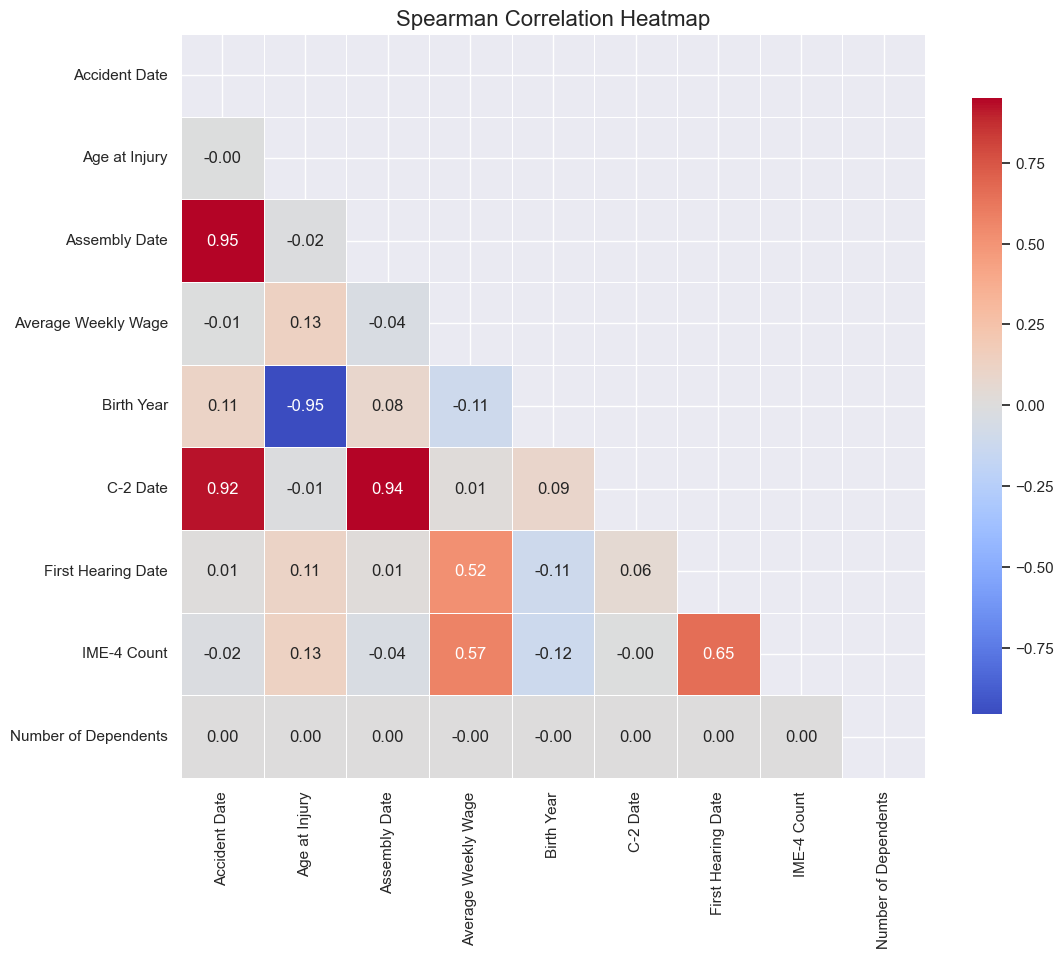

In [311]:
# Obtain the Spearman correlation matrix
cor_spearman = df_pre_processing.select_dtypes(exclude="object").corr(method="spearman")

# Create a mask for the upper triangle (if you want to hide it)
mask = np.triu(np.ones_like(cor_spearman, dtype=bool))

# Define a custom colormap (you can modify the colors as needed)
custom_cmap = sns.color_palette(
    "coolwarm", as_cmap=True
)  # Change to your preferred colormap

# Optionally, define whether to annotate or not
annot = True  # Set to True to show the correlation coefficients

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data=cor_spearman,
    annot=annot,
    cmap=custom_cmap,
    mask=mask,
    fmt=".2f",  # Format for the annotation, use '.2f' for float
    square=True,  # Keep cells square
    linewidths=0.5,  # Add lines between cells for clarity
    cbar_kws={"shrink": 0.8},
)  # Adjust the colorbar size

# Add title
plt.title("Spearman Correlation Heatmap", fontsize=16)

# Show the heatmap
plt.show()

Now that we have inserted all values that we could assume/calculate with precision, we split the dataframe into a training set and a validation set, so that we can input all the other missing values and outliers.

In [312]:
df_pre_processing.dropna(subset=["Claim Injury Type"], inplace=True)
df_pre_processing.set_index("Claim Identifier", inplace=True)


X = df_pre_processing.copy().drop(["Claim Injury Type"], axis=1)



y = df_pre_processing["Claim Injury Type"]



X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y, shuffle=True
)

In [313]:
# Check the updated number of missing values
X_train.isna().sum()

Accident Date                         2586
Age at Injury                            0
Alternative Dispute Resolution           3
Assembly Date                            0
Attorney/Representative                  0
Average Weekly Wage                  20057
Birth Year                             189
C-2 Date                             10195
Carrier Name                             0
Carrier Type                             0
County of Injury                         0
COVID-19 Indicator                       0
District Name                            0
First Hearing Date                  296254
Gender                                   0
IME-4 Count                              0
Medical Fee Region                       0
Agreement Reached                        0
Number of Dependents                     0
WCIO Cause of Injury Code SUPRA      10956
WCIO Nature of Injury Code SUPRA     10970
WCIO Part Of Body Code SUPRA         41439
dtype: int64

In [314]:
X_train.isna().sum() / X_train.shape[0] * 100

Accident Date                        0.643575
Age at Injury                        0.000000
Alternative Dispute Resolution       0.000747
Assembly Date                        0.000000
Attorney/Representative              0.000000
Average Weekly Wage                  4.991563
Birth Year                           0.047036
C-2 Date                             2.537218
Carrier Name                         0.000000
Carrier Type                         0.000000
County of Injury                     0.000000
COVID-19 Indicator                   0.000000
District Name                        0.000000
First Hearing Date                  73.728404
Gender                               0.000000
IME-4 Count                          0.000000
Medical Fee Region                   0.000000
Agreement Reached                    0.000000
Number of Dependents                 0.000000
WCIO Cause of Injury Code SUPRA      2.726608
WCIO Nature of Injury Code SUPRA     2.730092
WCIO Part Of Body Code SUPRA      

Missing values on First Hearing Date are hearings not scheduled yet, so we equalled them to the most recent available 

In [315]:
max_date = X_train["First Hearing Date"].max()
X_train["First Hearing Date"] = X_train["First Hearing Date"].fillna(max_date)
X_val["First Hearing Date"] = X_val["First Hearing Date"].fillna(max_date)

As the percentage of missing values in "Accident Date" and "C-2 Date" are low, we replaced them with the median of each respectively.

In [316]:
median_accident_date = X_train["Accident Date"].median()
X_train["Accident Date"] = X_train["Accident Date"].fillna(median_accident_date)
X_val["Accident Date"] = X_val["Accident Date"].fillna(median_accident_date)

median_C2_date = X_train["C-2 Date"].median()
X_train["C-2 Date"] = X_train["C-2 Date"].fillna(median_C2_date)
X_val["C-2 Date"] = X_val["C-2 Date"].fillna(median_C2_date)

In [317]:
X_train.isna().sum()

Accident Date                           0
Age at Injury                           0
Alternative Dispute Resolution          3
Assembly Date                           0
Attorney/Representative                 0
Average Weekly Wage                 20057
Birth Year                            189
C-2 Date                                0
Carrier Name                            0
Carrier Type                            0
County of Injury                        0
COVID-19 Indicator                      0
District Name                           0
First Hearing Date                      0
Gender                                  0
IME-4 Count                             0
Medical Fee Region                      0
Agreement Reached                       0
Number of Dependents                    0
WCIO Cause of Injury Code SUPRA     10956
WCIO Nature of Injury Code SUPRA    10970
WCIO Part Of Body Code SUPRA        41439
dtype: int64

After we solved the cases where we could estimate the Age at Injury and Birth Year missing values more precisely, we filled the remaining ones (including zeros) with the median age and the median year, respectively 

In [318]:
median_train_age = X_train.loc[X_train["Age at Injury"] != 0, "Age at Injury"].median()
X_train["Age at Injury"] = X_train["Age at Injury"].replace(0, median_train_age)
X_val["Age at Injury"] = X_val["Age at Injury"].replace(0, median_train_age)

In [319]:
median_year = X_train.loc[X_train["Birth Year"] != 0, "Birth Year"].median()
X_train["Birth Year"] = X_train["Birth Year"].replace(0, median_year)
X_train["Birth Year"] = X_train["Birth Year"].fillna(median_year)

X_val["Birth Year"] = X_val["Birth Year"].replace(0, median_year)
X_val["Birth Year"] = X_val["Birth Year"].fillna(median_year)

In [320]:
X_train.isna().sum()

Accident Date                           0
Age at Injury                           0
Alternative Dispute Resolution          3
Assembly Date                           0
Attorney/Representative                 0
Average Weekly Wage                 20057
Birth Year                              0
C-2 Date                                0
Carrier Name                            0
Carrier Type                            0
County of Injury                        0
COVID-19 Indicator                      0
District Name                           0
First Hearing Date                      0
Gender                                  0
IME-4 Count                             0
Medical Fee Region                      0
Agreement Reached                       0
Number of Dependents                    0
WCIO Cause of Injury Code SUPRA     10956
WCIO Nature of Injury Code SUPRA    10970
WCIO Part Of Body Code SUPRA        41439
dtype: int64

We added new measures to count the days each process took to occur. 

In [321]:
X_train["Accident to C-2 Days"] = (
    X_train["C-2 Date"] - X_train["Accident Date"]
).dt.days
X_train["Accident to Assembly Days"] = (
    X_train["Assembly Date"] - X_train["Accident Date"]
).dt.days
X_train["Accident to First Hearing Days"] = (
    X_train["First Hearing Date"] - X_train["Accident Date"]
).dt.days

X_val["Accident to C-2 Days"] = (X_val["C-2 Date"] - X_val["Accident Date"]).dt.days
X_val["Accident to Assembly Days"] = (
    X_val["Assembly Date"] - X_val["Accident Date"]
).dt.days
X_val["Accident to First Hearing Days"] = (
    X_val["First Hearing Date"] - X_val["Accident Date"]
).dt.days

We replaced the wrong days (negative, meaning they put the accident date after the remaining ones which is a mistake) for each category with the median. For C-2 Date, we also filled the missing values with the median (the others don't have missing values).

In [322]:
wrong_c2_train = X_train[X_train["Accident to C-2 Days"] < 0]
c2_train_median = X_train.loc[
    X_train["Accident to C-2 Days"] > 0, "Accident to C-2 Days"
].median()
X_train.loc[wrong_c2_train.index, "Accident to C-2 Days"] = c2_train_median
X_train["Accident to C-2 Days"] = X_train["Accident to C-2 Days"].fillna(
    c2_train_median
)

wrong_c2_val = X_val[X_val["Accident to C-2 Days"] < 0]
X_val.loc[wrong_c2_val.index, "Accident to C-2 Days"] = c2_train_median
X_val["Accident to C-2 Days"] = X_val["Accident to C-2 Days"].fillna(c2_train_median)

In [323]:
wrong_assembly_train = X_train[X_train["Accident to Assembly Days"] < 0]
assembly_train_median = X_train.loc[
    X_train["Accident to Assembly Days"] > 0, "Accident to Assembly Days"
].median()
X_train.loc[wrong_assembly_train.index, "Accident to Assembly Days"] = (
    assembly_train_median
)

wrong_assembly_val = X_val[X_val["Accident to Assembly Days"] < 0]
X_val.loc[wrong_assembly_val.index, "Accident to Assembly Days"] = assembly_train_median

In [324]:
wrong_hearing_tdays = X_train[X_train["Accident to First Hearing Days"] < 0]
hearing_median = X_train.loc[
    X_train["Accident to First Hearing Days"] > 0, "Accident to First Hearing Days"
].median()
X_train.loc[wrong_hearing_tdays.index, "Accident to First Hearing Days"] = (
    hearing_median
)

wrong_hearing_vdays = X_val[X_val["Accident to First Hearing Days"] < 0]
X_val.loc[wrong_hearing_vdays.index, "Accident to First Hearing Days"] = hearing_median

In [325]:
X_train.isna().sum()

Accident Date                           0
Age at Injury                           0
Alternative Dispute Resolution          3
Assembly Date                           0
Attorney/Representative                 0
Average Weekly Wage                 20057
Birth Year                              0
C-2 Date                                0
Carrier Name                            0
Carrier Type                            0
County of Injury                        0
COVID-19 Indicator                      0
District Name                           0
First Hearing Date                      0
Gender                                  0
IME-4 Count                             0
Medical Fee Region                      0
Agreement Reached                       0
Number of Dependents                    0
WCIO Cause of Injury Code SUPRA     10956
WCIO Nature of Injury Code SUPRA    10970
WCIO Part Of Body Code SUPRA        41439
Accident to C-2 Days                    0
Accident to Assembly Days         

We decided to convert Alternative Dispute Resolution and Gender into binary variables. 

In [326]:
X_train["Alternative Dispute Resolution"].value_counts(dropna=False)

Alternative Dispute Resolution
0.0    399988
1.0      1827
NaN         3
Name: count, dtype: int64

In [327]:
X_train["Gender"].value_counts(dropna=False)

Gender
M    234746
F    163678
U      3360
X        34
Name: count, dtype: int64

For Alternative Dispute Resolution, we decided to fill the missing values with the X_train mode (0)
For Gender, we decided to create a new variable called Male and grouped F, U and X into the value 0 (not Male), and M into the value 1 given the fact it is the X_train mode.

In [328]:
X_train["Alternative Dispute Resolution"] = X_train[
    "Alternative Dispute Resolution"
].fillna(0)
X_val["Alternative Dispute Resolution"] = X_val[
    "Alternative Dispute Resolution"
].fillna(0)

X_train["Male"] = np.select(
    [
        X_train["Gender"] == "M",
        X_train["Gender"] == "F",
        X_train["Gender"] == "X",
        X_train["Gender"] == "U",
    ],
    [1, 0, 0, 0],
)

X_val["Male"] = np.select(
    [
        X_val["Gender"] == "M",
        X_val["Gender"] == "F",
        X_val["Gender"] == "X",
        X_val["Gender"] == "U",
    ],
    [1, 0, 0, 0],
)

C:\Users\Diogo\AppData\Local\Temp\ipykernel_51000\1057543574.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].fillna(0)
C:\Users\Diogo\AppData\Local\Temp\ipykernel_51000\1057543574.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].fillna(0)


We replace the missing values in the SUPRA codes with the mode 

In [329]:
cause_mode = X_train["WCIO Cause of Injury Code SUPRA"].mode().iloc[0]
nature_mode = X_train["WCIO Nature of Injury Code SUPRA"].mode().iloc[0]
body_mode = X_train["WCIO Part Of Body Code SUPRA"].mode().iloc[0]

In [330]:
X_train["WCIO Cause of Injury Code SUPRA"] = X_train[
    "WCIO Cause of Injury Code SUPRA"
].fillna(cause_mode)
X_train["WCIO Nature of Injury Code SUPRA"] = X_train[
    "WCIO Nature of Injury Code SUPRA"
].fillna(nature_mode)
X_train["WCIO Part Of Body Code SUPRA"] = X_train[
    "WCIO Part Of Body Code SUPRA"
].fillna(body_mode)

In [331]:
X_val["WCIO Cause of Injury Code SUPRA"] = X_val[
    "WCIO Cause of Injury Code SUPRA"
].fillna(cause_mode)
X_val["WCIO Nature of Injury Code SUPRA"] = X_val[
    "WCIO Nature of Injury Code SUPRA"
].fillna(nature_mode)
X_val["WCIO Part Of Body Code SUPRA"] = X_val["WCIO Part Of Body Code SUPRA"].fillna(
    body_mode
)

We now drop the columns with the remaining dates because they can't be further analyzed and Gender because we replaced it with Male.

In [332]:
to_drop = ["Accident Date", "Assembly Date", "C-2 Date", "First Hearing Date", "Gender"]

X_train = X_train.drop(to_drop, axis=1)
X_val = X_val.drop(to_drop, axis=1)

In [333]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401818 entries, 5728830 to 5674763
Data columns (total 21 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Age at Injury                     401818 non-null  Int64  
 1   Alternative Dispute Resolution    401818 non-null  float64
 2   Attorney/Representative           401818 non-null  object 
 3   Average Weekly Wage               381761 non-null  float64
 4   Birth Year                        401818 non-null  Int64  
 5   Carrier Name                      401818 non-null  object 
 6   Carrier Type                      401818 non-null  object 
 7   County of Injury                  401818 non-null  object 
 8   COVID-19 Indicator                401818 non-null  object 
 9   District Name                     401818 non-null  object 
 10  IME-4 Count                       401818 non-null  Int64  
 11  Medical Fee Region                401818 non-null 

In [334]:
# X_train = X_train.set_index("Claim Identifier")
# X_val = X_val.set_index("Claim Identifier")

## Categorical and Numerical Variables

In [335]:
numerical_cols = [
    "Age at Injury",
    "Average Weekly Wage",
    "Birth Year",
    "IME-4 Count",
    "Number of Dependents",
    "Accident to C-2 Days",
    "Accident to Assembly Days",
    "Accident to First Hearing Days",
]
X_train_numeric = X_train[numerical_cols]
X_val_numeric = X_val[numerical_cols]

categorical_cols = [
    "Alternative Dispute Resolution",
    "Attorney/Representative",
    "Carrier Name",
    "Carrier Type",
    "County of Injury",
    "COVID-19 Indicator",
    "District Name",
    "Medical Fee Region",
    "Agreement Reached",
    "WCIO Cause of Injury Code SUPRA",
    "WCIO Nature of Injury Code SUPRA",
    "WCIO Part Of Body Code SUPRA",
    "Male",
]
X_train_categorical = X_train[categorical_cols]
X_val_categorical = X_val[categorical_cols]

In [336]:
X_train_numeric.isna().sum()

Age at Injury                         0
Average Weekly Wage               20057
Birth Year                            0
IME-4 Count                           0
Number of Dependents                  0
Accident to C-2 Days                  0
Accident to Assembly Days             0
Accident to First Hearing Days        0
dtype: int64

In [337]:
X_train_numeric.loc[:, "Average Weekly Wage"] = X_train_numeric[
    "Average Weekly Wage"
].replace(0, np.nan)
X_val_numeric.loc[:, "Average Weekly Wage"] = X_val_numeric[
    "Average Weekly Wage"
].replace(0, np.nan)

## Scaling

In [338]:
minmax = MinMaxScaler()
X_train_minmax = minmax.fit_transform(X_train_numeric)
X_val_minmax = minmax.transform(X_val_numeric)

# standard = StandardScaler()
# X_train_standard = standard.fit_transform(X_train_numeric)
# X_val_standard = standard.transform(X_val_numeric)

# robust = RobustScaler()
# X_train_robust = robust.fit_transform(X_train_numeric)
# X_val_robust = robust.transform(X_val_numeric)

In [154]:
X_train_minmax = pd.DataFrame(
    X_train_minmax, columns=X_train_numeric.columns
).set_index(X_train_numeric.index)

X_val_minmax = pd.DataFrame(X_val_minmax, columns=X_val_numeric.columns).set_index(
    X_val_numeric.index
)

## Imputing Wage with KNN

In [ ]:
# X_train_minmax_knn_imput = X_train_minmax[["Average Weekly Wage", "IME-4 Count"]]
# X_val_minmax_knn_imput = X_val_minmax[["Average Weekly Wage", "IME-4 Count"]]

In [ ]:
# imputer = KNNImputer(n_neighbors=3)
# X_train_minmax_knn_impput = imputer.fit_transform(X_train_minmax_knn_imput)
# X_val_minmax_knn_impput = imputer.transform(X_val_minmax_knn_imput)

In [ ]:
# X_train_minmax["Average Weekly Wage"] = X_train_minmax_knn_impput[:, 0]
# X_val_minmax["Average Weekly Wage"] = X_val_minmax_knn_impput[:, 0]

In [ ]:
# X_train_minmax.to_csv("./processed datasets/X_train_minmax.csv")
# X_train_minmax.head()

Age at Injury  Average Weekly Wage  Birth Year  IME-4 Count  \
Claim Identifier                                                                
5728830                0.336134             0.000403    0.669492          0.0   
5868764                0.184874             0.000102    0.830508          0.0   
5880132                0.201681             0.000587    0.813559          0.0   
5665055                0.487395             0.000587    0.525424          0.0   
6104256                0.453782             0.000587    0.567797          0.0   

                  Number of Dependents  Accident to C-2 Days  \
Claim Identifier                                               
5728830                       0.500000              0.000372   
5868764                       0.500000              0.000512   
5880132                       0.833333              0.000186   
5665055                       0.166667              0.001535   
6104256                       0.333333              0.000419   

                  Accident to Assembly Days  Accident to First Hearing Days  
Claim Identifier                                                             
5728830                            0.000372                        0.048778  
5868764                            0.000512                        0.040576  
5880132                            0.000186                        0.039572  
5665055                            0.001581                        0.053839  
6104256                            0.000419                        0.026832

In [ ]:
# X_val_minmax.to_csv("./processed datasets/X_val_minmax.csv")
# X_val_minmax.head()

Age at Injury  Average Weekly Wage  Birth Year  IME-4 Count  \
Claim Identifier                                                                
5517094                0.294118             0.000587    0.711864          0.0   
6133770                0.310924             0.000587    0.703390          0.0   
5741413                0.470588             0.000587    0.542373          0.0   
6082466                0.302521             0.000587    0.711864          0.0   
6086244                0.168067             0.000587    0.847458          0.0   

                  Number of Dependents  Accident to C-2 Days  \
Claim Identifier                                               
5517094                       0.166667              0.000279   
6133770                       0.833333              0.000186   
5741413                       0.166667              0.000279   
6082466                       0.500000              0.004604   
6086244                       0.166667              0.000279   

                  Accident to Assembly Days  Accident to First Hearing Days  
Claim Identifier                                                             
5517094                            0.000279                        0.062347  
6133770                            0.000186                        0.025044  
5741413                            0.000326                        0.048037  
6082466                            0.004744                        0.032112  
6086244                            0.000279                        0.027618

In [ ]:
# X_train_categorical.to_csv("./processed datasets/X_train_categorical.csv")
# X_train_categorical.head()

Alternative Dispute Resolution Attorney/Representative  \
Claim Identifier                                                           
5728830                                      0.0                     0.0   
5868764                                      0.0                     0.0   
5880132                                      0.0                     0.0   
5665055                                      0.0                     0.0   
6104256                                      0.0                     0.0   

                                   Carrier Name      Carrier Type  \
Claim Identifier                                                    
5728830                   DELHAIZE AMERICA, LLC  4A. SELF PRIVATE   
5868764           ZURICH AMERICAN INSURANCE CO.       1A. PRIVATE   
5880132                MEMORIAL SLOAN KETTERING  4A. SELF PRIVATE   
5665055                 CHARTER OAK FIRE INS CO       1A. PRIVATE   
6104256             UTICA NATIONAL ASSURANCE CO       1A. PRIVATE   

                 County of Injury COVID-19 Indicator District Name  \
Claim Identifier                                                     
5728830                    ULSTER                0.0        ALBANY   
5868764                    NASSAU                0.0           NYC   
5880132                  NEW YORK                0.0           NYC   
5665055                   SUFFOLK                0.0     HAUPPAUGE   
6104256               CATTARAUGUS                0.0       BUFFALO   

                 Medical Fee Region Agreement Reached  \
Claim Identifier                                        
5728830                           I               0.0   
5868764                          IV               0.0   
5880132                          IV               0.0   
5665055                          IV               0.0   
6104256                           I               0.0   

                 WCIO Cause of Injury Code SUPRA  \
Claim Identifier                                   
5728830                  VI. Strain or Injury By   
5868764                  VI. Strain or Injury By   
5880132                  X. Miscellaneous Causes   
5665055               VIII. Struck or Injured By   
6104256                  VI. Strain or Injury By   

                                   WCIO Nature of Injury Code SUPRA  \
Claim Identifier                                                      
5728830                                 Category I: Specific Injury   
5868764                                 Category I: Specific Injury   
5880132           Category II: Occupational Disease or Cumulativ...   
5665055                                 Category I: Specific Injury   
6104256                                 Category I: Specific Injury   

                 WCIO Part Of Body Code SUPRA  Male  
Claim Identifier                                     
5728830                III. Upper Extremities     1  
5868764                  V. Lower Extremities     1  
5880132                III. Upper Extremities     0  
5665055                             IV. Trunk     0  
6104256                III. Upper Extremities     0

In [ ]:
# X_val_categorical.to_csv("./processed datasets/X_val_categorical.csv")
# X_val_categorical.head()

Alternative Dispute Resolution Attorney/Representative  \
Claim Identifier                                                           
5517094                                      0.0                     0.0   
6133770                                      0.0                     1.0   
5741413                                      0.0                     0.0   
6082466                                      0.0                     0.0   
6086244                                      0.0                     0.0   

                                    Carrier Name     Carrier Type  \
Claim Identifier                                                    
5517094           HARTFORD INS CO OF THE MIDWEST      1A. PRIVATE   
6133770                BANKERS STANDARD INS. CO.      1A. PRIVATE   
5741413                INDEMNITY INSURANCE CO OF      1A. PRIVATE   
6082466                   BOARD OF EDUCATION CNY  3A. SELF PUBLIC   
6086244                  MADISON-ONEIDA-HERKIMER  3A. SELF PUBLIC   

                 County of Injury COVID-19 Indicator District Name  \
Claim Identifier                                                     
5517094                    MONROE                0.0     ROCHESTER   
6133770                     BRONX                0.0           NYC   
5741413                  NEW YORK                0.0           NYC   
6082466                  NEW YORK                0.0           NYC   
6086244                  CHENANGO                0.0    BINGHAMTON   

                 Medical Fee Region Agreement Reached  \
Claim Identifier                                        
5517094                           I               0.0   
6133770                          IV               0.0   
5741413                          UK               0.0   
6082466                          IV               0.0   
6086244                           I               0.0   

                 WCIO Cause of Injury Code SUPRA  \
Claim Identifier                                   
5517094            IV. Fall, Slip or Trip Injury   
6133770               VIII. Struck or Injured By   
5741413                  VI. Strain or Injury By   
6082466               VIII. Struck or Injured By   
6086244                  VI. Strain or Injury By   

                 WCIO Nature of Injury Code SUPRA  \
Claim Identifier                                    
5517094               Category I: Specific Injury   
6133770               Category I: Specific Injury   
5741413               Category I: Specific Injury   
6082466               Category I: Specific Injury   
6086244               Category I: Specific Injury   

                 WCIO Part Of Body Code SUPRA  Male  
Claim Identifier                                     
5517094                  V. Lower Extremities     1  
6133770                III. Upper Extremities     1  
5741413                             IV. Trunk     1  
6082466                III. Upper Extremities     0  
6086244                  V. Lower Extremities     0

In [ ]:
# y_train.to_csv("./processed datasets/y_train.csv")
# y_val.to_csv("./processed datasets/y_val.csv")

In [435]:
X_train_minmax = pd.read_csv("./processed datasets/X_train_minmax.csv")
X_train_minmax.set_index("Claim Identifier", inplace=True)


X_val_minmax = pd.read_csv("./processed datasets/X_val_minmax.csv")
X_val_minmax.set_index("Claim Identifier", inplace=True)


X_train_categorical = pd.read_csv("./processed datasets/X_train_categorical.csv")
X_train_categorical.set_index("Claim Identifier", inplace=True)

X_val_categorical = pd.read_csv("./processed datasets/X_val_categorical.csv")
X_val_categorical.set_index("Claim Identifier", inplace=True)

y_train = pd.read_csv("./processed datasets/y_train.csv")
y_val = pd.read_csv("./processed datasets/y_val.csv")

# <span style="color:#e0bda8">6. Feature Selection</span>

## Wrapper Methods

### RFE (Logistic Regression)

In [204]:
# no of features
nof_list = np.arange(1, 8)
high_score = 0
# Variable to store the optimum features
nof = 0
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression(max_iter=1000)

    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_minmax, y_train.values.ravel())
    X_val_rfe = rfe.transform(X_val_minmax)
    model.fit(X_train_rfe, y_train.values.ravel())

    # storing results on training data
    y_train_pred = model.predict(X_train_rfe)
    train_score = f1_score(y_train, y_train_pred, average="macro")
    train_score_list.append(train_score)

    # storing results on training data
    y_val_pred = model.predict(X_val_rfe)
    val_score = f1_score(y_val, y_val_pred, average="macro")
    val_score_list.append(val_score)

    # check best score
    if val_score >= high_score:
        high_score = val_score
        nof = nof_list[n]
        # adding mention of variables to keep
        features_to_select = pd.Series(rfe.support_, index=X_train_minmax.columns)

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

Optimum number of features: 5
Score with 5 features: 0.161388
Features to select: 
Age at Injury                     False
Average Weekly Wage               False
Birth Year                         True
IME-4 Count                        True
Number of Dependents              False
Accident to C-2 Days               True
Accident to Assembly Days          True
Accident to First Hearing Days     True
dtype: bool


### RFECV (RFE with cross validation) with Logistic Regression

In [205]:
model = LogisticRegression(max_iter=1000)

# Set up the cross-validation strategy
cv = StratifiedKFold(n_splits=10)  # 10-fold cross-validation

# Create the RFECV object
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring="f1_macro", n_jobs=-1)

# Fit the RFECV model to the training data
X_rfe = rfecv.fit_transform(X_train_minmax, y_train.values.ravel())

# Print the number of features selected
print("Optimal number of features: %d" % rfecv.n_features_)

# Print the selected features
print("Selected features: %s" % rfecv.support_)

selected_features = pd.Series(rfecv.support_, index=X_train_minmax.columns)

selected_features

Optimal number of features: 5
Selected features: [False False  True  True False  True  True  True]


Age at Injury                     False
Average Weekly Wage               False
Birth Year                         True
IME-4 Count                        True
Number of Dependents              False
Accident to C-2 Days               True
Accident to Assembly Days          True
Accident to First Hearing Days     True
dtype: bool

## Embedded Methods

### Lasso Regression

In [206]:
# Encoding y values

# Assuming y_train and y_val are your target labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(
    y_train.values.ravel()
)  # Fit and transform on training data

In [207]:
def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8, 10))
    imp_coef.plot(kind="barh", color="#e0bda8")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [208]:
reg = LassoCV()

In [209]:
reg.fit(X_train_minmax, y_train_encoded)

LassoCV()

In [210]:
coef = pd.Series(reg.coef_, index=X_train_minmax.columns)
coef

Age at Injury                     -4.749607
Average Weekly Wage               -1.791745
Birth Year                        -5.217547
IME-4 Count                       14.048034
Number of Dependents              -0.004821
Accident to C-2 Days              -1.128574
Accident to Assembly Days         11.925741
Accident to First Hearing Days   -13.929907
dtype: float64

In [211]:
print(
    "Lasso picked "
    + str(sum(coef != 0))
    + " variables and eliminated the other "
    + str(sum(coef == 0))
    + " variables"
)

Lasso picked 8 variables and eliminated the other 0 variables


In [212]:
coef.sort_values()

Accident to First Hearing Days   -13.929907
Birth Year                        -5.217547
Age at Injury                     -4.749607
Average Weekly Wage               -1.791745
Accident to C-2 Days              -1.128574
Number of Dependents              -0.004821
Accident to Assembly Days         11.925741
IME-4 Count                       14.048034
dtype: float64

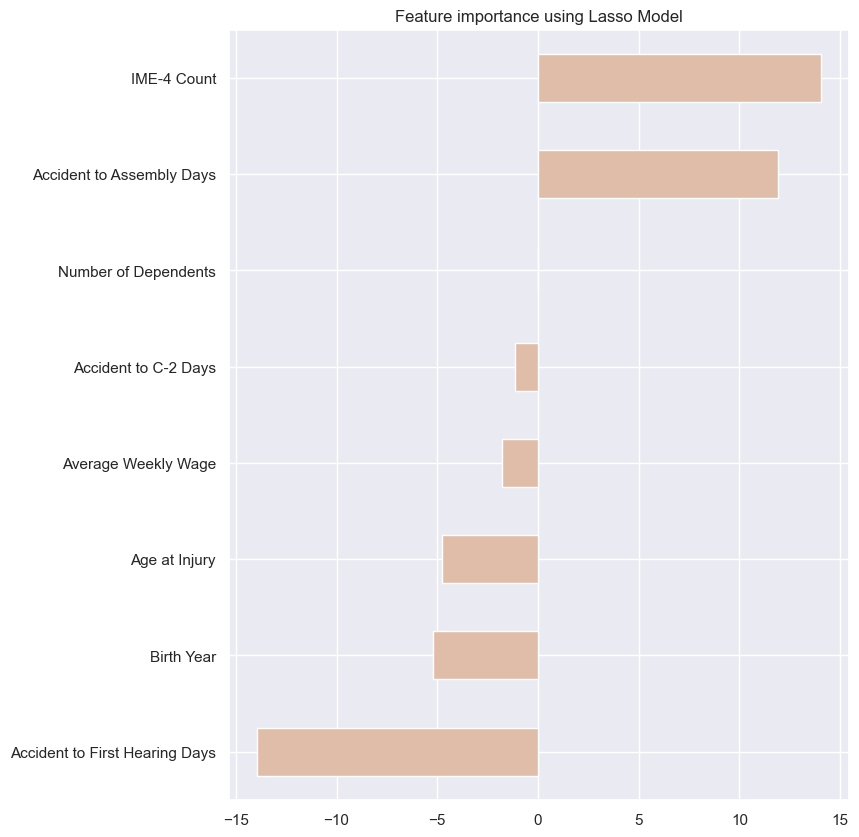

In [213]:
plot_importance(coef, "Lasso")

## Filter Methods

### Univariate Methods

In [229]:
X_train_minmax.var()

Age at Injury                     0.013219
Average Weekly Wage               0.000004
Birth Year                        0.013722
IME-4 Count                       0.000692
Number of Dependents              0.111285
Accident to C-2 Days              0.000658
Accident to Assembly Days         0.000784
Accident to First Hearing Days    0.001091
dtype: float64

### Correlation Indices

Since we have a categorical target, measuring correlations against is ill-advised (we could however use other correlation indices for this such as Point Bi-serial correlation or PhiK). Thus we will limit ourselves to using the Spearman correlation between features.

In [230]:
cor_spearman = X_train_minmax.corr(method="spearman").round(2)

mask_annot = np.absolute(cor_spearman.values) >= 0.5
annot = np.where(mask_annot, cor_spearman.values, np.full(cor_spearman.shape, ""))
annot = annot.astype(str)  # Convert to string for annotation
mask = np.triu(np.ones_like(cor_spearman, dtype=bool))

# Define the custom colors
light_color = "#e0bda8"  # Light shade
dark_color = "#c48c78"  # Darker shade
neutral_color = "#ffffff"  # Color for neutral values

# Create a custom colormap with three colors (for diverging effect)
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", [dark_color, neutral_color, light_color]
)

cor_spearman

Age at Injury  Average Weekly Wage  \
Age at Injury                            1.00                 0.03   
Average Weekly Wage                      0.03                 1.00   
Birth Year                              -0.99                -0.03   
IME-4 Count                              0.13                -0.21   
Number of Dependents                     0.00                -0.00   
Accident to C-2 Days                     0.05                 0.02   
Accident to Assembly Days                0.05                 0.02   
Accident to First Hearing Days          -0.07                 0.16   

                                Birth Year  IME-4 Count  Number of Dependents  \
Age at Injury                        -0.99         0.13                   0.0   
Average Weekly Wage                  -0.03        -0.21                  -0.0   
Birth Year                            1.00        -0.12                  -0.0   
IME-4 Count                          -0.12         1.00                   0.0   
Number of Dependents                 -0.00         0.00                   1.0   
Accident to C-2 Days                 -0.07         0.08                   0.0   
Accident to Assembly Days            -0.08         0.04                   0.0   
Accident to First Hearing Days        0.02        -0.47                  -0.0   

                                Accident to C-2 Days  \
Age at Injury                                   0.05   
Average Weekly Wage                             0.02   
Birth Year                                     -0.07   
IME-4 Count                                     0.08   
Number of Dependents                            0.00   
Accident to C-2 Days                            1.00   
Accident to Assembly Days                       0.96   
Accident to First Hearing Days                 -0.02   

                                Accident to Assembly Days  \
Age at Injury                                        0.05   
Average Weekly Wage                                  0.02   
Birth Year                                          -0.08   
IME-4 Count                                          0.04   
Number of Dependents                                 0.00   
Accident to C-2 Days                                 0.96   
Accident to Assembly Days                            1.00   
Accident to First Hearing Days                       0.01   

                                Accident to First Hearing Days  
Age at Injury                                            -0.07  
Average Weekly Wage                                       0.16  
Birth Year                                                0.02  
IME-4 Count                                              -0.47  
Number of Dependents                                     -0.00  
Accident to C-2 Days                                     -0.02  
Accident to Assembly Days                                 0.01  
Accident to First Hearing Days                            1.00

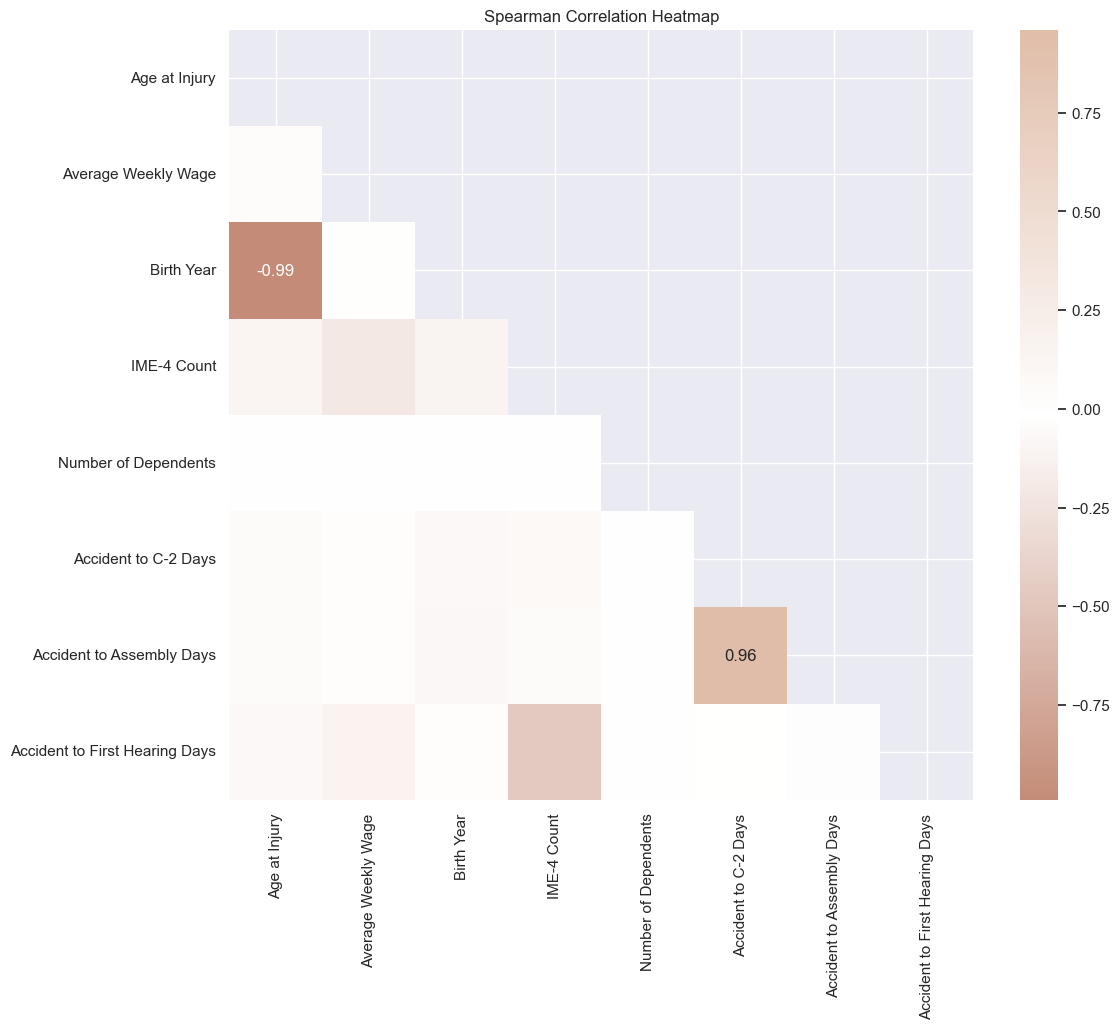

In [231]:
# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    data=cor_spearman, annot=annot, cmap=custom_cmap, mask=mask, fmt="s"
)  # fmt='s' for string
plt.title("Spearman Correlation Heatmap")
plt.show()

We can conclude that:
- We need to use other feature selection techniques to get more insights.
- There are three pairs of variables highly correlated, namely:
    - Average Weekly Wage vs Attorney/Representative (-0.99) <br>
    - Accident to Assembly Days vs Accident to C-2 Days (0.96) <br>

### Chi-Square for categorical data

In [ ]:
y_train

Claim Injury Type
0            3. MED ONLY
1           4. TEMPORARY
2            2. NON-COMP
3            2. NON-COMP
4            3. MED ONLY
...                  ...
401813       2. NON-COMP
401814   5. PPD SCH LOSS
401815      4. TEMPORARY
401816      4. TEMPORARY
401817      4. TEMPORARY

[401818 rows x 1 columns]

In [ ]:
y_train.shape

(401818, 1)

In [ ]:
dfObserved = X_train_categorical.copy()

# Add the target column to X_train_categorical
dfObserved["target"] = y_train

# Now X_train_categorical contains the original columns plus the target column
dfObserved.set_index("Claim Identifier", inplace=True)

In [ ]:
def TestIndependence2(var, alpha=0.05):
    # Create a contingency table for the variable against the "target" column
    contingency_table = pd.crosstab(dfObserved[var], dfObserved["target"])

    # Perform chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table.values)

    # Create a DataFrame for expected counts
    dfExpected = pd.DataFrame(
        expected, columns=contingency_table.columns, index=contingency_table.index
    )

    # Check the p-value and print results
    if p >= alpha:
        result = f"{var} is NOT an important predictor. (Discard {var} from model)"
        print(result)
    else:
        result = f"{var} is an important predictor. (Keep {var} in model)"

    print(result)


# Loop through each column in dfObserved (excluding 'target')
for var in dfObserved.columns:
    if var != "target":
        TestIndependence2(var)

Alternative Dispute Resolution is an important predictor. (Keep Alternative Dispute Resolution in model)
Attorney/Representative is an important predictor. (Keep Attorney/Representative in model)
Carrier Name is an important predictor. (Keep Carrier Name in model)
Carrier Type is an important predictor. (Keep Carrier Type in model)
County of Injury is an important predictor. (Keep County of Injury in model)
COVID-19 Indicator is an important predictor. (Keep COVID-19 Indicator in model)
District Name is an important predictor. (Keep District Name in model)
Medical Fee Region is an important predictor. (Keep Medical Fee Region in model)
Agreement Reached is an important predictor. (Keep Agreement Reached in model)
WCIO Cause of Injury Code SUPRA is an important predictor. (Keep WCIO Cause of Injury Code SUPRA in model)
WCIO Nature of Injury Code SUPRA is an important predictor. (Keep WCIO Nature of Injury Code SUPRA in model)
WCIO Part Of Body Code SUPRA is an important predictor. (Keep

# Preciso ajustar categoricas e numericas

<hr>

### Numerical Data

| Predictor | Spearman | RFE LR | RFECV LR | Lasso | What to do? (One possible way to "solve") |
| --- | --- | --- | --- |--- |---|
| Age at Injury | NO | NO | NO | YES | - |
| Average Weekly Wage | - | NO | NO | NO | - |
| Birth Year | - | YES | YES | YES | Keep |
| IME-4 Count | - | YES | YES | YES | Keep |
| Number of Dependents | - | NO | NO | NO | - |
| Accident to C-2 Days  | NO | YES | YES | NO | - |
| Accident to Assembly Days | - | YES | YES | YES | Keep |
| Accident to First Hearing Days  | - | YES | YES | YES | Keep |
<hr>


### Categorical Data

| Predictor | Chi-Square | 
| --- | --- | 
| Accident Date | - |  
| Assembly Date | - | 
| C-2 Date | - |
| C-3 Date | - |
| Carrier Name | - | 
| Carrier Type | - | 
| County of Injury | - |
| District Name | - | 
| First Hearing Date | - |  
| Gender | - |
| Industry Code | - |
| WCIO Cause of Injury Code | - |
| WCIO Nature of Injury Code | - |
| WCIO Part Of Body Code | - |
| Industry Code Description | - |
| Medical Fee Region | - |
| WCIO Cause of Injury Description | - | 
| WCIO Nature of Injury Description | - | 
| WCIO Part Of Body Description | - |
| Zip Code | - | 
| WCB Decision | - |  
| Claim Identifier | - | 

<hr>


In [436]:
X_train_categorical_labelencoded = X_train_categorical.copy()
X_val_categorical_labelencoded = X_val_categorical.copy()
for var in X_train_categorical.select_dtypes(include=["object"]):
    le = LabelEncoder()
    X_train_categorical_labelencoded[var] = le.fit_transform(X_train_categorical[var])
    le = LabelEncoder()
    X_val_categorical_labelencoded[var] = le.fit_transform(X_val_categorical[var])

In [437]:
X_train = pd.concat((X_train_minmax, X_train_categorical_labelencoded), axis=1)
X_val = pd.concat((X_val_minmax, X_val_categorical_labelencoded), axis=1)

In [438]:
minmax = MinMaxScaler()
X_train_scaled = minmax.fit_transform(X_train)
X_val_scaled = minmax.transform(X_val)

In [439]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(
    X_train.index
)

X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns).set_index(X_val.index)

In [440]:
X_train_scaled = X_train_scaled.drop(
    [
        "Age at Injury",
        "Average Weekly Wage",
        "Number of Dependents",
        "Accident to C-2 Days",
    ],
    axis=1,
)


X_val_scaled = X_val_scaled.drop(
    [
        "Age at Injury",
        "Average Weekly Wage",
        "Number of Dependents",
        "Accident to C-2 Days",
    ],
    axis=1,
)

In [17]:
def select_best_models(X_train, X_val, y_train, y_val, model):
    # Train the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on both training and validation sets
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)

    # Calculate the F1 score with macro averaging for both sets
    avg_train = round(f1_score(y_train, predictions_train, average="macro"), 3)
    avg_val = round(f1_score(y_val, predictions_val, average="macro"), 3)

    return (
        avg_train,
        avg_val,
    )


def show_results(models, X_train, X_val, y_train, y_val):
    df = pd.DataFrame(
        columns=["Train", "Validation", "Diff"], index=list(models.keys())
    )
    count = 0
    for label, model in models.items():
        avg_train, avg_val = select_best_models(X_train, X_val, y_train, y_val, model)

        # Store the results in the DataFrame
        df.iloc[count] = (
            str(avg_train),
            str(avg_val),
            abs(avg_train - avg_val),
        )
        count += 1
    return df

In [18]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "KNN": KNeighborsClassifier(),
    "DT": DecisionTreeClassifier(),
    "NN": MLPClassifier(max_iter=10000, random_state=99),
    "SVC": SVC(max_iter=10000),
    "Categorical NB": CategoricalNB(),
}

In [19]:
show_results(
    models, X_train_scaled, X_val_scaled, y_train.values.ravel(), y_val.values.ravel()
)

c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Diogo\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Diogo\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(args, executable, p

Train Validation   Diff
Logistic Regression  0.212      0.212    0.0
KNN                  0.369      0.254  0.115
DT                     1.0      0.267  0.733
NN                   0.306      0.301  0.005
SVC                  0.168      0.166  0.002
Categorical NB       0.171      0.169  0.002

The best base model we obtained using f1 macro score was Neural networks

In [ ]:
model = MLPClassifier(max_iter=10000, random_state=99)
model.fit(X_train_scaled, y_train.values.ravel())

predictions_train = model.predict(X_train_scaled)
predictions_val = model.predict(X_val_scaled)

report_train = classification_report(
    y_train,
    predictions_train,
)
report_val = classification_report(y_val, predictions_val)

c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [120]:
print(report_train)

                 precision    recall  f1-score   support

   1. CANCELLED       0.52      0.21      0.30      8734
    2. NON-COMP       0.72      0.95      0.82    203754
    3. MED ONLY       0.43      0.04      0.07     48234
   4. TEMPORARY       0.65      0.56      0.60    103955
5. PPD SCH LOSS       0.56      0.58      0.57     33796
     6. PPD NSL       0.50      0.00      0.00      2948
         7. PTD       1.00      0.01      0.03        68
       8. DEATH       0.44      0.03      0.06       329

       accuracy                           0.68    401818
      macro avg       0.60      0.30      0.31    401818
   weighted avg       0.65      0.68      0.63    401818



In [121]:
print(report_val)

                 precision    recall  f1-score   support

   1. CANCELLED       0.52      0.21      0.29      3743
    2. NON-COMP       0.72      0.95      0.82     87324
    3. MED ONLY       0.42      0.04      0.07     20672
   4. TEMPORARY       0.65      0.56      0.60     44552
5. PPD SCH LOSS       0.56      0.57      0.56     14484
     6. PPD NSL       1.00      0.00      0.00      1263
         7. PTD       0.00      0.00      0.00        29
       8. DEATH       0.45      0.04      0.07       141

       accuracy                           0.68    172208
      macro avg       0.54      0.29      0.30    172208
   weighted avg       0.65      0.68      0.63    172208



The reports show:
- The model struggles with the less represented categories (DEATH, PTD, PPD NSL, and MED ONLY) showing very low recall (near 0).
- NON-COMP and TEMPORARY categories have relatively high precision and recall, indicating better performance in predicting these classes.
- The PPD NSL and PTD categories have extreme precision values (1.00 for PPD NSL in training) but very low recall, suggesting the model is not identifying instances of these categories effectively.
- The model's performance is imbalanced, as evidenced by the macro average recall being much lower than the weighted average.

Embeddings

In [88]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")


def get_vectors(text):
    inputs = tokenizer(
        text, padding=True, return_tensors="pt", truncation=True, max_length=512
    )

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    return np.mean(embeddings)

c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [89]:
X_train_categorical_embeddings = X_train_categorical.copy()
for var in X_train_categorical.select_dtypes(include=["object"]).columns:
    unique_values = X_train_categorical[var].unique()
    embeddings = {i: get_vectors(i) for i in unique_values}
    X_train_categorical_embeddings[var] = X_train_categorical[var].map(
        lambda x: embeddings.get(x)
    )

X_val_categorical_embeddings = X_val_categorical.copy()
for var in X_val_categorical.select_dtypes(include=["object"]).columns:
    unique_values = X_val_categorical[var].unique()
    embeddings = {i: get_vectors(i) for i in unique_values}
    X_val_categorical_embeddings[var] = X_val_categorical[var].map(
        lambda x: embeddings.get(x)
    )

In [90]:
X_train_embeddings = pd.concat((X_train_minmax, X_train_categorical_embeddings), axis=1)
X_val_embeddings = pd.concat((X_val_minmax, X_val_categorical_embeddings), axis=1)


X_train_embeddings = X_train_embeddings.drop(
    [
        "Age at Injury",
        "Average Weekly Wage",
        "Number of Dependents",
        "Accident to C-2 Days",
    ],
    axis=1,
)


X_val_embeddings = X_val_embeddings.drop(
    [
        "Age at Injury",
        "Average Weekly Wage",
        "Number of Dependents",
        "Accident to C-2 Days",
    ],
    axis=1,
)

In [ ]:
model = MLPClassifier(max_iter=10000, random_state=99)
model.fit(X_train_embeddings, y_train.values.ravel())

predictions_train = model.predict(X_train_embeddings)
predictions_val = model.predict(X_val_embeddings)

report_train = classification_report(
    y_train,
    predictions_train,
)
report_val = classification_report(y_val, predictions_val)

c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Diogo\OneDrive - NOVAIMS\IMS - Data Science\MDS\.studyenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [98]:
print(report_train)

                 precision    recall  f1-score   support

   1. CANCELLED       0.61      0.00      0.01      8734
    2. NON-COMP       0.70      0.96      0.81    203754
    3. MED ONLY       0.31      0.01      0.02     48234
   4. TEMPORARY       0.61      0.57      0.59    103955
5. PPD SCH LOSS       0.60      0.41      0.49     33796
     6. PPD NSL       0.00      0.00      0.00      2948
         7. PTD       0.00      0.00      0.00        68
       8. DEATH       0.14      0.00      0.01       329

       accuracy                           0.67    401818
      macro avg       0.37      0.24      0.24    401818
   weighted avg       0.61      0.67      0.61    401818



In [99]:
print(report_val)

                 precision    recall  f1-score   support

   1. CANCELLED       0.59      0.01      0.01      3743
    2. NON-COMP       0.70      0.96      0.81     87324
    3. MED ONLY       0.32      0.01      0.02     20672
   4. TEMPORARY       0.61      0.57      0.59     44552
5. PPD SCH LOSS       0.60      0.41      0.49     14484
     6. PPD NSL       0.00      0.00      0.00      1263
         7. PTD       0.00      0.00      0.00        29
       8. DEATH       0.60      0.02      0.04       141

       accuracy                           0.67    172208
      macro avg       0.43      0.25      0.24    172208
   weighted avg       0.61      0.67      0.60    172208



- Using mean embeddings for encoding categorical variables didn't help

SMOTE

In [123]:
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train.values.ravel())

In [135]:
model = MLPClassifier(max_iter=10000, random_state=99)
model.fit(X_resampled, y_resampled)

predictions_train = model.predict(X_resampled)
predictions_val = model.predict(X_val_scaled)

report_train = classification_report(
    y_resampled,
    predictions_train,
)
report_val = classification_report(y_val, predictions_val)

In [136]:
print(report_train)

                 precision    recall  f1-score   support

   1. CANCELLED       0.77      0.80      0.78    203754
    2. NON-COMP       0.52      0.68      0.59    203754
    3. MED ONLY       0.43      0.29      0.35    203754
   4. TEMPORARY       0.55      0.29      0.38    203754
5. PPD SCH LOSS       0.59      0.81      0.69    203754
     6. PPD NSL       0.73      0.77      0.75    203754
         7. PTD       0.99      1.00      1.00    203754
       8. DEATH       0.96      0.99      0.98    203754

       accuracy                           0.70   1630032
      macro avg       0.69      0.70      0.69   1630032
   weighted avg       0.69      0.70      0.69   1630032



In [137]:
print(report_val)

                 precision    recall  f1-score   support

   1. CANCELLED       0.17      0.70      0.27      3743
    2. NON-COMP       0.76      0.69      0.72     87324
    3. MED ONLY       0.21      0.26      0.23     20672
   4. TEMPORARY       0.70      0.27      0.39     44552
5. PPD SCH LOSS       0.46      0.74      0.57     14484
     6. PPD NSL       0.08      0.59      0.14      1263
         7. PTD       0.00      0.03      0.01        29
       8. DEATH       0.04      0.48      0.07       141

       accuracy                           0.53    172208
      macro avg       0.30      0.47      0.30    172208
   weighted avg       0.64      0.53      0.55    172208



In [ ]:
models_2 = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "KNN": KNeighborsClassifier(),
    "DT": DecisionTreeClassifier(),
    "SVC": SVC(max_iter=10000),
    "Categorical NB": CategoricalNB(),
}
show_results(models_2, X_resampled, X_val_scaled, y_resampled, y_val.values.ravel())

Predicting test with baseline_nn

In [441]:
test_df = pd.read_csv("./resources/test_data.csv")
test_df.set_index("Claim Identifier", inplace=True)

In [442]:
test_df["Accident Date"] = pd.to_datetime(test_df["Accident Date"])
test_df["Assembly Date"] = pd.to_datetime(test_df["Assembly Date"])
test_df["First Hearing Date"] = pd.to_datetime(test_df["First Hearing Date"])
test_df["Age at Injury"] = pd.to_datetime(test_df["Age at Injury"])
test_df["Accident Date"] = test_df["Accident Date"].fillna(median_accident_date)
test_df["Accident Date"] = test_df["Accident Date"].fillna(median_accident_date)

max_date = test_df["First Hearing Date"].max()
test_df["First Hearing Date"] = test_df["First Hearing Date"].fillna(max_date)
test_df["First Hearing Date"] = test_df["First Hearing Date"].fillna(max_date)


test_df["Accident to Assembly Days"] = (
    test_df["Assembly Date"] - test_df["Accident Date"]
).dt.days
test_df["Accident to First Hearing Days"] = (
    test_df["First Hearing Date"] - test_df["Accident Date"]
).dt.days

test_df["Male"] = np.select(
    [
        test_df["Gender"] == "M",
        test_df["Gender"] == "F",
        test_df["Gender"] == "X",
        test_df["Gender"] == "U",
    ],
    [1, 0, 0, 0],
)

In [443]:
# I. Burn or Scald - Heat or Cold Exposures - Contact With
burn_or_scald = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "11", "14", "84"]

# II. Caught In, Under or Between
caught_in_under_between = ["10", "12", "13", "20"]

# III. Cut, Puncture, Scrape Injured By
cut_puncture_scrape = ["15", "16", "17", "18", "19"]

# IV. Fall, Slip or Trip Injury
fall_slip_trip = ["25", "26", "27", "28", "29", "30", "31", "32", "33"]

# V. Motor Vehicle
motor_vehicle = ["40", "41", "45", "46", "47", "48", "50"]

# VI. Strain or Injury By
strain_or_injury = ["52", "53", "54", "55", "56", "57", "58", "59", "60", "61", "97"]

# VII. Striking Against or Stepping On
striking_against = ["65", "66", "67", "68", "69", "70"]

# VIII. Struck or Injured By
struck_or_injured = ["74", "75", "76", "77", "78", "79", "80", "81", "85", "86"]

# IX. Rubbed or Abraded By
rubbed_or_abraded = ["94", "95"]

# X. Miscellaneous Causes
miscellaneous = ["82", "83", "87", "88", "89", "90", "91", "93", "96", "98", "99"]


test_df["WCIO Cause of Injury Code SUPRA"] = test_df["WCIO Cause of Injury Code"].apply(
    lambda code: (
        "I. Burn or Scald - Heat or Cold Exposures - Contact With"
        if str(code).split(".")[0] in burn_or_scald
        else (
            "II. Caught In, Under or Between"
            if str(code).split(".")[0] in caught_in_under_between
            else (
                "III. Cut, Puncture, Scrape Injured By"
                if str(code).split(".")[0] in cut_puncture_scrape
                else (
                    "IV. Fall, Slip or Trip Injury"
                    if str(code).split(".")[0] in fall_slip_trip
                    else (
                        "V. Motor Vehicle"
                        if str(code).split(".")[0] in motor_vehicle
                        else (
                            "VI. Strain or Injury By"
                            if str(code).split(".")[0] in strain_or_injury
                            else (
                                "VII. Striking Against or Stepping On"
                                if str(code).split(".")[0] in striking_against
                                else (
                                    "VIII. Struck or Injured By"
                                    if str(code).split(".")[0] in struck_or_injured
                                    else (
                                        "IX. Rubbed or Abraded By"
                                        if str(code).split(".")[0] in rubbed_or_abraded
                                        else (
                                            "X. Miscellaneous Causes"
                                            if str(code).split(".")[0] in miscellaneous
                                            else np.nan
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )
    )
)

In [444]:
# Specific Injury codes (Category I)
specific_injury = [
    "1",
    "2",
    "3",
    "4",
    "7",
    "10",
    "13",
    "16",
    "19",
    "22",
    "25",
    "28",
    "30",
    "31",
    "32",
    "34",
    "36",
    "37",
    "38",
    "40",
    "41",
    "42",
    "43",
    "46",
    "47",
    "49",
    "52",
    "53",
    "54",
    "55",
    "58",
    "59",
]

# Occupational Disease or Cumulative Injury codes (Category II)
occupational_disease = [
    "60",
    "61",
    "62",
    "63",
    "64",
    "65",
    "66",
    "67",
    "68",
    "69",
    "70",
    "71",
    "72",
    "73",
    "74",
    "75",
    "76",
    "77",
    "78",
    "79",
    "80",
    "83",
]

# Multiple Injuries codes (Category III)
multiple_injuries = ["90", "91"]


test_df["WCIO Nature of Injury Code SUPRA"] = test_df[
    "WCIO Nature of Injury Code"
].apply(
    lambda code: (
        "Category I: Specific Injury"
        if str(code).split(".")[0] in specific_injury
        else (
            "Category II: Occupational Disease or Cumulative Injury"
            if str(code).split(".")[0] in occupational_disease
            else (
                "Category III: Multiple Injuries"
                if str(code).split(".")[0] in multiple_injuries
                else np.nan
            )
        )
    )
)

In [445]:
# I. Head
head = [
    "10",
    "11",
    "12",
    "13",
    "13A",
    "13B",
    "13C",
    "14",
    "14A",
    "14B",
    "14C",
    "15",
    "16",
    "17",
    "18",
    "19",
]

# II. Neck
neck = ["20", "21", "22", "23", "24", "25", "26"]

# III. Upper Extremities
upper_extremities = [
    "30",
    "31",
    "32",
    "33",
    "34",
    "35",
    "36",
    "36A",
    "36B",
    "36C",
    "36D",
    "36E",
    "36F",
    "36G",
    "36H",
    "36I",
    "36J",
    "36K",
    "36L",
    "36M",
    "36N",
    "36O",
    "36P",
    "37",
    "37A",
    "37B",
    "37C",
    "38",
    "39",
]

# IV. Trunk
trunk = [
    "40",
    "41",
    "42",
    "43",
    "44",
    "45",
    "46",
    "47",
    "48",
    "49",
    "60",
    "61",
    "62",
    "63",
]

# V. Lower Extremities
lower_extremities = [
    "50",
    "51",
    "52",
    "53",
    "54",
    "55",
    "56",
    "57",
    "57A",
    "57B",
    "57C",
    "57D",
    "57E",
    "57F",
    "57G",
    "58",
    "58A",
    "58B",
    "58C",
]

# VI. Multiple Body Parts
multiple_body_parts = ["64", "65", "66", "90", "91", "99"]


test_df["WCIO Part Of Body Code SUPRA"] = test_df["WCIO Part Of Body Code"].apply(
    lambda code: (
        "I. Head"
        if str(code).split(".")[0] in head
        else (
            "II. Neck"
            if str(code).split(".")[0] in neck
            else (
                "III. Upper Extremities"
                if str(code).split(".")[0] in upper_extremities
                else (
                    "IV. Trunk"
                    if str(code).split(".")[0] in trunk
                    else (
                        "V. Lower Extremities"
                        if str(code).split(".")[0] in lower_extremities
                        else (
                            "VI. Multiple Body Parts"
                            if str(code).split(".")[0] in multiple_body_parts
                            else np.nan
                        )
                    )
                )
            )
        )
    )
)

Test dataset doesn't have Agreement Reached col

In [446]:
X_train_scaled.drop("Agreement Reached", inplace=True, axis=1)
test_df = test_df[X_train_scaled.columns]

In [447]:
test_df["IME-4 Count"] = test_df["IME-4 Count"].fillna(0)
test_df["WCIO Cause of Injury Code SUPRA"] = test_df[
    "WCIO Cause of Injury Code SUPRA"
].fillna(cause_mode)
test_df["WCIO Nature of Injury Code SUPRA"] = test_df[
    "WCIO Nature of Injury Code SUPRA"
].fillna(nature_mode)
test_df["WCIO Part Of Body Code SUPRA"] = test_df[
    "WCIO Part Of Body Code SUPRA"
].fillna(body_mode)
test_df["Birth Year"] = test_df["Birth Year"].replace(0, median_year)
test_df["Birth Year"] = test_df["Birth Year"].fillna(median_year)

In [452]:
for var in test_df.select_dtypes(include=["object"]):
    le = LabelEncoder()
    test_df[var] = le.fit_transform(test_df[var])

minmax = MinMaxScaler()
minmax.fit(X_train_scaled)
test_df_scaled = minmax.transform(test_df)

In [453]:
test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns).set_index(
    test_df.index
)

In [456]:
model = MLPClassifier(max_iter=10000, random_state=99)
model.fit(X_train_scaled, y_train.values.ravel())

predictions_test = model.predict(test_df_scaled)

In [462]:
predictions = pd.DataFrame(test_df_scaled.index, columns=["Claim Identifier"])
predictions["CLaim Injury Type"] = predictions_test
predictions.to_csv("predictions.csv", index=False)